### Import Libraries

In [1]:
import pandas as pd
import numpy as np

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import matplotlib.cm as cm
import matplotlib.colors as colors

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

print('--- Libraries imported  ---')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.4.1               |             py_0          26 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                       

## Import data of Paris

### Data of Paris dowtown (Borough 75)

In [2]:
df_paris=pd.read_csv('https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B', sep=';')

In [3]:
df_paris.drop(['N_SQ_AR','C_ARINSEE','L_AR','N_SQ_CO','Geometry','SURFACE','PERIMETRE','OBJECTID','LONGUEUR'], axis=1, inplace=True)

In [4]:
df_paris.rename(columns={'C_AR':'ID_Neighborhood','L_AROFF':'Neighborhood','Geometry X Y':'Coordinates'}, inplace=True)
df_paris[['Lat','Long']] =df_paris.Coordinates.str.split(",", expand=True,)
df_paris.drop(['Coordinates'], axis=1, inplace=True)
Borough_list=[75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75]
df_paris.insert(0, "Borough", Borough_list, True) 
#df_paris['Borough']=Borough_list
df_paris.head()

,Borough,ID_Neighborhood,Neighborhood,Lat,Long
0,75,3,Temple,48.86287238,2.3600009859
1,75,7,Palais-Bourbon,48.8561744288,2.31218769148
2,75,4,Hôtel-de-Ville,48.8543414263,2.35762962032
3,75,8,Élysée,48.8727208374,2.3125540224
4,75,18,Buttes-Montmartre,48.892569268,2.34816051956


In [5]:
df_paris=df_paris.astype({'Lat': 'float64', 'Long':'float64'})

### Import data of Paris suburbs

#### Data of all the French cities 

In [19]:
import types
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_f483be3dd4dd42c58fc6832eff558023 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='Ismgkvb-gXpN9CeImtmE6Oy--OIX3tAYpRt1mhDWKCE-',
    ibm_auth_endpoint="https://iam.eu-de.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_f483be3dd4dd42c58fc6832eff558023.get_object(Bucket='finalcapstoneproject-donotdelete-pr-kxsn33pngfkp7r',Key='villes_france.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# If you are reading an Excel file into a pandas DataFrame, replace `read_csv` by `read_excel` in the next statement.
df_vdf= pd.read_csv(body, header=None)
df_vdf.rename(columns={1:'Borough', 9:'ID_Neighborhood', 5:'Neighborhood', 20:'Lat', 19:'Long'}, inplace=True)
df_vdf.drop([0,2,3,4,6,7,8,10,11,12,13,14,15,16,17,18,21,22,23,24,25,26], axis=1, inplace=True)
df_vdf.head()

,Borough,Neighborhood,ID_Neighborhood,Long,Lat
0,1,Ozan,284,4.91667,46.3833
1,1,Cormoranche-sur-Saône,123,4.83333,46.2333
2,1,Plagne,298,5.73333,46.1833
3,1,Tossiat,422,5.31667,46.1333
4,1,Pouillat,309,5.43333,46.3333


#### Filtering the cities of the suburbs of Paris (boroughs 92, 93 and 94 and 7 towns from 91 and 95)

In [25]:
#print(df_vdf.dtypes)
options = ['92', '93', '94'] 

options2=['Argenteuil','Athis-Mons','Juvisy-sur-Orge', 'Morangis', 'Paray-Vieille-Poste','Savigny-sur-Orge','Viry-Châtillon']

# selecting towns of borough 92, 93 and 94
df_banlieu1 = df_vdf.loc[df_vdf['Borough'].isin(options)] 

#selecting the 7 town s of grandcouronne
df_grandcouronne=df_vdf[(df_vdf.Neighborhood.isin(options2)) & ((df_vdf.Borough=='91') | (df_vdf.Borough=='95'))]# and (df_vdf['Borough']=='91' or df_vdf['Borough']=='95')]
#print(df_grandcouronne)

#Merge the two previous df to obtain the towns of the suburb of Paris
df_banlieu = pd.concat([df_banlieu1, df_grandcouronne], sort=True)
df_banlieu.reset_index(drop=True, inplace=True)
df_banlieu.head()

,Borough,ID_Neighborhood,Lat,Long,Neighborhood
0,92,51,48.8833,2.26667,Neuilly-sur-Seine
1,92,20,48.8000,2.28333,Châtillon
2,92,9,48.9167,2.26667,Bois-Colombes
3,92,62,48.8667,2.23333,Puteaux
4,92,23,48.8000,2.26667,Clamart


In [27]:
df_banlieu.tail(10)

,Borough,ID_Neighborhood,Lat,Long,Neighborhood
120,94,77,48.7333,2.41667,Villeneuve-le-Roi
121,94,78,48.7333,2.45000,Villeneuve-Saint-Georges
122,94,28,48.7833,2.46667,Créteil
123,91,687,48.6667,2.38333,Viry-Châtillon
124,91,479,48.7167,2.36667,Paray-Vieille-Poste
125,91,432,48.7000,2.33333,Morangis
126,91,27,48.7167,2.40000,Athis-Mons
127,91,326,48.6833,2.38333,Juvisy-sur-Orge
128,91,589,48.6667,2.35000,Savigny-sur-Orge
129,95,18,48.9500,2.25000,Argenteuil


### Retrieve from Wikipedia the correct geographical coordinates of each Neighborhood of the suburb of Paris (the ones already in the df are not accurate)

In [29]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

In [30]:
#array containing the links of the pages to retrieve lat and long of each neigh
#link_banlieu=[]


link_banlieu=df_banlieu['Neighborhood'].replace(to_replace=["Châtillon"], 
                                                value="Chatillon_(Hauts-de-Seine)").replace(to_replace=["Le Plessis-Robinson"], 
                                                value="Le_Plessis-Robinson").replace(to_replace=["Asnières-sur-Seine"], 
                                                value="Asnieres-sur-Seine").replace(to_replace=["Châtenay-Malabry"], 
                                                value="Chatenay-Malabry").replace(to_replace=["Sèvres"], 
                                                value="S%c3%a8vres").replace(to_replace=["La Garenne-Colombes"], 
                                                value="La_Garenne-Colombes").replace(to_replace=["Le Bourget"], 
                                                value="Le_Bourget_(Seine-Saint-Denis)").replace(to_replace=["La Courneuve"], 
                                                value="La_Courneuve").replace(to_replace=["L'Île-Saint-Denis"], 
                                                value="L%27Ile-Saint-Denis").replace(to_replace=["Le Pré-Saint-Gervais"], 
                                                value="Le_Pr%c3%a9-Saint-Gervais").replace(to_replace=["Le Blanc-Mesnil"], 
                                                value="Le_Blanc-Mesnil").replace(to_replace=["L'Haÿ-les-Roses"], 
                                                value="L%27Hay-les-Roses").replace(to_replace=["Le Plessis-Trévise"], 
                                                value="Le_Plessis-Trevise").replace(to_replace=["Le Raincy"], 
                                                value="Le_Raincy").replace(to_replace=["Épinay-sur-Seine"], 
                                                value="Epinay-sur-Seine").replace(to_replace=["Le Kremlin-Bicêtre"], 
                                                value="Le_Kremlin-Bicetre").replace(to_replace=["Boissy-Saint-Léger"], 
                                                value="Boissy-Saint-Leger").replace(to_replace=["La Queue-en-Brie"], 
                                                value="La_Queue-en-Brie").replace(to_replace=["Saint-Maur-des-Fossés"], 
                                                value="Saint-Maur-des-Foss%c3%a9s").replace(to_replace=["Chennevières-sur-Marne"], 
                                                value="Chennevieres-sur-Marne").replace(to_replace=["Périgny"], 
                                                value="Perigny_(Val-de-Marne)").replace(to_replace=["Créteil"], 
                                                value="Creteil").replace(to_replace=["Viry-Châtillon"], 
                                                value="Viry-Chatillon").replace(to_replace=["Limeil-Brévannes"], 
                                                value="Limeil-Brevannes").replace(to_replace=["Saint-Mandé"], 
                                                value="Saint-Mande").replace(to_replace=["Le Perreux-sur-Marne"], 
                                                value="Le_Perreux-sur-Marne").replace(to_replace=["Morangis"], 
                                                value="Morangis_(Essonne)").replace(to_replace=["Argenteuil"], 
                                                value="Argenteuil_(Val-d%27Oise)").replace(to_replace=["Sceaux"], 
                                                value="Sceaux_(Hauts-de-Seine)").replace(to_replace=["Malakoff"], 
                                                value="Malakoff_(Hauts-de-Seine)").replace(to_replace=["Bagneux"], 
                                                value="Bagneux_(Hauts-de-Seine)").replace(to_replace=["Montreuil"], 
                                                value="Montreuil_(Seine-Saint-Denis)").replace(to_replace=["Saint-Denis"], 
                                                value="Saint-Denis_(Seine-Saint-Denis)").replace(to_replace=["Lilas"], 
                                                value="Les_Lilas").replace(to_replace=["Villepinte"], 
                                                value="Villepinte_(Seine-Saint-Denis)").replace(to_replace=["Saint-Ouen"], 
                                                value="Saint-Ouen-sur-Seine").replace(to_replace=["Fresnes"], 
                                                value="Fresnes_(Val-de-Marne)").replace(to_replace=["Marolles-en-Brie"], 
                                                value="Marolles-en-Brie_(Val-de-Marne)").replace(to_replace=["Saint-Maurice"], 
                                                value="Saint-Maurice_(Val-de-Marne)").replace(to_replace=["Gentilly"], 
                                                value="Gentilly_(Val-de-Marne)")



link_banlieu=link_banlieu.values.tolist()
#print(link_banlieu)

  

banlieu_latitude=[]
banlieu_longitude=[]


for l in link_banlieu:
    neigh_link=l
    neigh_url='https://fr.wikipedia.org/wiki/'+neigh_link
    #print(neigh_url)
    resp=urlopen('https://fr.wikipedia.org/wiki/'+neigh_link)
    neigh_html = resp.read()

    
    #DataFrame=pd.read_html('https://fr.wikipedia.org/wiki/'+neigh_link)
    #print(DataFrame[0])
    
    neigh_soup = BeautifulSoup(neigh_html, 'lxml', from_encoding="utf-8")
    #print(neigh_soup.find_all("a", {"class":"mw-kartographer-maplink"})[0].attrs.get('data-lat'))
    #print(neigh_soup.find_all("a", {"class":"mw-kartographer-maplink"})[0].attrs.get('data-lon'))
    #neigh_soup.a['class']

    #for l in neigh_soup.find_all('a'):
        #link.append(l.get('geo'))
        #print(l.attrs['class'])
        #print(l)
        #print(neigh_soup.a['class'])

    for i in range(10):
        try:
            mydivs_lat = neigh_soup.find_all("a", {"class":"mw-kartographer-maplink"})[i].attrs.get('data-lat')
            mydivs_lng = neigh_soup.find_all("a", {"class":"mw-kartographer-maplink"})[i].attrs.get('data-lon')
            break
        except:
            continue
    

    #print(mydivs)
    print(l, mydivs_lat, mydivs_lng)
    
    banlieu_latitude.append(mydivs_lat)
    banlieu_longitude.append(mydivs_lng)

#print(banlieu_latitude)
#print(banlieu_longitude)

Neuilly-sur-Seine 48.8880555556 2.26861111111
Chatillon_(Hauts-de-Seine) 48.8 2.29
Bois-Colombes 48.9175 2.26833333333
Puteaux 48.885 2.23888888889
Clamart 48.801389 2.262778
Meudon 48.8075 2.24027777778
Marnes-la-Coquette 48.8302777778 2.17722222222
Issy-les-Moulineaux 48.8238888889 2.27
Vaucresson 48.8391666667 2.15777777778
Rueil-Malmaison 48.877827 2.181321
Antony 48.753888889 2.2975
Le_Plessis-Robinson 48.7812073 2.2605014
Levallois-Perret 48.895 2.287222
Boulogne-Billancourt 48.8351979 2.24094672
Asnieres-sur-Seine 48.91075 2.288933
Colombes 48.9236111111 2.25222222222
Fontenay-aux-Roses 48.78932 2.28877
Garches 48.8453 2.1853
Villeneuve-la-Garenne 48.9372222222 2.32777777778
Courbevoie 48.8977777778 2.25305555556
Montrouge 48.8172222222 2.32194444444
Chatenay-Malabry 48.7652777778 2.27805555556
Clichy 48.9044444444 2.30638888889
Vanves 48.82083333 2.289722222
Ville-d'Avray 48.8261111111 2.19333333333
Suresnes 48.87 2.22
S%c3%a8vres 48.8238888889 2.21166666667
Sceaux_(Hauts-de-Se

#### Replace the lat and longitude values in the dataframe

In [31]:
df_banlieu.drop(['Lat','Long'], axis=1, inplace=True)

df_banlieu.insert(3, "Lat", banlieu_latitude, True)
df_banlieu.insert(4, "Long", banlieu_longitude, True) 

df_banlieu.head()

,Borough,ID_Neighborhood,Neighborhood,Lat,Long
0,92,51,Neuilly-sur-Seine,48.8880555556,2.26861111111
1,92,20,Châtillon,48.8,2.29
2,92,9,Bois-Colombes,48.9175,2.26833333333
3,92,62,Puteaux,48.885,2.23888888889
4,92,23,Clamart,48.801389,2.262778


In [32]:
df_banlieu.tail(10)

,Borough,ID_Neighborhood,Neighborhood,Lat,Long
120,94,77,Villeneuve-le-Roi,48.733333,2.416667
121,94,78,Villeneuve-Saint-Georges,48.7325,2.449722
122,94,28,Créteil,48.791111,2.462778
123,91,687,Viry-Châtillon,48.671342,2.374973
124,91,479,Paray-Vieille-Poste,48.7126949,2.3636645
125,91,432,Morangis,48.7054841,2.3325723
126,91,27,Athis-Mons,48.707367,2.388938
127,91,326,Juvisy-sur-Orge,48.6906559,2.3723763
128,91,589,Savigny-sur-Orge,48.679667,2.345721
129,95,18,Argenteuil,48.9478,2.2475


### Create the df of Paris Metropole merging the df of Paris downtown and Paris suburbs

In [34]:
df_parismetropole=pd.concat([df_paris,df_banlieu], sort=True)
df_parismetropole.reset_index(drop=True, inplace=True)
df_parismetropole.head()

,Borough,ID_Neighborhood,Lat,Long,Neighborhood
0,75,3,48.8629,2.36,Temple
1,75,7,48.8562,2.31219,Palais-Bourbon
2,75,4,48.8543,2.35763,Hôtel-de-Ville
3,75,8,48.8727,2.31255,Élysée
4,75,18,48.8926,2.34816,Buttes-Montmartre


In [35]:
df_parismetropole.tail(10)

,Borough,ID_Neighborhood,Lat,Long,Neighborhood
140,94,77,48.733333,2.416667,Villeneuve-le-Roi
141,94,78,48.7325,2.449722,Villeneuve-Saint-Georges
142,94,28,48.791111,2.462778,Créteil
143,91,687,48.671342,2.374973,Viry-Châtillon
144,91,479,48.7126949,2.3636645,Paray-Vieille-Poste
145,91,432,48.7054841,2.3325723,Morangis
146,91,27,48.707367,2.388938,Athis-Mons
147,91,326,48.6906559,2.3723763,Juvisy-sur-Orge
148,91,589,48.679667,2.345721,Savigny-sur-Orge
149,95,18,48.9478,2.2475,Argenteuil


In [36]:
df_parismetropole=df_parismetropole.astype({'Lat': 'float64', 'Long': 'float64'})
df_parismetropole.dtypes

Borough             object
ID_Neighborhood      int64
Lat                float64
Long               float64
Neighborhood        object
dtype: object

In [37]:
df_parismetropole.head()

,Borough,ID_Neighborhood,Lat,Long,Neighborhood
0,75,3,48.862872,2.360001,Temple
1,75,7,48.856174,2.312188,Palais-Bourbon
2,75,4,48.854341,2.357630,Hôtel-de-Ville
3,75,8,48.872721,2.312554,Élysée
4,75,18,48.892569,2.348161,Buttes-Montmartre


In [38]:
cols=df_parismetropole.columns.tolist()
print(cols)
print(type(cols))
cols=cols[:2]+cols[4:]+cols[2:4]
df_parismetropole=df_parismetropole[cols]
df_parismetropole.head()

['Borough', 'ID_Neighborhood', 'Lat', 'Long', 'Neighborhood']
<class 'list'>


,Borough,ID_Neighborhood,Neighborhood,Lat,Long
0,75,3,Temple,48.862872,2.360001
1,75,7,Palais-Bourbon,48.856174,2.312188
2,75,4,Hôtel-de-Ville,48.854341,2.357630
3,75,8,Élysée,48.872721,2.312554
4,75,18,Buttes-Montmartre,48.892569,2.348161


### Create the map of Paris

In [39]:
address = 'PARIS, FR'

geolocator = Nominatim(user_agent="paris_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Paris are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Paris are 48.8566969, 2.3514616.


In [40]:
# create map of Paris using latitude and longitude values
map_parismetropole = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, id_neighborhood, neighborhood in zip(df_parismetropole['Lat'], df_parismetropole['Long'], df_parismetropole['Borough'], df_parismetropole['ID_Neighborhood'], df_parismetropole['Neighborhood']):
    label = 'departement {}, arrondissement {}, {}'.format(borough, id_neighborhood, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_parismetropole)
    
map_parismetropole

### Create database with the data of the Boroughs and NeighBorhoods of Rome

#### Retrieve the zone information by Wikipedia

In [41]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

In [42]:
# Fetch the html file
response = urlopen('https://it.wikipedia.org/wiki/Zone_urbanistiche_di_Roma')
html_doc = response.read()

# Parse the html file
soup = BeautifulSoup(html_doc, 'html.parser')

# Format the parsed html file
strhtm = soup.prettify()


#array containing the links of the pages to retrieve lat and long of each neigh
link=[]

for l in soup.find_all('a'):
    link.append(l.get('href'))
    #print(l.get('href'))

del link[0:24]
del link[-76:]

for elem in link:
    if 'Municipio' in elem:
        link.remove(elem)
#print(link)

latitude=[]
longitude=[]


#Read the Wikipedia page of each neighborhood retrieving their latitude and longitude

for l in link:
    neigh_link=l
    neigh_url='https://it.wikipedia.org/'+neigh_link
    #print(neigh_url)
    resp=urlopen('https://it.wikipedia.org/'+neigh_link)
    neigh_html = resp.read()

    neigh_soup = BeautifulSoup(neigh_html, 'html.parser')
    #print(neigh_soup)
    #neigh_soup.a['class']

    #for l in neigh_soup.find_all('a'):
        #link.append(l.get('geo'))
        #print(l.attrs['class'])
        #print(l)
        #print(neigh_soup.a['class'])

    for i in range(10):
        try:
            mydivs = neigh_soup.find_all("a", {"class": "external text"})[i].findChildren()[5].text
            break
        except:
            continue
    
    #print(mydivs)
    try:
        mydivs=mydivs.split('E')[1]
    except:
        pass
    lat=mydivs.split(";")[0]
    long=mydivs.split(";")[1]
    try:
        long=long.split("\ufeff")[0]
    except:
        pass
    #print(mydivs)
    latitude.append(lat)
    longitude.append(long)

#print(latitude)
#print(longitude)


Borough_Roma=[]
Neighbor_Roma=[]


# Read the list of all the neighborhoods of Rome and create the df    
    
for x in soup.find_all('a'): 
    #print(x.string)
    Neighbor_Roma.append(x.string)
    
    
Neighbor_RM=(Neighbor_Roma[23:193])
#print(Neighbor_RM)


Municipio=''
Borough_RM=[]

for i in range(len(Neighbor_RM)):
    if 'Municipio' in Neighbor_RM[i]:
        Municipio=Neighbor_RM[i]
    else:
        Borough_RM.append(Municipio)
        

Neighbor_RM = [ elem for elem in Neighbor_RM if 'Municipio' not in elem] 

if len(Neighbor_RM)==155:
    print('OK all the neighborhood data have been retrieved (',len(Neighbor_RM),' out of 155 neighborhoods uploaded)')
else:
    print('Error not all the neighborhood data have been retrieved (',len(Neighbor_RM),' out of 155 neighborhoods uploaded)')

OK all the neighborhood data have been retrieved ( 155  out of 155 neighborhoods uploaded)


In [43]:
df_Roma=pd.DataFrame({'Borough': Borough_RM, 'Neighborhood': Neighbor_RM, 'Latitude': latitude, 'Longitude':longitude})
df_Roma=df_Roma.astype({'Latitude':'float64', 'Longitude':'float64'})
df_Roma.head()

,Borough,Neighborhood,Latitude,Longitude
0,Municipio Roma I,Centro Storico,41.899000,12.476600
1,Municipio Roma I,Trastevere,41.887222,12.465556
2,Municipio Roma I,Aventino,41.880100,12.485200
3,Municipio Roma I,Testaccio,41.876111,12.475000
4,Municipio Roma I,Esquilino,41.893056,12.503889


### Create map of Rome

In [44]:
address_rome = 'ROME, IT'

geolocator = Nominatim(user_agent="rome_explorer")
location = geolocator.geocode(address_rome)
latitude_rome = location.latitude
longitude_rome = location.longitude
print('The geograpical coordinate of Rome are {}, {}.'.format(latitude_rome, longitude_rome))

The geograpical coordinate of Rome are 41.8933203, 12.4829321.


In [45]:
# create map of Paris using latitude and longitude values
map_rome = folium.Map(location=[latitude_rome, longitude_rome], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_Roma['Latitude'], df_Roma['Longitude'], df_Roma['Borough'], df_Roma['Neighborhood']):
    label = '{}, Zona {}'.format(borough, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_rome)
    
map_rome

### Retrieve venues data from Foursquare

In [49]:
CLIENT_ID = 'KHZBXMEDDQQIBVII1WTJF4NKKNPK1YME5LTIA1WYFOVGPMCG' # Foursquare ID
CLIENT_SECRET = 'F51ANKJJT4LFDD5YNZAI1Z3M0H4SCRBUWGVTW0K2UPJIWI1M' # Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=200

## Retrieve Paris venues

### The radius of research for each neighborhood is calculated as the half of the distance of the neighborhood with the one closet to it

In [51]:
def getNearbyVenue(boroughs, id_names, names, latitudes, longitudes):
    
 
    venues_list=[]
    for borough, id_name, name, lat, lng in zip(boroughs, id_names, names, latitudes, longitudes):
        
        
        dist=[]
        
        for borough2, id_name2, name2, lat2, lng2 in zip(boroughs, id_names, names, latitudes, longitudes):
            R = 6371e3 # metres
            dlng = (lng2 - lng)*np.pi/180
            dlat = (lat2 - lat)*np.pi/180
            a = (np.sin(dlat/2))**2 + np.cos(lat*np.pi/180) * np.cos(lat2*np.pi/180) * (np.sin(dlng/2))**2
            c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a) )
            d = R * c #(where R is the radius of the Earth)
                
                #R = 6371e3 # metres
                #phi1 = lat * np.pi/180 # φ, λ in radians
                #phi2 = lat2 * np.pi/180
                #Delta_phi = (lat2-lat) * np.pi/180
                #Delta_lambda = (lng2-lng) * np.pi/180
                #d = np.arccos(np.sin(phi1)*np.sin(phi2) + np.cos(phi1)*np.cos(phi2) * np.cos(Delta_lambda)) * R
            if d!=0:
                dist.append(d)
            else:
                continue
            
        
        min_dist=np.amin(dist)
        radius=int(min_dist/2.)
        
        print(name, radius)
        #print(dist)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            borough,
            id_name,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough','ID_Neighborhood','Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [52]:
parismetropole_venues = getNearbyVenue(boroughs=df_parismetropole['Borough'], id_names=df_parismetropole['ID_Neighborhood'],names=df_parismetropole['Neighborhood'],
                                   latitudes=df_parismetropole['Lat'],
                                   longitudes=df_parismetropole['Long']
                                  )

Temple 482
Palais-Bourbon 852
Hôtel-de-Ville 482
Élysée 839
Buttes-Montmartre 941
Observatoire 689
Ménilmontant 695
Popincourt 763
Gobelins 987
Panthéon 605
Luxembourg 702
Reuilly 415
Louvre 393
Entrepôt 737
Passy 1557
Opéra 531
Buttes-Chaumont 706
Bourse 393
Batignolles-Monceau 832
Vaugirard 1076
Neuilly-sur-Seine 782
Châtillon 595
Bois-Colombes 679
Puteaux 879
Clamart 891
Meudon 891
Marnes-la-Coquette 633
Issy-les-Moulineaux 741
Vaucresson 866
Rueil-Malmaison 1231
Antony 902
Le Plessis-Robinson 1094
Levallois-Perret 782
Boulogne-Billancourt 933
Asnières-sur-Seine 727
Colombes 679
Fontenay-aux-Roses 595
Garches 885
Villeneuve-la-Garenne 442
Courbevoie 535
Montrouge 689
Châtenay-Malabry 871
Clichy 727
Vanves 277
Ville-d'Avray 633
Suresnes 1082
Sèvres 682
Sceaux 599
Chaville 988
La Garenne-Colombes 535
Gennevilliers 1037
Nanterre 1217
Saint-Cloud 933
Malakoff 277
Bagneux 758
Bourg-la-Reine 811
Le Bourget 973
Bagnolet 602
La Courneuve 1068
Pavillons-sous-Bois 392
Sevran 792
Villemomble 5

In [53]:
print(parismetropole_venues.shape)
parismetropole_venues.head()

(3805, 9)


,Borough,ID_Neighborhood,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,75,3,Temple,48.862872,2.360001,Mmmozza,48.863910,2.360591,Sandwich Place
1,75,3,Temple,48.862872,2.360001,Chez Alain Miam Miam,48.862369,2.361950,Sandwich Place
2,75,3,Temple,48.862872,2.360001,Fromagerie Jouannault,48.862947,2.362530,Cheese Shop
3,75,3,Temple,48.862872,2.360001,Square du Temple,48.864475,2.360816,Park
4,75,3,Temple,48.862872,2.360001,Marché des Enfants Rouges,48.862806,2.361996,Farmers Market


In [54]:
parismetropole_venues_old=parismetropole_venues

In [75]:
parismetropole_venues=parismetropole_venues_old

In [55]:
parismetropole_venues['Venue Category'].unique()

array(['Sandwich Place', 'Cheese Shop', 'Park', 'Farmers Market',
       'Okonomiyaki Restaurant', 'Burger Joint', 'Hotel',
       'Japanese Restaurant', 'Wine Bar', 'Dessert Shop', 'Hotel Bar',
       'Italian Restaurant', 'Tea Room', 'Seafood Restaurant',
       'Cocktail Bar', 'Vietnamese Restaurant', 'Bookstore',
       'Clothing Store', 'Garden', 'Bubble Tea Shop', 'Coffee Shop',
       'French Restaurant', 'Art Gallery', 'Supermarket',
       'Health Food Store', 'Juice Bar', 'Art Museum', 'Chocolate Shop',
       'Bistro', 'Cosmetics Shop', 'Gourmet Shop', 'Comic Shop', 'Bakery',
       'Chinese Restaurant', 'Noodle House', 'Argentinian Restaurant',
       'Vegetarian / Vegan Restaurant', 'Museum', 'Moroccan Restaurant',
       'Frozen Yogurt Shop', 'Wine Shop', 'Deli / Bodega',
       'Thai Restaurant', 'Cupcake Shop', 'Theater', 'Historic Site',
       'Plaza', 'History Museum', 'Korean Restaurant',
       'Food & Drink Shop', 'New American Restaurant',
       'Basque Restaura

### Affect all the venues categories to some macro-categories

In [58]:
parismetropole_venues_1=parismetropole_venues['Venue Category']
parismetropole_venues=parismetropole_venues.replace(to_replace=['Pakistani Restaurant','Udon Restaurant', 'Shanxi Restaurant','Szechuan Restaurant','Tibetan Restaurant', 'Noodle House','Soba Restaurant','Indonesian Restaurant','Cantonese Restaurant','Cambodian Restaurant','Jiangxi Restaurant','Okonomiyaki Restaurant','Deli / Bodega','Indian Restaurant','Taiwanese Restaurant','Chinese Restaurant','Japanese Restaurant','Thai Restaurant','Ramen Restaurant','Sushi Restaurant','Dumpling Restaurant','Filipino Restaurant','Vietnamese Restaurant','Korean Restaurant','Dim Sum Restaurant','Asian Restaurant']
                            ,value ="Asian Restaurant").replace(to_replace=['Swiss Restaurant','Spanish Restaurant','English Restaurant','Eastern European Restaurant','Russian Restaurant','Trattoria/Osteria','Italian Restaurant','Modern European Restaurant','Portuguese Restaurant','German Restaurant','Belgian Restaurant','Greek Restaurant','Restaurant','Italian Restaurant','Scandinavian Restaurant']
                            ,value ="European Restaurant").replace(to_replace=["Ch'ti Restaurant",'Lyonese Bouchon','Fondue Restaurant', 'Alsatian Restaurant','Auvergne Restaurant','Southwestern French Restaurant','Cajun / Creole Restaurant','Savoyard Restaurant','Basque Restaurant','Creperie','Breton Restaurant','Brasserie','Bistro','Corsican Restaurant', 'Provençal Restaurant','French Restaurant']
                            ,value ="French Restaurant").replace(to_replace=['Jewish Restaurant','Venezuelan Restaurant','African Restaurant','Arepa Restaurant','Burrito Place','Southern / Soul Food Restaurant','Halal Restaurant','Caribbean Restaurant','Hawaiian Restaurant','New American Restaurant','American Restaurant','South American Restaurant','Argentinian Restaurant','Colombian Restaurant','Mexican Restaurant','Latin American Restaurant','Brazilian Restaurant', 'Peruvian Restaurant','Moroccan Restaurant','Ethiopian Restaurant', 'Midle East Restaurant','Persian Restaurant','Lebanese Restaurant','Turkish Restaurant','Middle Eastern Restaurant','Falafel Restaurant','Afghan Restaurant', 'Israeli Restaurant']
                            ,value ="Exotic Restaurant").replace(to_replace=['Food','Empanada Restaurant','Gastropub','Comfort Food Restaurant','Diner','Breakfast Spot','Steakhouse','Soup Place','Sandwich Place','Salad Place','Fried Chicken Joint','Food Court','Theme Restaurant','Molecular Gastronomy Restaurant','Mediterranean Restaurant','Seafood Restaurant','Vegetarian / Vegan Restaurant','Gluten-free Restaurant']
                            ,value="Other Food Place").replace(to_replace=['Wings Joint','Burger Joint','Kebab Restaurant','Tapas Restaurant','BBQ Joint','Taco Place', 'Food Truck','Pizza Place','Snack Place','Doner Restaurant','Fast Food Restaurant',]
                            ,value="Fast Food Restaurant").replace(to_replace=['Bathing Area','Hockey Rink','Athletics & Sports','Racetrack','Trail','Pool Hall','Dive Spot','Indoor Play Area','Football Stadium','Hockey Arena','Martial Arts Dojo','Rugby Stadium', 'Rugby Pitch','Basketball Stadium','Golf Course','Track Stadium', 'Basketball Court','Tennis Stadium','Tennis Court','Soccer Stadium','Racecourse','Boxing Gym','Stadium','Cycle Studio','Climbing Gym','Yoga Studio','Soccer Field','Pool','Sports Club','Gym','Gym Pool',' Athletics & Sports','Basketball Stadium', 'Baseball Stadium', 'Gym / Fitness Center', 'Dance Studio']
                            ,value="Sport place").replace(to_replace=['Child Care Service','General College & University','Music School','Trade School','Circus School','School','Library','College Arts Building','College Gym', 'College Rec Center']
                            ,value="School/Education").replace(to_replace=['Outdoor Supply Store','Leather Goods Store','Clothing Store', '"Mens Store"',"Women's Store", "Men's Store",'Music Store','Paper / Office Supplies Store','Newsstand','Print Shop','Shop & Service','Photography Studio','Shoe Store','Locksmith','Flower Shop','Smoke Shop','Board Shop','Kids Store','Optical Shop','Sporting Goods Shop','Big Box Store','Mobile Phone Shop','Candy Store','Pop-Up Shop','Souvlaki Shop','Souvenir Shop','Adult Boutique','Chocolate Shop','Comic Shop','Hobby Shop','Miscellaneous Shop','Record Shop','Shopping Mall','Smoke Shop','Sporting Goods Shop','Electronics Store', 'Toy / Game Store','Video Game Store','Baby Store','Bookstore','Camera Store','Pet Store']
                            ,value="Shop/Store").replace(to_replace=['Discount Store','Gift Shop','Convenience Store','Thrift / Vintage Store']
                            ,value="Discount Store").replace(to_replace=['Bridal Shop','Duty-free Shop','Shopping Plaza','Perfume Shop','Boutique', 'Antique Shop','Cosmetics Shop','Gourmet Shop','Tailor Shop','Accessories Store','Arts & Crafts Store','Department Store','Jewelry Store','Lingerie Store','Liquor Store']
                            ,value="Lux Store").replace(to_replace =['Frozen Yogurt Shop','Smoothie Shop','Ice Cream Shop','Donut Shop','Bagel Shop','Bubble Tea Shop','Cupcake Shop','Butcher','Food & Drink Shop', 'Fruit & Vegetable Store','Fish & Chips Shop','Vineyard','Health Food Store','Organic Grocery','Grocery Store', 'Bakery', 'Supermarket','Cheese Shop', 'Pastry Shop', 'Beer Store', 'Wine Shop']
                            ,value ="Grocery").replace(to_replace =['Hotel','Hotel Bar', 'Lounge', 'Resort', 'Sauna / Steam Room', 'Spa']
                            ,value ="Hotel").replace(to_replace =['Vacation Rental','Recreation Center','Boarding House','Residential Building (Apartment / Condo)','Motel','Hostel', 'Bed & Breakfast','Campground']
                            ,value ="Low cost accomodation").replace(to_replace =['Memorial Site','Tourist Information Center','Outdoor Sculpture','Street Art','Arcade','Castle','Science Museum','Event Space','Fountain','Planetarium','Performing Arts Venue','Scenic Lookout','Cultural Center','Museum','Bridge','Church','Exhibit','Pedestrian Plaza', 'Plaza','Art Gallery','Art Museum','Monument / Landmark','History Museum','Performing Arts Venue','Sculpture Garden', 'Canal', 'Historic Site']
                            ,value ="Touristic").replace(to_replace =['Heliport', 'Airport','Airport Lounge', 'Airport Terminal','Airport Food Court','Airport Gate','Airport Service']
                            ,value ="Airport").replace(to_replace =['Cafeteria',"Café","Dessert Shop", "Tea Room", 'Gaming Cafe']
                            ,value ="Coffee Shop").replace(to_replace =['Gay Bar','Champagne Bar','Juice Bar','Sports Bar','Karaoke Bar','Brewery','Hookah Bar','Whisky Bar','Wine Bar','Pub','Beer Bar' ,'Irish Pub','Cocktail Bar', 'Speakeasy', 'Roof Deck', 'Beer Garden', 'Nightclub']
                            ,value ="Bar").replace(to_replace =['Food Stand','Night Market','Christmas Market','Flea Market','Farmers Market','Fish Market','Market']
                            ,value ="Market").replace(to_replace =['Go Kart Track','Skating Rink','Skate Park','Bowling Alley','Laser Tag']
                            ,value ="Games").replace(to_replace =['Arts & Entertainment','Casino','Circus','Theme Park Ride / Attraction','Drive-in Theater', 'Rock Club', 'Multiplex']
                            ,value ="Entertainment").replace(to_replace =['Movie Theater','College Theater','Jazz Club', 'General Entertainment','Indie Movie Theater', 'Concert Hall', 'Comedy Club', 'Theater', 'Opera House', 'Music Venue', 'Movie Theater']
                            ,value ="Opera/Theater").replace(to_replace =['Insurance Office','Film Studio','Event Service','Recording Studio','Radio Station','City Hall','Real Estate Office',  'Non-Profit','Office', 'Transportation Service']
                            ,value ="Offices").replace(to_replace =['IT Services', 'Coworking Space','Hardware Store','Tech Startup']
                            ,value ="IT").replace(to_replace =['Airport Tram', 'Rest Area','Tunnel','Harbor / Marina','Bus Line','Boat or Ferry', 'Intersection','Light Rail Station','Metro Station','Bus Stop','Bus Station','Tram Station','Train Station','Bike Rental / Bike Share']
                            ,value ="Transports").replace(to_replace =['Waterfront','Island','Beach','Tree','Canal Lock','River','Cemetery','Park','State / Provincial Park','Garden Center','Lake', 'National Park','Aquarium','Track', 'Forest','Botanical Garden', 'Garden','Zoo', 'Playground', 'Poke Place', 'Zoo Exhibit']
                            ,value ="Park").replace(to_replace =['Dry Cleaner','Entertainment Service','Shoe Repair','Travel Agency','Astrologer','Massage Studio','Funeral Home','Daycare','Laundromat','Salon / Barbershop','Health & Beauty Service']
                            ,value ="Services").replace(to_replace =['Convention Center','Lawyer','Financial or Legal Service','Bank','Business Service']
                            ,value ="Business").replace(to_replace =['Medical Center',"Dentist's Office",'Medical Supply Store','Pharmacy']
                            ,value ="Medical").replace(to_replace =['Neighborhood','Home Service', 'Building','Construction & Landscaping', 'Furniture / Home Store']
                            ,value ="Building").replace(to_replace =['Car Wash','Gas Station','Auto Dealership','Auto Garage','Rental Service','Rental Car Location','Auto Workshop','Other Repair Shop', 'Automotive Shop','Motorcycle Shop']
                            ,value ="Auto/Moto").replace(to_replace =['Factory', 'Recycling Facility']
                            ,value ="Factory").replace(to_replace =['Stables','Farm']
                            ,value ="Farm")


In [59]:
parismetropole_venues['Venue Category'].unique()

array(['Other Food Place', 'Grocery', 'Park', 'Market',
       'Asian Restaurant', 'Fast Food Restaurant', 'Hotel', 'Bar',
       'Coffee Shop', 'European Restaurant', 'Shop/Store',
       'French Restaurant', 'Touristic', 'Lux Store', 'Exotic Restaurant',
       'Opera/Theater', 'Services', 'Sport place', 'Building',
       'Discount Store', 'Transports', 'Low cost accomodation', 'Medical',
       'Entertainment', 'Offices', 'IT', 'School/Education', 'Auto/Moto',
       'Business', 'Games', 'Farm', 'Factory', 'Airport'], dtype=object)

In [60]:
parismetropole_venues.tail()

,Borough,ID_Neighborhood,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
3800,95,18,Argenteuil,48.9478,2.2475,Gare SNCF de Val d'Argenteuil,48.950424,2.231657,Transports
3801,95,18,Argenteuil,48.9478,2.2475,Géant Casino,48.944180,2.253380,Grocery
3802,95,18,Argenteuil,48.9478,2.2475,Patinoire d'Argenteuil,48.949816,2.232703,Sport place
3803,95,18,Argenteuil,48.9478,2.2475,La Ferme d'Argenteuil,48.937728,2.245194,French Restaurant
3804,95,18,Argenteuil,48.9478,2.2475,Givaudan Canteen,48.946708,2.264393,European Restaurant


In [61]:
parismetropole_venues.head()

,Borough,ID_Neighborhood,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,75,3,Temple,48.862872,2.360001,Mmmozza,48.863910,2.360591,Other Food Place
1,75,3,Temple,48.862872,2.360001,Chez Alain Miam Miam,48.862369,2.361950,Other Food Place
2,75,3,Temple,48.862872,2.360001,Fromagerie Jouannault,48.862947,2.362530,Grocery
3,75,3,Temple,48.862872,2.360001,Square du Temple,48.864475,2.360816,Park
4,75,3,Temple,48.862872,2.360001,Marché des Enfants Rouges,48.862806,2.361996,Market


### Create the top 10 venues for each neighborhood

In [163]:
# one hot encoding
parismetropole_onehot = pd.get_dummies(parismetropole_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
parismetropole_onehot['Neighborhood'] = parismetropole_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [parismetropole_onehot.columns[-1]] + list(parismetropole_onehot.columns[:-1])
parismetropole_onehot = parismetropole_onehot[fixed_columns]

parismetropole_grouped = parismetropole_onehot.groupby('Neighborhood').mean().reset_index()
parismetropole_grouped.head()

,Neighborhood,Airport,Asian Restaurant,Auto/Moto,Bar,Building,Business,Coffee Shop,Discount Store,Entertainment,...,Offices,Opera/Theater,Other Food Place,Park,School/Education,Services,Shop/Store,Sport place,Touristic,Transports
0,Ablon-sur-Seine,0.0,0.000000,0.0,0.0,0.000000,0.25,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.250000,0.000000,0.250000
1,Alfortville,0.0,0.181818,0.0,0.0,0.090909,0.00,0.0,0.0,0.0,...,0.0,0.090909,0.0,0.000000,0.0,0.0,0.090909,0.000000,0.000000,0.272727
2,Antony,0.0,0.058824,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.176471,0.0,0.0,0.058824,0.000000,0.058824,0.058824
3,Arcueil,0.0,0.000000,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.500000
4,Argenteuil,0.0,0.000000,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.142857,0.000000,0.142857


In [164]:
parismetropole_grouped.tail()

,Neighborhood,Airport,Asian Restaurant,Auto/Moto,Bar,Building,Business,Coffee Shop,Discount Store,Entertainment,...,Offices,Opera/Theater,Other Food Place,Park,School/Education,Services,Shop/Store,Sport place,Touristic,Transports
144,Vincennes,0.0,0.130435,0.000000,0.043478,0.000000,0.0,0.021739,0.0,0.000000,...,0.000000,0.043478,0.021739,0.000000,0.0,0.0,0.065217,0.000000,0.021739,0.021739
145,Viry-Châtillon,0.0,0.235294,0.000000,0.000000,0.000000,0.0,0.058824,0.0,0.000000,...,0.000000,0.000000,0.058824,0.058824,0.0,0.0,0.058824,0.117647,0.000000,0.058824
146,Vitry-sur-Seine,0.0,0.000000,0.111111,0.000000,0.111111,0.0,0.000000,0.0,0.000000,...,0.000000,0.111111,0.000000,0.111111,0.0,0.0,0.111111,0.000000,0.222222,0.000000
147,Élysée,0.0,0.020000,0.000000,0.020000,0.010000,0.0,0.010000,0.0,0.000000,...,0.000000,0.020000,0.050000,0.070000,0.0,0.0,0.070000,0.000000,0.110000,0.000000
148,Épinay-sur-Seine,0.0,0.133333,0.066667,0.000000,0.000000,0.0,0.000000,0.0,0.066667,...,0.066667,0.000000,0.000000,0.066667,0.0,0.0,0.200000,0.000000,0.000000,0.133333


In [165]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    row_venues=[]
    
    for i in range(num_top_venues):
        if row_categories_sorted[i]!=0.0:
            row_venues.append(row_categories_sorted.index.values[i])
        else: 
            row_venues.append('Void')
    
    #return row_categories_sorted.index.values[0:num_top_venues]
    return row_venues

In [166]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = parismetropole_grouped['Neighborhood']

for ind in np.arange(parismetropole_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(parismetropole_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ablon-sur-Seine,Transports,Medical,Sport place,Business,Void,Void,Void,Void,Void,Void
1,Alfortville,Transports,Asian Restaurant,French Restaurant,Building,Opera/Theater,Shop/Store,Fast Food Restaurant,Void,Void,Void
2,Antony,Grocery,Park,European Restaurant,Market,Asian Restaurant,Exotic Restaurant,Fast Food Restaurant,French Restaurant,Touristic,Transports
3,Arcueil,Transports,Games,French Restaurant,Void,Void,Void,Void,Void,Void,Void
4,Argenteuil,Grocery,French Restaurant,European Restaurant,Fast Food Restaurant,Transports,Sport place,Void,Void,Void,Void


## Analysis for the number of clusters to split Paris

### Analyse the cluster inertia by mdifying the number of clusters

In [167]:
from sklearn.cluster import KMeans
# define the dataframe columns
parismetropole_Inertia_Col = ['ClusterNumber', 'Inertia'] 

# instantiate the dataframe
parismetropole_Inertia_Df = pd.DataFrame(columns=parismetropole_Inertia_Col)

parismetropole_grouped_clustering = parismetropole_grouped.drop('Neighborhood', 1)
for k in range (1, 15):
    # Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
    parismetropole_kmeans_model = KMeans(n_clusters=k, random_state=1, init='k-means++', n_init=10, max_iter=300, tol=0.0001,).fit(parismetropole_grouped_clustering)
    parismetropole_inertia = parismetropole_kmeans_model.inertia_
    parismetropole_Inertia_Df = parismetropole_Inertia_Df.append({'ClusterNumber': k,
                                          'Inertia': parismetropole_inertia,
                                                     }, ignore_index=True)

In [168]:
parismetropole_Inertia_Df=parismetropole_Inertia_Df.set_index("ClusterNumber")

In [169]:
from sklearn import preprocessing

x = parismetropole_Inertia_Df[['Inertia']].values.astype(float)

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# Run the normalizer on the dataframe
#parismetropole_Inertia_Df[['Inertia']] = pd.DataFrame(x_scaled)
parismetropole_Inertia_Df[['Inertia']] = pd.DataFrame(x)

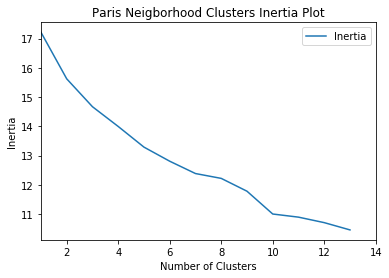

In [170]:
from matplotlib import pyplot as plt


# Plotting the results
parismetropole_Inertia_Df.index = parismetropole_Inertia_Df.index.map(int)
parismetropole_Inertia_Df.plot(kind='line')

plt.title('Paris Neigborhood Clusters Inertia Plot')
plt.ylabel('Inertia')
plt.xlabel('Number of Clusters')

plt.show()

In [171]:
# set number of clusters
kclusters = 5

parismetropole_grouped_clustering = parismetropole_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(parismetropole_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 3, 1, 3, 3, 3, 2, 3, 2], dtype=int32)

In [172]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

parismetropole_merged = df_parismetropole

# merge paris_grouped with paris_data to add latitude/longitude for each neighborhood
parismetropole_merged =parismetropole_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
parismetropole_merged.dropna(axis=0, inplace=True)
parismetropole_merged =parismetropole_merged.astype({'Cluster Labels': 'int32'})
parismetropole_merged.head(100) # check the last columns!

,Borough,ID_Neighborhood,Neighborhood,Lat,Long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,75,3,Temple,48.862872,2.360001,0,Asian Restaurant,Grocery,Bar,French Restaurant,Other Food Place,Touristic,Coffee Shop,Lux Store,Shop/Store,Fast Food Restaurant
1,75,7,Palais-Bourbon,48.856174,2.312188,0,French Restaurant,Touristic,Hotel,Coffee Shop,European Restaurant,Park,Grocery,Bar,Asian Restaurant,Other Food Place
2,75,4,Hôtel-de-Ville,48.854341,2.357630,0,French Restaurant,Touristic,Grocery,Shop/Store,Coffee Shop,Bar,Hotel,European Restaurant,Park,Lux Store
3,75,8,Élysée,48.872721,2.312554,0,Hotel,French Restaurant,Lux Store,Touristic,Grocery,Shop/Store,Park,Other Food Place,Asian Restaurant,Bar
4,75,18,Buttes-Montmartre,48.892569,2.348161,0,French Restaurant,Bar,Touristic,Asian Restaurant,European Restaurant,Other Food Place,Coffee Shop,Grocery,Exotic Restaurant,Fast Food Restaurant
5,75,14,Observatoire,48.829245,2.326542,0,French Restaurant,Hotel,Asian Restaurant,Grocery,European Restaurant,Bar,Fast Food Restaurant,Coffee Shop,Touristic,Discount Store
6,75,20,Ménilmontant,48.863461,2.401188,0,French Restaurant,Grocery,Bar,Asian Restaurant,Park,European Restaurant,Touristic,Fast Food Restaurant,Coffee Shop,Hotel
7,75,11,Popincourt,48.859059,2.380058,0,Bar,French Restaurant,European Restaurant,Asian Restaurant,Other Food Place,Coffee Shop,Grocery,Shop/Store,Exotic Restaurant,Fast Food Restaurant
8,75,13,Gobelins,48.828388,2.362272,0,Asian Restaurant,French Restaurant,Grocery,Sport place,Hotel,Bar,Coffee Shop,Other Food Place,Exotic Restaurant,Lux Store
9,75,5,Panthéon,48.844443,2.350715,0,French Restaurant,Touristic,Coffee Shop,Asian Restaurant,Grocery,Bar,European Restaurant,Exotic Restaurant,Hotel,Other Food Place


In [173]:
address = 'PARIS, FR'

geolocator = Nominatim(user_agent="paris_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Paris are {}, {}.'.format(latitude, longitude))

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, bor, id_poi, poi, cluster in zip(parismetropole_merged['Lat'], parismetropole_merged['Long'], parismetropole_merged['Borough'], parismetropole_merged['ID_Neighborhood'], parismetropole_merged['Neighborhood'], parismetropole_merged['Cluster Labels']):
    label = folium.Popup('DEPARTEMENT '+str(bor)+' ARRONDISSEMENT '+str(id_poi)+' '+ str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The geograpical coordinate of Paris are 48.8566969, 2.3514616.


In [174]:
df_cluster0=parismetropole_merged.loc[parismetropole_merged['Cluster Labels'] == 0, parismetropole_merged.columns[[0]+[2] + list(range(5, parismetropole_merged.shape[1]))]]
df_cluster0

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,75,Temple,0,Asian Restaurant,Grocery,Bar,French Restaurant,Other Food Place,Touristic,Coffee Shop,Lux Store,Shop/Store,Fast Food Restaurant
1,75,Palais-Bourbon,0,French Restaurant,Touristic,Hotel,Coffee Shop,European Restaurant,Park,Grocery,Bar,Asian Restaurant,Other Food Place
2,75,Hôtel-de-Ville,0,French Restaurant,Touristic,Grocery,Shop/Store,Coffee Shop,Bar,Hotel,European Restaurant,Park,Lux Store
3,75,Élysée,0,Hotel,French Restaurant,Lux Store,Touristic,Grocery,Shop/Store,Park,Other Food Place,Asian Restaurant,Bar
4,75,Buttes-Montmartre,0,French Restaurant,Bar,Touristic,Asian Restaurant,European Restaurant,Other Food Place,Coffee Shop,Grocery,Exotic Restaurant,Fast Food Restaurant
5,75,Observatoire,0,French Restaurant,Hotel,Asian Restaurant,Grocery,European Restaurant,Bar,Fast Food Restaurant,Coffee Shop,Touristic,Discount Store
6,75,Ménilmontant,0,French Restaurant,Grocery,Bar,Asian Restaurant,Park,European Restaurant,Touristic,Fast Food Restaurant,Coffee Shop,Hotel
7,75,Popincourt,0,Bar,French Restaurant,European Restaurant,Asian Restaurant,Other Food Place,Coffee Shop,Grocery,Shop/Store,Exotic Restaurant,Fast Food Restaurant
8,75,Gobelins,0,Asian Restaurant,French Restaurant,Grocery,Sport place,Hotel,Bar,Coffee Shop,Other Food Place,Exotic Restaurant,Lux Store
9,75,Panthéon,0,French Restaurant,Touristic,Coffee Shop,Asian Restaurant,Grocery,Bar,European Restaurant,Exotic Restaurant,Hotel,Other Food Place


In [175]:
df_cluster1=parismetropole_merged.loc[parismetropole_merged['Cluster Labels'] == 1, parismetropole_merged.columns[[0]+[2] + list(range(5, parismetropole_merged.shape[1]))]]
df_cluster1

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
53,92,Malakoff,1,Transports,Coffee Shop,Grocery,Void,Void,Void,Void,Void,Void,Void
59,93,Pavillons-sous-Bois,1,Transports,Void,Void,Void,Void,Void,Void,Void,Void,Void
82,93,L'Île-Saint-Denis,1,Transports,Shop/Store,Touristic,Void,Void,Void,Void,Void,Void,Void
110,94,Arcueil,1,Transports,Games,French Restaurant,Void,Void,Void,Void,Void,Void,Void
130,94,Gentilly,1,Transports,Touristic,Exotic Restaurant,Fast Food Restaurant,Void,Void,Void,Void,Void,Void


In [176]:
df_cluster2=parismetropole_merged.loc[parismetropole_merged['Cluster Labels'] == 2, parismetropole_merged.columns[[0]+[2] + list(range(5, parismetropole_merged.shape[1]))]]
df_cluster2

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,92,Clamart,2,Park,Transports,Bar,Fast Food Restaurant,French Restaurant,Lux Store,Grocery,Sport place,Void,Void
25,92,Meudon,2,Transports,Grocery,Sport place,Park,Market,French Restaurant,Void,Void,Void,Void
38,92,Villeneuve-la-Garenne,2,Transports,Auto/Moto,Market,Discount Store,Void,Void,Void,Void,Void,Void
41,92,Châtenay-Malabry,2,Transports,Sport place,Auto/Moto,Park,Building,Opera/Theater,French Restaurant,Void,Void,Void
47,92,Sceaux,2,Coffee Shop,European Restaurant,Grocery,Sport place,Shop/Store,Exotic Restaurant,Park,Other Food Place,Fast Food Restaurant,Market
50,92,Gennevilliers,2,Transports,Shop/Store,Hotel,Auto/Moto,Other Food Place,European Restaurant,Lux Store,Fast Food Restaurant,Park,Sport place
51,92,Nanterre,2,Asian Restaurant,Sport place,European Restaurant,Fast Food Restaurant,Hotel,Park,Other Food Place,Opera/Theater,Transports,Auto/Moto
54,92,Bagneux,2,Transports,Asian Restaurant,Sport place,Auto/Moto,Market,Void,Void,Void,Void,Void
56,93,Le Bourget,2,Transports,Grocery,Park,Hotel,Medical,Asian Restaurant,Auto/Moto,Fast Food Restaurant,Discount Store,Void
57,93,Bagnolet,2,Fast Food Restaurant,Hotel,Transports,Park,Grocery,Shop/Store,Other Food Place,Bar,Lux Store,Coffee Shop


In [177]:
df_cluster3=parismetropole_merged.loc[parismetropole_merged['Cluster Labels'] == 3, parismetropole_merged.columns[[0]+[2] + list(range(5, parismetropole_merged.shape[1]))]]
df_cluster3

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,92,Bois-Colombes,3,Grocery,Sport place,Asian Restaurant,European Restaurant,French Restaurant,Market,Void,Void,Void,Void
30,92,Antony,3,Grocery,Park,European Restaurant,Market,Asian Restaurant,Exotic Restaurant,Fast Food Restaurant,French Restaurant,Touristic,Transports
31,92,Le Plessis-Robinson,3,Grocery,Fast Food Restaurant,Transports,Sport place,French Restaurant,Park,Hotel,Market,Touristic,IT
34,92,Asnières-sur-Seine,3,Grocery,Asian Restaurant,Fast Food Restaurant,Hotel,Shop/Store,Coffee Shop,Opera/Theater,French Restaurant,Touristic,Bar
36,92,Fontenay-aux-Roses,3,Grocery,Asian Restaurant,Park,European Restaurant,Opera/Theater,Lux Store,Void,Void,Void,Void
37,92,Garches,3,Grocery,Coffee Shop,European Restaurant,Opera/Theater,Asian Restaurant,Market,Transports,Sport place,Shop/Store,Void
48,92,Chaville,3,Grocery,Transports,Asian Restaurant,Sport place,Park,Hotel,Void,Void,Void,Void
55,92,Bourg-la-Reine,3,Grocery,Asian Restaurant,Shop/Store,Coffee Shop,Opera/Theater,Fast Food Restaurant,French Restaurant,Market,Transports,Other Food Place
61,93,Villemomble,3,Grocery,Fast Food Restaurant,Bar,Market,European Restaurant,Void,Void,Void,Void,Void
64,93,Aulnay-sous-Bois,3,Grocery,Opera/Theater,Asian Restaurant,Auto/Moto,Farm,Fast Food Restaurant,Transports,Services,Park,Void


In [178]:
df_cluster4=parismetropole_merged.loc[parismetropole_merged['Cluster Labels'] == 4, parismetropole_merged.columns[[0]+[2] + list(range(5, parismetropole_merged.shape[1]))]]
df_cluster4

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,75,Reuilly,4,Park,Transports,Touristic,Void,Void,Void,Void,Void,Void,Void
63,93,Livry-Gargan,4,Park,Grocery,Services,Void,Void,Void,Void,Void,Void,Void
78,93,Pierrefitte-sur-Seine,4,Transports,Auto/Moto,Services,Park,Void,Void,Void,Void,Void,Void
80,93,Vaujours,4,Auto/Moto,Park,Hotel,IT,Void,Void,Void,Void,Void,Void
92,93,Neuilly-sur-Marne,4,Transports,Park,Touristic,Asian Restaurant,Void,Void,Void,Void,Void,Void
98,94,L'Haÿ-les-Roses,4,Park,Grocery,Bar,Opera/Theater,Void,Void,Void,Void,Void,Void
116,94,Cachan,4,Transports,Park,Market,Opera/Theater,Grocery,Void,Void,Void,Void,Void
121,94,Mandres-les-Roses,4,Business,Grocery,Auto/Moto,Park,Void,Void,Void,Void,Void,Void


In [179]:
df_cluster5=parismetropole_merged.loc[parismetropole_merged['Cluster Labels'] == 5, parismetropole_merged.columns[[0]+[2] + list(range(5, parismetropole_merged.shape[1]))]]
df_cluster5

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [180]:
cluster0_top5_venues=np.concatenate([df_cluster0['1st Most Common Venue'].unique(), df_cluster0['2nd Most Common Venue'].unique(), df_cluster0['3rd Most Common Venue'].unique(), df_cluster0['4th Most Common Venue'].unique(), df_cluster0['5th Most Common Venue'].unique()])
cluster0_top5_venues=np.unique(cluster0_top5_venues)
#print('Cluster 0: Top 5 venues',cluster0_top5_venues)

cluster0_top10_venues=np.concatenate([df_cluster0['1st Most Common Venue'].unique(), df_cluster0['2nd Most Common Venue'].unique(), df_cluster0['3rd Most Common Venue'].unique(), df_cluster0['4th Most Common Venue'].unique(), df_cluster0['5th Most Common Venue'].unique(), df_cluster0['6th Most Common Venue'].unique(), df_cluster0['7th Most Common Venue'].unique(), df_cluster0['8th Most Common Venue'].unique(), df_cluster0['9th Most Common Venue'].unique(), df_cluster0['10th Most Common Venue'].unique()])
cluster0_top10_venues=np.unique(cluster0_top10_venues)
print('Cluster 0: Top 10 venues',cluster0_top10_venues)

#cluster0_top15_venues=np.concatenate([df_cluster0['1st Most Common Venue'].unique(), df_cluster0['2nd Most Common Venue'].unique(), df_cluster0['3rd Most Common Venue'].unique(), df_cluster0['4th Most Common Venue'].unique(), df_cluster0['5th Most Common Venue'].unique(), df_cluster0['6th Most Common Venue'].unique(), df_cluster0['7th Most Common Venue'].unique(), df_cluster0['8th Most Common Venue'].unique(), df_cluster0['9th Most Common Venue'].unique(), df_cluster0['10th Most Common Venue'].unique(), df_cluster0['11th Most Common Venue'].unique(), df_cluster0['12th Most Common Venue'].unique(), df_cluster0['13th Most Common Venue'].unique(), df_cluster0['14th Most Common Venue'].unique(), df_cluster0['15th Most Common Venue'].unique()])
#cluster0_top15_venues=np.unique(cluster0_top15_venues)
#print('Cluster 0: Top 15 venues',cluster0_top15_venues)
#cluster0_top15_venues

Cluster 0: Top 10 venues ['Asian Restaurant' 'Auto/Moto' 'Bar' 'Building' 'Business' 'Coffee Shop'
 'Discount Store' 'European Restaurant' 'Exotic Restaurant'
 'Fast Food Restaurant' 'French Restaurant' 'Games' 'Grocery' 'Hotel' 'IT'
 'Low cost accomodation' 'Lux Store' 'Market' 'Medical' 'Offices'
 'Opera/Theater' 'Other Food Place' 'Park' 'Shop/Store' 'Sport place'
 'Touristic' 'Transports' 'Void']


In [181]:
cluster1_top5_venues=np.concatenate([df_cluster1['1st Most Common Venue'].unique(), df_cluster1['2nd Most Common Venue'].unique(), df_cluster1['3rd Most Common Venue'].unique(), df_cluster1['4th Most Common Venue'].unique(), df_cluster1['5th Most Common Venue'].unique()])
#cluster1_top5_venues=np.unique(cluster1_top5_venues)
#print('Cluster 1: Top 5 venues',cluster1_top5_venues)

cluster1_top10_venues=np.concatenate([df_cluster1['1st Most Common Venue'].unique(), df_cluster1['2nd Most Common Venue'].unique(), df_cluster1['3rd Most Common Venue'].unique(), df_cluster1['4th Most Common Venue'].unique(), df_cluster1['5th Most Common Venue'].unique(), df_cluster1['6th Most Common Venue'].unique(), df_cluster1['7th Most Common Venue'].unique(), df_cluster1['8th Most Common Venue'].unique(), df_cluster1['9th Most Common Venue'].unique(), df_cluster1['10th Most Common Venue'].unique()])
cluster1_top10_venues=np.unique(cluster1_top10_venues)
print('Cluster 1: Top 10 venues',cluster1_top10_venues)

#cluster1_top15_venues=np.concatenate([df_cluster1['1st Most Common Venue'].unique(), df_cluster1['2nd Most Common Venue'].unique(), df_cluster1['3rd Most Common Venue'].unique(), df_cluster1['4th Most Common Venue'].unique(), df_cluster1['5th Most Common Venue'].unique(), df_cluster1['6th Most Common Venue'].unique(), df_cluster1['7th Most Common Venue'].unique(), df_cluster1['8th Most Common Venue'].unique(), df_cluster1['9th Most Common Venue'].unique(), df_cluster1['10th Most Common Venue'].unique(), df_cluster1['11th Most Common Venue'].unique(), df_cluster1['12th Most Common Venue'].unique(), df_cluster1['13th Most Common Venue'].unique(), df_cluster1['14th Most Common Venue'].unique(), df_cluster1['15th Most Common Venue'].unique()])
#cluster1_top15_venues=np.unique(cluster1_top15_venues)
#print('Cluster 1: Top 15 venues',cluster1_top15_venues)

Cluster 1: Top 10 venues ['Coffee Shop' 'Exotic Restaurant' 'Fast Food Restaurant'
 'French Restaurant' 'Games' 'Grocery' 'Shop/Store' 'Touristic'
 'Transports' 'Void']


In [182]:
cluster2_top5_venues=np.concatenate([df_cluster2['1st Most Common Venue'].unique(), df_cluster2['2nd Most Common Venue'].unique(), df_cluster2['3rd Most Common Venue'].unique(), df_cluster2['4th Most Common Venue'].unique(), df_cluster2['5th Most Common Venue'].unique()])
#cluster2_top5_venues=np.unique(cluster2_top5_venues)
#print('Cluster 2: Top 5 venues',cluster2_top5_venues)

cluster2_top10_venues=np.concatenate([df_cluster2['1st Most Common Venue'].unique(), df_cluster2['2nd Most Common Venue'].unique(), df_cluster2['3rd Most Common Venue'].unique(), df_cluster2['4th Most Common Venue'].unique(), df_cluster2['5th Most Common Venue'].unique(), df_cluster2['6th Most Common Venue'].unique(), df_cluster2['7th Most Common Venue'].unique(), df_cluster2['8th Most Common Venue'].unique(), df_cluster2['9th Most Common Venue'].unique(), df_cluster2['10th Most Common Venue'].unique()])
cluster2_top10_venues=np.unique(cluster2_top10_venues)
print('Cluster 2: Top 10 venues',cluster2_top10_venues)

#cluster2_top15_venues=np.concatenate([df_cluster2['1st Most Common Venue'].unique(), df_cluster2['2nd Most Common Venue'].unique(), df_cluster2['3rd Most Common Venue'].unique(), df_cluster2['4th Most Common Venue'].unique(), df_cluster2['5th Most Common Venue'].unique(), df_cluster2['6th Most Common Venue'].unique(), df_cluster2['7th Most Common Venue'].unique(), df_cluster2['8th Most Common Venue'].unique(), df_cluster2['9th Most Common Venue'].unique(), df_cluster2['10th Most Common Venue'].unique(), df_cluster2['11th Most Common Venue'].unique(), df_cluster2['12th Most Common Venue'].unique(), df_cluster2['13th Most Common Venue'].unique(), df_cluster2['14th Most Common Venue'].unique(), df_cluster2['15th Most Common Venue'].unique()])
#cluster2_top15_venues=np.unique(cluster2_top15_venues)
#print('Cluster 2: Top 15 venues',cluster2_top15_venues)

Cluster 2: Top 10 venues ['Airport' 'Asian Restaurant' 'Auto/Moto' 'Bar' 'Building' 'Business'
 'Coffee Shop' 'Discount Store' 'Entertainment' 'European Restaurant'
 'Exotic Restaurant' 'Factory' 'Farm' 'Fast Food Restaurant'
 'French Restaurant' 'Grocery' 'Hotel' 'IT' 'Lux Store' 'Market' 'Medical'
 'Offices' 'Opera/Theater' 'Other Food Place' 'Park' 'Services'
 'Shop/Store' 'Sport place' 'Touristic' 'Transports' 'Void']


In [183]:
cluster3_top5_venues=np.concatenate([df_cluster3['1st Most Common Venue'].unique(), df_cluster3['2nd Most Common Venue'].unique(), df_cluster3['3rd Most Common Venue'].unique(), df_cluster3['4th Most Common Venue'].unique(), df_cluster3['5th Most Common Venue'].unique()])
#cluster3_top5_venues=np.unique(cluster3_top5_venues)
#print('Cluster 3: Top 5 venues',cluster3_top5_venues)

cluster3_top10_venues=np.concatenate([df_cluster3['1st Most Common Venue'].unique(), df_cluster3['2nd Most Common Venue'].unique(), df_cluster3['3rd Most Common Venue'].unique(), df_cluster3['4th Most Common Venue'].unique(), df_cluster3['5th Most Common Venue'].unique(), df_cluster3['6th Most Common Venue'].unique(), df_cluster3['7th Most Common Venue'].unique(), df_cluster3['8th Most Common Venue'].unique(), df_cluster3['9th Most Common Venue'].unique(), df_cluster3['10th Most Common Venue'].unique()])
cluster3_top10_venues=np.unique(cluster3_top10_venues)
print('Cluster 3: Top 10 venues',cluster3_top10_venues)

#cluster3_top15_venues=np.concatenate([df_cluster3['1st Most Common Venue'].unique(), df_cluster3['2nd Most Common Venue'].unique(), df_cluster3['3rd Most Common Venue'].unique(), df_cluster3['4th Most Common Venue'].unique(), df_cluster3['5th Most Common Venue'].unique(), df_cluster3['6th Most Common Venue'].unique(), df_cluster3['7th Most Common Venue'].unique(), df_cluster3['8th Most Common Venue'].unique(), df_cluster3['9th Most Common Venue'].unique(), df_cluster3['10th Most Common Venue'].unique(), df_cluster3['11th Most Common Venue'].unique(), df_cluster3['12th Most Common Venue'].unique(), df_cluster3['13th Most Common Venue'].unique(), df_cluster3['14th Most Common Venue'].unique(), df_cluster3['15th Most Common Venue'].unique()])
#cluster3_top15_venues=np.unique(cluster3_top15_venues)
#print('Cluster 3: Top 15 venues',cluster3_top15_venues)

Cluster 3: Top 10 venues ['Asian Restaurant' 'Auto/Moto' 'Bar' 'Building' 'Business' 'Coffee Shop'
 'Discount Store' 'Entertainment' 'European Restaurant'
 'Exotic Restaurant' 'Farm' 'Fast Food Restaurant' 'French Restaurant'
 'Games' 'Grocery' 'Hotel' 'IT' 'Low cost accomodation' 'Lux Store'
 'Market' 'Medical' 'Offices' 'Opera/Theater' 'Other Food Place' 'Park'
 'School/Education' 'Services' 'Shop/Store' 'Sport place' 'Touristic'
 'Transports' 'Void']


In [184]:
cluster4_top5_venues=np.concatenate([df_cluster4['1st Most Common Venue'].unique(), df_cluster4['2nd Most Common Venue'].unique(), df_cluster4['3rd Most Common Venue'].unique(), df_cluster4['4th Most Common Venue'].unique(), df_cluster4['5th Most Common Venue'].unique()])
#cluster4_top5_venues=np.unique(cluster4_top5_venues)
#print('Cluster 4: Top 5 venues',cluster4_top5_venues)

cluster4_top10_venues=np.concatenate([df_cluster4['1st Most Common Venue'].unique(), df_cluster4['2nd Most Common Venue'].unique(), df_cluster4['3rd Most Common Venue'].unique(), df_cluster4['4th Most Common Venue'].unique(), df_cluster4['5th Most Common Venue'].unique(), df_cluster4['6th Most Common Venue'].unique(), df_cluster4['7th Most Common Venue'].unique(), df_cluster4['8th Most Common Venue'].unique(), df_cluster4['9th Most Common Venue'].unique(), df_cluster4['10th Most Common Venue'].unique()])
cluster4_top10_venues=np.unique(cluster4_top10_venues)
print('Cluster 4: Top 10 venues',cluster4_top10_venues)

#cluster4_top15_venues=np.concatenate([df_cluster4['1st Most Common Venue'].unique(), df_cluster4['2nd Most Common Venue'].unique(), df_cluster4['3rd Most Common Venue'].unique(), df_cluster4['4th Most Common Venue'].unique(), df_cluster4['5th Most Common Venue'].unique(), df_cluster4['6th Most Common Venue'].unique(), df_cluster4['7th Most Common Venue'].unique(), df_cluster4['8th Most Common Venue'].unique(), df_cluster4['9th Most Common Venue'].unique(), df_cluster4['10th Most Common Venue'].unique(), df_cluster4['11th Most Common Venue'].unique(),df_cluster4['12th Most Common Venue'].unique(),df_cluster4['13th Most Common Venue'].unique(),df_cluster4['14th Most Common Venue'].unique(),df_cluster4['15th Most Common Venue'].unique()])
#cluster4_top15_venues=np.unique(cluster4_top15_venues)
#print('Cluster 4: Top 15 venues',cluster4_top15_venues)

Cluster 4: Top 10 venues ['Asian Restaurant' 'Auto/Moto' 'Bar' 'Business' 'Grocery' 'Hotel' 'IT'
 'Market' 'Opera/Theater' 'Park' 'Services' 'Touristic' 'Transports'
 'Void']


In [185]:
cluster5_top5_venues=np.concatenate([df_cluster5['1st Most Common Venue'].unique(), df_cluster5['2nd Most Common Venue'].unique(), df_cluster5['3rd Most Common Venue'].unique(), df_cluster5['4th Most Common Venue'].unique(), df_cluster5['5th Most Common Venue'].unique()])
#cluster5_top5_venues=np.unique(cluster5_top5_venues)
#print('Cluster 5: Top 5 venues',cluster5_top5_venues)

cluster5_top10_venues=np.concatenate([df_cluster5['1st Most Common Venue'].unique(), df_cluster5['2nd Most Common Venue'].unique(), df_cluster5['3rd Most Common Venue'].unique(), df_cluster5['4th Most Common Venue'].unique(), df_cluster5['5th Most Common Venue'].unique(), df_cluster5['6th Most Common Venue'].unique(), df_cluster5['7th Most Common Venue'].unique(), df_cluster5['8th Most Common Venue'].unique(), df_cluster5['9th Most Common Venue'].unique(), df_cluster5['10th Most Common Venue'].unique()])
cluster5_top10_venues=np.unique(cluster5_top10_venues)
print('Cluster 5: Top 10 venues',cluster5_top10_venues)

#cluster5_top15_venues=np.concatenate([df_cluster5['1st Most Common Venue'].unique(), df_cluster5['2nd Most Common Venue'].unique(), df_cluster5['3rd Most Common Venue'].unique(), df_cluster5['4th Most Common Venue'].unique(), df_cluster5['5th Most Common Venue'].unique(), df_cluster5['6th Most Common Venue'].unique(), df_cluster5['7th Most Common Venue'].unique(), df_cluster5['8th Most Common Venue'].unique(), df_cluster5['9th Most Common Venue'].unique(), df_cluster5['10th Most Common Venue'].unique(), df_cluster5['11th Most Common Venue'].unique(), df_cluster5['12th Most Common Venue'].unique(),df_cluster5['13th Most Common Venue'].unique(),df_cluster5['14th Most Common Venue'].unique(),df_cluster5['15th Most Common Venue'].unique()])
#cluster5_top15_venues=np.unique(cluster5_top15_venues)
#print('Cluster 5: Top 15 venues',cluster5_top15_venues)

Cluster 5: Top 10 venues []


## Count the venues by category for each cluster

### Paris cluster0 analysis

In [186]:
asian_rest_count0      =0
europ_rest_count0      =0
french_rest0           =0
exotic_rest0           =0
oth_food_count0        =0
fastfood_count0        =0
sport_count0           =0
school_count0          =0
shop_count0            =0
discount_count0        =0
luxshop_count0         =0
grocery_count0         =0
hotel_count0           =0
lcost_accom_count0     =0
touristic_count0       =0
airport_count0         =0
coffe_count0           =0
bar_count0             =0
market_count0          =0
games_count0           =0
entertainment_count0   =0
theater_count0         =0
offices_count0         =0
IT_count0              =0
transports_count0      =0
park_count0            =0
services_count0        =0
business_count0        =0
medical_count0         =0
building_count0        =0
auto_count0            =0
farm_count0            =0
factory_count0         =0

In [187]:
#"Asian Restaurant", "European Restaurant", "French Restaurant", "Exotic Restaurant",  "Other Food Place", "Fast Food Restaurant","Sport place","School/Education","Shop/Store","Discount Store","Lux Store","Grocery","Hotel","Low cost accomodation","Touristic","Airport","Coffee Shop","Bar","Market","Games","Entertainment","Opera/Theater","Offices","IT","Transports","Park","Services","Business","Medical","Building","Auto/Moto","Farm","Factory"                                                     
for i in range(3,13):
    try:
        asian_rest_count0    = asian_rest_count0     +df_cluster0.iloc[:,i].value_counts()['Asian Restaurant']
    except:
        pass

for i in range(3,13):
    try:
        europ_rest_count0    = europ_rest_count0     +df_cluster0.iloc[:,i].value_counts()['European Restaurant']
    except:
        pass    
    

for i in range(3,13):
    try:
        french_rest0         = french_rest0          +df_cluster0.iloc[:,i].value_counts()['French Restaurant']
    except:
        pass
    
    
for i in range(3,13):
    try:
        exotic_rest0        = exotic_rest0         +df_cluster0.iloc[:,i].value_counts()['Exotic Restaurant']
    except:
        pass 

    
for i in range(3,13):
    try:
        oth_food_count0      = oth_food_count0       +df_cluster0.iloc[:,i].value_counts()['Other Food Place']
    except:
        pass

    
for i in range(3,13):
    try:
        fastfood_count0    = fastfood_count0     +df_cluster0.iloc[:,i].value_counts()["Fast Food Restaurant"]
    except:
        pass
    
for i in range(3,13):
    try:
        sport_count0         = sport_count0          +df_cluster0.iloc[:,i].value_counts()["Sport place"]
    except:
        pass
    
for i in range(3,13):
    try:
        school_count0        = school_count0         +df_cluster0.iloc[:,i].value_counts()["School/Education"]
    except:
        pass
    
for i in range(3,13):
    try:
        shop_count0          = shop_count0           +df_cluster0.iloc[:,i].value_counts()["Shop/Store"]
    except:
        pass

for i in range(3,13):
    try:
        discount_count0     = discount_count0           +df_cluster0.iloc[:,i].value_counts()["Discount Store"]
    except:
        pass
    
for i in range(3,13):
    try:
        luxshop_count0       = luxshop_count0        +df_cluster0.iloc[:,i].value_counts()["Lux Store"]
    except:
        pass

for i in range(3,13):
    try:
        grocery_count0       = grocery_count0        +df_cluster0.iloc[:,i].value_counts()["Grocery"]
    except:
        pass
    
for i in range(3,13):
    try:
        hotel_count0         = hotel_count0          +df_cluster0.iloc[:,i].value_counts()["Hotel"]
    except:
        pass
    
for i in range(3,13):
    try:
        lcost_accom_count0   = lcost_accom_count0    +df_cluster0.iloc[:,i].value_counts()["Low cost accomodation"]
    except:
        pass    
    
for i in range(3,13):
    try:
        touristic_count0     = touristic_count0         +df_cluster0.iloc[:,i].value_counts()["Touristic"]
    except:
        pass 
    
for i in range(3,13):
    try:
        airport_count0       = airport_count0        +df_cluster0.iloc[:,i].value_counts()["Airport"]
    except:
        pass    
    
for i in range(3,13):
    try:
        coffe_count0         = coffe_count0          +df_cluster0.iloc[:,i].value_counts()["Coffee Shop"]
    except:
        pass    
    
for i in range(3,13):
    try:
        bar_count0           = bar_count0            +df_cluster0.iloc[:,i].value_counts()["Bar"]
    except:
        pass
    
for i in range(3,13):
    try:
        market_count0        = market_count0         +df_cluster0.iloc[:,i].value_counts()["Market"]
    except:
        pass   
    
for i in range(3,13):
    try:
        games_count0         = games_count0          +df_cluster0.iloc[:,i].value_counts()["Games"]
    except:
        pass    
    
for i in range(3,13):
    try:
        entertainment_count0 = entertainment_count0  +df_cluster0.iloc[:,i].value_counts()["Entertainment"]
    except:
        pass
    
for i in range(3,13):
    try:
        theater_count0 = theater_count0  +df_cluster0.iloc[:,i].value_counts()["Opera/Theater"]
    except:
        pass
    
for i in range(3,13):
    try:
        offices_count0       = offices_count0        +df_cluster0.iloc[:,i].value_counts()["Offices"]
    except:
        pass  
    
for i in range(3,13):
    try:
        IT_count0            = IT_count0             +df_cluster0.iloc[:,i].value_counts()["IT"]
    except:
        pass
    
for i in range(3,13):
    try:
        transports_count0    = transports_count0     +df_cluster0.iloc[:,i].value_counts()["Transports"]
    except:
        pass
    
for i in range(3,13):
    try:
        park_count0          = park_count0           +df_cluster0.iloc[:,i].value_counts()["Park"]
    except:
        pass
    
for i in range(3,13):
    try:
        services_count0      = services_count0       +df_cluster0.iloc[:,i].value_counts()["Services"]
    except:
        pass
    
for i in range(3,13):
    try:
        business_count0      = business_count0       +df_cluster0.iloc[:,i].value_counts()["Business"]
    except:
        pass
    
for i in range(3,13):
    try:
        medical_count0       = medical_count0        +df_cluster0.iloc[:,i].value_counts()["Medical"]
    except:
        pass
    
for i in range(3,13):
    try:
        building_count0      = building_count0       +df_cluster0.iloc[:,i].value_counts()["Building"]
    except:
        pass
    
for i in range(3,13):
    try:
        auto_count0          = auto_count0           +df_cluster0.iloc[:,i].value_counts()["Auto/Moto"]
    except:
        pass    

for i in range(3,13):
    try:
        farm_count0          = farm_count0           +df_cluster0.iloc[:,i].value_counts()["Farm"]
    except:
        pass

for i in range(3,13):
    try:
        factory_count0          = factory_count0           +df_cluster0.iloc[:,i].value_counts()["Factory"]
    except:
        pass
    

top10_categories0=[asian_rest_count0, europ_rest_count0, french_rest0, exotic_rest0, oth_food_count0, fastfood_count0, sport_count0, school_count0, shop_count0, discount_count0, luxshop_count0, grocery_count0, hotel_count0, lcost_accom_count0,touristic_count0,airport_count0,coffe_count0,bar_count0, market_count0, games_count0,entertainment_count0,theater_count0,offices_count0, IT_count0, transports_count0, park_count0, services_count0, business_count0, medical_count0, building_count0, auto_count0, farm_count0, factory_count0]      

### Paris Cluster1 analysis

In [188]:
asian_rest_count1     =0
europ_rest_count1     =0
french_rest1          =0
exotic_rest1          =0
oth_food_count1       =0
fastfood_count1       =0
sport_count1          =0
school_count1         =0
shop_count1           =0
discount_count1       =0
luxshop_count1        =0
grocery_count1        =0
hotel_count1          =0
lcost_accom_count1    =0
touristic_count1      =0
airport_count1        =0
coffe_count1          =0
bar_count1            =0
market_count1         =0
games_count1          =0
entertainment_count1  =0
theater_count1        =0
offices_count1        =0
IT_count1             =0
transports_count1     =0
park_count1           =0
services_count1       =0
business_count1       =0
medical_count1        =0
building_count1       =0
auto_count1           =0
farm_count1           =0
factory_count1        =0

In [189]:
#"Asian Restaurant", "European Restaurant", "French Restaurant", "Exotic Restaurant",  "Other Food Place", "Fast Food Restaurant","Sport place","School/Education","Shop/Store","Discount Store","Lux Store","Grocery","Hotel","Low cost accomodation","Touristic","Airport","Coffee Shop","Bar","Market","Games","Entertainment","Opera/Theater","Offices","IT","Transports","Park","Services","Business","Medical","Building","Auto/Moto","Farm","Factory"                                                     
for i in range(3,13):
    try:
        asian_rest_count1    = asian_rest_count1     +df_cluster1.iloc[:,i].value_counts()['Asian Restaurant']
    except:
        pass

for i in range(3,13):
    try:
        europ_rest_count1    = europ_rest_count1     +df_cluster1.iloc[:,i].value_counts()['European Restaurant']
    except:
        pass    
    

for i in range(3,13):
    try:
        french_rest1         = french_rest1          +df_cluster1.iloc[:,i].value_counts()['French Restaurant']
    except:
        pass
    
    
for i in range(3,13):
    try:
        exotic_rest1        = exotic_rest1         +df_cluster1.iloc[:,i].value_counts()['Exotic Restaurant']
    except:
        pass 

    
for i in range(3,13):
    try:
        oth_food_count1      = oth_food_count1       +df_cluster1.iloc[:,i].value_counts()['Other Food Place']
    except:
        pass

    
for i in range(3,13):
    try:
        fastfood_count1    = fastfood_count1     +df_cluster1.iloc[:,i].value_counts()["Fast Food Restaurant"]
    except:
        pass
    
for i in range(3,13):
    try:
        sport_count1         = sport_count1          +df_cluster1.iloc[:,i].value_counts()["Sport place"]
    except:
        pass
    
for i in range(3,13):
    try:
        school_count1        = school_count1         +df_cluster1.iloc[:,i].value_counts()["School/Education"]
    except:
        pass
    
for i in range(3,13):
    try:
        shop_count1          = shop_count1           +df_cluster1.iloc[:,i].value_counts()["Shop/Store"]
    except:
        pass

for i in range(3,13):
    try:
        discount_count1     = discount_count1           +df_cluster1.iloc[:,i].value_counts()["Discount Store"]
    except:
        pass
    
for i in range(3,13):
    try:
        luxshop_count1       = luxshop_count1        +df_cluster1.iloc[:,i].value_counts()["Lux Store"]
    except:
        pass

for i in range(3,13):
    try:
        grocery_count1       = grocery_count1        +df_cluster1.iloc[:,i].value_counts()["Grocery"]
    except:
        pass
    
for i in range(3,13):
    try:
        hotel_count1         = hotel_count1          +df_cluster1.iloc[:,i].value_counts()["Hotel"]
    except:
        pass
    
for i in range(3,13):
    try:
        lcost_accom_count1   = lcost_accom_count1    +df_cluster1.iloc[:,i].value_counts()["Low cost accomodation"]
    except:
        pass    
    
for i in range(3,13):
    try:
        touristic_count1     = touristic_count1         +df_cluster1.iloc[:,i].value_counts()["Touristic"]
    except:
        pass 
    
for i in range(3,13):
    try:
        airport_count1       = airport_count1        +df_cluster1.iloc[:,i].value_counts()["Airport"]
    except:
        pass    
    
for i in range(3,13):
    try:
        coffe_count1         = coffe_count1          +df_cluster1.iloc[:,i].value_counts()["Coffee Shop"]
    except:
        pass    
    
for i in range(3,13):
    try:
        bar_count1           = bar_count1            +df_cluster1.iloc[:,i].value_counts()["Bar"]
    except:
        pass
    
for i in range(3,13):
    try:
        market_count1        = market_count1         +df_cluster1.iloc[:,i].value_counts()["Market"]
    except:
        pass   
    
for i in range(3,13):
    try:
        games_count1         = games_count1          +df_cluster1.iloc[:,i].value_counts()["Games"]
    except:
        pass    
    
for i in range(3,13):
    try:
        entertainment_count1 = entertainment_count1  +df_cluster1.iloc[:,i].value_counts()["Entertainment"]
    except:
        pass
    
for i in range(3,13):
    try:
        theater_count1 = theater_count1  +df_cluster1.iloc[:,i].value_counts()["Opera/Theater"]
    except:
        pass
    
for i in range(3,13):
    try:
        offices_count1       = offices_count1        +df_cluster1.iloc[:,i].value_counts()["Offices"]
    except:
        pass  
    
for i in range(3,13):
    try:
        IT_count1            = IT_count1             +df_cluster1.iloc[:,i].value_counts()["IT"]
    except:
        pass
    
for i in range(3,13):
    try:
        transports_count1    = transports_count1     +df_cluster1.iloc[:,i].value_counts()["Transports"]
    except:
        pass
    
for i in range(3,13):
    try:
        park_count1          = park_count1           +df_cluster1.iloc[:,i].value_counts()["Park"]
    except:
        pass
    
for i in range(3,13):
    try:
        services_count1      = services_count1       +df_cluster1.iloc[:,i].value_counts()["Services"]
    except:
        pass
    
for i in range(3,13):
    try:
        business_count1      = business_count1       +df_cluster1.iloc[:,i].value_counts()["Business"]
    except:
        pass
    
for i in range(3,13):
    try:
        medical_count1       = medical_count1        +df_cluster1.iloc[:,i].value_counts()["Medical"]
    except:
        pass
    
for i in range(3,13):
    try:
        building_count1      = building_count1       +df_cluster1.iloc[:,i].value_counts()["Building"]
    except:
        pass
    
for i in range(3,13):
    try:
        auto_count1          = auto_count1           +df_cluster1.iloc[:,i].value_counts()["Auto/Moto"]
    except:
        pass    

for i in range(3,13):
    try:
        farm_count1          = farm_count1           +df_cluster1.iloc[:,i].value_counts()["Farm"]
    except:
        pass

for i in range(3,13):
    try:
        factory_count1          = factory_count1           +df_cluster1.iloc[:,i].value_counts()["Factory"]
    except:
        pass
    

top10_categories1=[asian_rest_count1, europ_rest_count1, french_rest1, exotic_rest1, oth_food_count1, fastfood_count1, sport_count1, school_count1, shop_count1, discount_count1, luxshop_count1, grocery_count1, hotel_count1, lcost_accom_count1,touristic_count1,airport_count1,coffe_count1,bar_count1, market_count1, games_count1,entertainment_count1,theater_count1,offices_count1, IT_count1, transports_count1, park_count1, services_count1, business_count1, medical_count1, building_count1, auto_count1, farm_count1, factory_count1]      

## Paris cluster2 analysis

In [190]:
asian_rest_count2     =0
europ_rest_count2     =0
french_rest2          =0
exotic_rest2          =0
oth_food_count2       =0
fastfood_count2       =0
sport_count2          =0
school_count2         =0
shop_count2           =0
discount_count2       =0
luxshop_count2        =0
grocery_count2        =0
hotel_count2          =0
lcost_accom_count2    =0
touristic_count2      =0
airport_count2        =0
coffe_count2          =0
bar_count2            =0
market_count2         =0
games_count2          =0
entertainment_count2  =0
theater_count2        =0
offices_count2        =0
IT_count2             =0
transports_count2     =0
park_count2           =0
services_count2       =0
business_count2       =0
medical_count2        =0
building_count2       =0
auto_count2           =0
farm_count2           =0
factory_count2        =0

In [191]:
#"Asian Restaurant", "European Restaurant", "French Restaurant", "Exotic Restaurant",  "Other Food Place", "Fast Food Restaurant","Sport place","School/Education","Shop/Store","Discount Store","Lux Store","Grocery","Hotel","Low cost accomodation","Touristic","Airport","Coffee Shop","Bar","Market","Games","Entertainment","Opera/Theater","Offices","IT","Transports","Park","Services","Business","Medical","Building","Auto/Moto","Farm","Factory"                                                     
for i in range(3,13):
    try:
        asian_rest_count2    = asian_rest_count2     +df_cluster2.iloc[:,i].value_counts()['Asian Restaurant']
    except:
        pass

for i in range(3,13):
    try:
        europ_rest_count2    = europ_rest_count2     +df_cluster2.iloc[:,i].value_counts()['European Restaurant']
    except:
        pass    
    

for i in range(3,13):
    try:
        french_rest2         = french_rest2          +df_cluster2.iloc[:,i].value_counts()['French Restaurant']
    except:
        pass
    
    
for i in range(3,13):
    try:
        exotic_rest2        = exotic_rest2         +df_cluster2.iloc[:,i].value_counts()['Exotic Restaurant']
    except:
        pass 

    
for i in range(3,13):
    try:
        oth_food_count2      = oth_food_count2       +df_cluster2.iloc[:,i].value_counts()['Other Food Place']
    except:
        pass

    
for i in range(3,13):
    try:
        fastfood_count2    = fastfood_count2     +df_cluster2.iloc[:,i].value_counts()["Fast Food Restaurant"]
    except:
        pass
    
for i in range(3,13):
    try:
        sport_count2         = sport_count2          +df_cluster2.iloc[:,i].value_counts()["Sport place"]
    except:
        pass
    
for i in range(3,13):
    try:
        school_count2        = school_count2         +df_cluster2.iloc[:,i].value_counts()["School/Education"]
    except:
        pass
    
for i in range(3,13):
    try:
        shop_count2          = shop_count2           +df_cluster2.iloc[:,i].value_counts()["Shop/Store"]
    except:
        pass

for i in range(3,13):
    try:
        discount_count2     = discount_count2           +df_cluster2.iloc[:,i].value_counts()["Discount Store"]
    except:
        pass
    
for i in range(3,13):
    try:
        luxshop_count2       = luxshop_count2        +df_cluster2.iloc[:,i].value_counts()["Lux Store"]
    except:
        pass

for i in range(3,13):
    try:
        grocery_count2       = grocery_count2        +df_cluster2.iloc[:,i].value_counts()["Grocery"]
    except:
        pass
    
for i in range(3,13):
    try:
        hotel_count2         = hotel_count2          +df_cluster2.iloc[:,i].value_counts()["Hotel"]
    except:
        pass
    
for i in range(3,13):
    try:
        lcost_accom_count2   = lcost_accom_count2    +df_cluster2.iloc[:,i].value_counts()["Low cost accomodation"]
    except:
        pass    
    
for i in range(3,13):
    try:
        touristic_count2     = touristic_count2         +df_cluster2.iloc[:,i].value_counts()["Touristic"]
    except:
        pass 
    
for i in range(3,13):
    try:
        airport_count2       = airport_count2        +df_cluster2.iloc[:,i].value_counts()["Airport"]
    except:
        pass    
    
for i in range(3,13):
    try:
        coffe_count2         = coffe_count2          +df_cluster2.iloc[:,i].value_counts()["Coffee Shop"]
    except:
        pass    
    
for i in range(3,13):
    try:
        bar_count2           = bar_count2            +df_cluster2.iloc[:,i].value_counts()["Bar"]
    except:
        pass
    
for i in range(3,13):
    try:
        market_count2        = market_count2         +df_cluster2.iloc[:,i].value_counts()["Market"]
    except:
        pass   
    
for i in range(3,13):
    try:
        games_count2         = games_count2          +df_cluster2.iloc[:,i].value_counts()["Games"]
    except:
        pass    
    
for i in range(3,13):
    try:
        entertainment_count2 = entertainment_count2  +df_cluster2.iloc[:,i].value_counts()["Entertainment"]
    except:
        pass
    
for i in range(3,13):
    try:
        theater_count2 = theater_count2  +df_cluster2.iloc[:,i].value_counts()["Opera/Theater"]
    except:
        pass
    
for i in range(3,13):
    try:
        offices_count2       = offices_count2        +df_cluster2.iloc[:,i].value_counts()["Offices"]
    except:
        pass  
    
for i in range(3,13):
    try:
        IT_count2            = IT_count2             +df_cluster2.iloc[:,i].value_counts()["IT"]
    except:
        pass
    
for i in range(3,13):
    try:
        transports_count2    = transports_count2     +df_cluster2.iloc[:,i].value_counts()["Transports"]
    except:
        pass
    
for i in range(3,13):
    try:
        park_count2          = park_count2           +df_cluster2.iloc[:,i].value_counts()["Park"]
    except:
        pass
    
for i in range(3,13):
    try:
        services_count2      = services_count2       +df_cluster2.iloc[:,i].value_counts()["Services"]
    except:
        pass
    
for i in range(3,13):
    try:
        business_count2      = business_count2       +df_cluster2.iloc[:,i].value_counts()["Business"]
    except:
        pass
    
for i in range(3,13):
    try:
        medical_count2       = medical_count2        +df_cluster2.iloc[:,i].value_counts()["Medical"]
    except:
        pass
    
for i in range(3,13):
    try:
        building_count2      = building_count2       +df_cluster2.iloc[:,i].value_counts()["Building"]
    except:
        pass
    
for i in range(3,13):
    try:
        auto_count2          = auto_count2           +df_cluster2.iloc[:,i].value_counts()["Auto/Moto"]
    except:
        pass    

for i in range(3,13):
    try:
        farm_count2          = farm_count2           +df_cluster2.iloc[:,i].value_counts()["Farm"]
    except:
        pass

for i in range(3,13):
    try:
        factory_count2          = factory_count2           +df_cluster2.iloc[:,i].value_counts()["Factory"]
    except:
        pass
    

top10_categories2=[asian_rest_count2, europ_rest_count2, french_rest2, exotic_rest2, oth_food_count2, fastfood_count2, sport_count2, school_count2, shop_count2, discount_count2, luxshop_count2, grocery_count2, hotel_count2, lcost_accom_count2,touristic_count2,airport_count2,coffe_count2,bar_count2, market_count2, games_count2,entertainment_count2,theater_count2,offices_count2, IT_count2, transports_count2, park_count2, services_count2, business_count2, medical_count2, building_count2, auto_count2, farm_count2, factory_count2]      

## Paris cluster3 analysis

In [192]:
asian_rest_count3     =0
europ_rest_count3     =0
french_rest3          =0
exotic_rest3          =0
oth_food_count3       =0
fastfood_count3       =0
sport_count3          =0
school_count3         =0
shop_count3           =0
discount_count3       =0
luxshop_count3        =0
grocery_count3        =0
hotel_count3          =0
lcost_accom_count3    =0
touristic_count3      =0
airport_count3        =0
coffe_count3          =0
bar_count3            =0
market_count3         =0
games_count3          =0
entertainment_count3  =0
theater_count3        =0
offices_count3        =0
IT_count3             =0
transports_count3     =0
park_count3           =0
services_count3       =0
business_count3       =0
medical_count3        =0
building_count3       =0
auto_count3           =0
farm_count3           =0
factory_count3        =0

In [193]:
#"Asian Restaurant", "European Restaurant", "French Restaurant", "Exotic Restaurant",  "Other Food Place", "Fast Food Restaurant","Sport place","School/Education","Shop/Store","Discount Store","Lux Store","Grocery","Hotel","Low cost accomodation","Touristic","Airport","Coffee Shop","Bar","Market","Games","Entertainment","Opera/Theater","Offices","IT","Transports","Park","Services","Business","Medical","Building","Auto/Moto","Farm","Factory"                                                     
for i in range(3,13):
    try:
        asian_rest_count3    = asian_rest_count3     +df_cluster3.iloc[:,i].value_counts()['Asian Restaurant']
    except:
        pass

for i in range(3,13):
    try:
        europ_rest_count3    = europ_rest_count3     +df_cluster3.iloc[:,i].value_counts()['European Restaurant']
    except:
        pass    
    

for i in range(3,13):
    try:
        french_rest3         = french_rest3          +df_cluster3.iloc[:,i].value_counts()['French Restaurant']
    except:
        pass
    
    
for i in range(3,13):
    try:
        exotic_rest3        = exotic_rest3         +df_cluster3.iloc[:,i].value_counts()['Exotic Restaurant']
    except:
        pass 

    
for i in range(3,13):
    try:
        oth_food_count3      = oth_food_count3       +df_cluster3.iloc[:,i].value_counts()['Other Food Place']
    except:
        pass

    
for i in range(3,13):
    try:
        fastfood_count3    = fastfood_count3     +df_cluster3.iloc[:,i].value_counts()["Fast Food Restaurant"]
    except:
        pass
    
for i in range(3,13):
    try:
        sport_count3         = sport_count3          +df_cluster3.iloc[:,i].value_counts()["Sport place"]
    except:
        pass
    
for i in range(3,13):
    try:
        school_count3        = school_count3         +df_cluster3.iloc[:,i].value_counts()["School/Education"]
    except:
        pass
    
for i in range(3,13):
    try:
        shop_count3          = shop_count3           +df_cluster3.iloc[:,i].value_counts()["Shop/Store"]
    except:
        pass

for i in range(3,13):
    try:
        discount_count3     = discount_count3           +df_cluster3.iloc[:,i].value_counts()["Discount Store"]
    except:
        pass
    
for i in range(3,13):
    try:
        luxshop_count3       = luxshop_count3        +df_cluster3.iloc[:,i].value_counts()["Lux Store"]
    except:
        pass

for i in range(3,13):
    try:
        grocery_count3       = grocery_count3        +df_cluster3.iloc[:,i].value_counts()["Grocery"]
    except:
        pass
    
for i in range(3,13):
    try:
        hotel_count3         = hotel_count3          +df_cluster3.iloc[:,i].value_counts()["Hotel"]
    except:
        pass
    
for i in range(3,13):
    try:
        lcost_accom_count3   = lcost_accom_count3    +df_cluster3.iloc[:,i].value_counts()["Low cost accomodation"]
    except:
        pass    
    
for i in range(3,13):
    try:
        touristic_count3     = touristic_count3         +df_cluster3.iloc[:,i].value_counts()["Touristic"]
    except:
        pass 
    
for i in range(3,13):
    try:
        airport_count3       = airport_count3        +df_cluster3.iloc[:,i].value_counts()["Airport"]
    except:
        pass    
    
for i in range(3,13):
    try:
        coffe_count3         = coffe_count3          +df_cluster3.iloc[:,i].value_counts()["Coffee Shop"]
    except:
        pass    
    
for i in range(3,13):
    try:
        bar_count3           = bar_count3            +df_cluster3.iloc[:,i].value_counts()["Bar"]
    except:
        pass
    
for i in range(3,13):
    try:
        market_count3        = market_count3         +df_cluster3.iloc[:,i].value_counts()["Market"]
    except:
        pass   
    
for i in range(3,13):
    try:
        games_count3         = games_count3          +df_cluster3.iloc[:,i].value_counts()["Games"]
    except:
        pass    
    
for i in range(3,13):
    try:
        entertainment_count3 = entertainment_count3  +df_cluster3.iloc[:,i].value_counts()["Entertainment"]
    except:
        pass
    
for i in range(3,13):
    try:
        theater_count3 = theater_count3  +df_cluster3.iloc[:,i].value_counts()["Opera/Theater"]
    except:
        pass
    
for i in range(3,13):
    try:
        offices_count3       = offices_count3        +df_cluster3.iloc[:,i].value_counts()["Offices"]
    except:
        pass  
    
for i in range(3,13):
    try:
        IT_count3            = IT_count3             +df_cluster3.iloc[:,i].value_counts()["IT"]
    except:
        pass
    
for i in range(3,13):
    try:
        transports_count3    = transports_count3     +df_cluster3.iloc[:,i].value_counts()["Transports"]
    except:
        pass
    
for i in range(3,13):
    try:
        park_count3          = park_count3           +df_cluster3.iloc[:,i].value_counts()["Park"]
    except:
        pass
    
for i in range(3,13):
    try:
        services_count3      = services_count3       +df_cluster3.iloc[:,i].value_counts()["Services"]
    except:
        pass
    
for i in range(3,13):
    try:
        business_count3      = business_count3       +df_cluster3.iloc[:,i].value_counts()["Business"]
    except:
        pass
    
for i in range(3,13):
    try:
        medical_count3       = medical_count3        +df_cluster3.iloc[:,i].value_counts()["Medical"]
    except:
        pass
    
for i in range(3,13):
    try:
        building_count3      = building_count3       +df_cluster3.iloc[:,i].value_counts()["Building"]
    except:
        pass
    
for i in range(3,13):
    try:
        auto_count3          = auto_count3           +df_cluster3.iloc[:,i].value_counts()["Auto/Moto"]
    except:
        pass    

for i in range(3,13):
    try:
        farm_count3          = farm_count3           +df_cluster3.iloc[:,i].value_counts()["Farm"]
    except:
        pass

for i in range(3,13):
    try:
        factory_count3          = factory_count3           +df_cluster3.iloc[:,i].value_counts()["Factory"]
    except:
        pass
    

top10_categories3=[asian_rest_count3, europ_rest_count3, french_rest3, exotic_rest3, oth_food_count3, fastfood_count3, sport_count3, school_count3, shop_count3, discount_count3, luxshop_count3, grocery_count3, hotel_count3, lcost_accom_count3,touristic_count3,airport_count3,coffe_count3,bar_count3, market_count3, games_count3,entertainment_count3,theater_count3,offices_count3, IT_count3, transports_count3, park_count3, services_count3, business_count3, medical_count3, building_count3, auto_count3, farm_count3, factory_count3]      

## Paris cluster4 analysis

In [194]:
asian_rest_count4     =0
europ_rest_count4     =0
french_rest4          =0
exotic_rest4          =0
oth_food_count4       =0
fastfood_count4       =0
sport_count4          =0
school_count4         =0
shop_count4           =0
discount_count4       =0
luxshop_count4        =0
grocery_count4        =0
hotel_count4          =0
lcost_accom_count4    =0
touristic_count4      =0
airport_count4        =0
coffe_count4          =0
bar_count4            =0
market_count4         =0
games_count4          =0
entertainment_count4  =0
theater_count4        =0
offices_count4        =0
IT_count4             =0
transports_count4     =0
park_count4           =0
services_count4       =0
business_count4       =0
medical_count4        =0
building_count4       =0
auto_count4           =0
farm_count4           =0
factory_count4        =0

In [195]:
#"Asian Restaurant", "European Restaurant", "French Restaurant", "Exotic Restaurant",  "Other Food Place", "Fast Food Restaurant","Sport place","School/Education","Shop/Store","Discount Store","Lux Store","Grocery","Hotel","Low cost accomodation","Touristic","Airport","Coffee Shop","Bar","Market","Games","Entertainment","Opera/Theater","Offices","IT","Transports","Park","Services","Business","Medical","Building","Auto/Moto","Farm","Factory"                                                     
for i in range(3,13):
    try:
        asian_rest_count4    = asian_rest_count4     +df_cluster4.iloc[:,i].value_counts()['Asian Restaurant']
    except:
        pass

for i in range(3,13):
    try:
        europ_rest_count4    = europ_rest_count4     +df_cluster4.iloc[:,i].value_counts()['European Restaurant']
    except:
        pass    
    

for i in range(3,13):
    try:
        french_rest4         = french_rest4          +df_cluster4.iloc[:,i].value_counts()['French Restaurant']
    except:
        pass
    
    
for i in range(3,13):
    try:
        exotic_rest4        = exotic_rest4         +df_cluster4.iloc[:,i].value_counts()['Exotic Restaurant']
    except:
        pass 

    
for i in range(3,13):
    try:
        oth_food_count4      = oth_food_count4       +df_cluster4.iloc[:,i].value_counts()['Other Food Place']
    except:
        pass

    
for i in range(3,13):
    try:
        fastfood_count4    = fastfood_count4     +df_cluster4.iloc[:,i].value_counts()["Fast Food Restaurant"]
    except:
        pass
    
for i in range(3,13):
    try:
        sport_count4         = sport_count4          +df_cluster4.iloc[:,i].value_counts()["Sport place"]
    except:
        pass
    
for i in range(3,13):
    try:
        school_count4        = school_count4         +df_cluster4.iloc[:,i].value_counts()["School/Education"]
    except:
        pass
    
for i in range(3,13):
    try:
        shop_count4          = shop_count4           +df_cluster4.iloc[:,i].value_counts()["Shop/Store"]
    except:
        pass

for i in range(3,13):
    try:
        discount_count4     = discount_count4           +df_cluster4.iloc[:,i].value_counts()["Discount Store"]
    except:
        pass
    
for i in range(3,13):
    try:
        luxshop_count4       = luxshop_count4        +df_cluster4.iloc[:,i].value_counts()["Lux Store"]
    except:
        pass

for i in range(3,13):
    try:
        grocery_count4       = grocery_count4        +df_cluster4.iloc[:,i].value_counts()["Grocery"]
    except:
        pass
    
for i in range(3,13):
    try:
        hotel_count4         = hotel_count4          +df_cluster4.iloc[:,i].value_counts()["Hotel"]
    except:
        pass
    
for i in range(3,13):
    try:
        lcost_accom_count4   = lcost_accom_count4    +df_cluster4.iloc[:,i].value_counts()["Low cost accomodation"]
    except:
        pass    
    
for i in range(3,13):
    try:
        touristic_count4     = touristic_count4         +df_cluster4.iloc[:,i].value_counts()["Touristic"]
    except:
        pass 
    
for i in range(3,13):
    try:
        airport_count4       = airport_count4        +df_cluster4.iloc[:,i].value_counts()["Airport"]
    except:
        pass    
    
for i in range(3,13):
    try:
        coffe_count4         = coffe_count4          +df_cluster4.iloc[:,i].value_counts()["Coffee Shop"]
    except:
        pass    
    
for i in range(3,13):
    try:
        bar_count4           = bar_count4            +df_cluster4.iloc[:,i].value_counts()["Bar"]
    except:
        pass
    
for i in range(3,13):
    try:
        market_count4        = market_count4         +df_cluster4.iloc[:,i].value_counts()["Market"]
    except:
        pass   
    
for i in range(3,13):
    try:
        games_count4         = games_count4          +df_cluster4.iloc[:,i].value_counts()["Games"]
    except:
        pass    
    
for i in range(3,13):
    try:
        entertainment_count4 = entertainment_count4  +df_cluster4.iloc[:,i].value_counts()["Entertainment"]
    except:
        pass
    
for i in range(3,13):
    try:
        theater_count4 = theater_count4  +df_cluster4.iloc[:,i].value_counts()["Opera/Theater"]
    except:
        pass
    
for i in range(3,13):
    try:
        offices_count4       = offices_count4        +df_cluster4.iloc[:,i].value_counts()["Offices"]
    except:
        pass  
    
for i in range(3,13):
    try:
        IT_count4            = IT_count4             +df_cluster4.iloc[:,i].value_counts()["IT"]
    except:
        pass
    
for i in range(3,13):
    try:
        transports_count4    = transports_count4     +df_cluster4.iloc[:,i].value_counts()["Transports"]
    except:
        pass
    
for i in range(3,13):
    try:
        park_count4          = park_count4           +df_cluster4.iloc[:,i].value_counts()["Park"]
    except:
        pass
    
for i in range(3,13):
    try:
        services_count4      = services_count4       +df_cluster4.iloc[:,i].value_counts()["Services"]
    except:
        pass
    
for i in range(3,13):
    try:
        business_count4      = business_count4       +df_cluster4.iloc[:,i].value_counts()["Business"]
    except:
        pass
    
for i in range(3,13):
    try:
        medical_count4       = medical_count4        +df_cluster4.iloc[:,i].value_counts()["Medical"]
    except:
        pass
    
for i in range(3,13):
    try:
        building_count4      = building_count4       +df_cluster4.iloc[:,i].value_counts()["Building"]
    except:
        pass
    
for i in range(3,13):
    try:
        auto_count4          = auto_count4           +df_cluster4.iloc[:,i].value_counts()["Auto/Moto"]
    except:
        pass    

for i in range(3,13):
    try:
        farm_count4          = farm_count4           +df_cluster4.iloc[:,i].value_counts()["Farm"]
    except:
        pass

for i in range(3,13):
    try:
        factory_count4          = factory_count4           +df_cluster4.iloc[:,i].value_counts()["Factory"]
    except:
        pass
    

top10_categories4=[asian_rest_count4, europ_rest_count4, french_rest4, exotic_rest4, oth_food_count4, fastfood_count4, sport_count4, school_count4, shop_count4, discount_count4, luxshop_count4, grocery_count4, hotel_count4, lcost_accom_count4,touristic_count4,airport_count4,coffe_count4,bar_count4, market_count4, games_count4,entertainment_count4,theater_count4,offices_count4, IT_count4, transports_count4, park_count4, services_count4, business_count4, medical_count4, building_count4, auto_count4, farm_count4, factory_count4]      

## Paris cluster5 analysis

In [196]:
asian_rest_count5     =0
europ_rest_count5     =0
french_rest5          =0
exotic_rest5          =0
oth_food_count5       =0
fastfood_count5       =0
sport_count5          =0
school_count5         =0
shop_count5           =0
discount_count5       =0
luxshop_count5        =0
grocery_count5        =0
hotel_count5          =0
lcost_accom_count5    =0
touristic_count5      =0
airport_count5        =0
coffe_count5          =0
bar_count5            =0
market_count5         =0
games_count5          =0
entertainment_count5  =0
theater_count5        =0
offices_count5        =0
IT_count5             =0
transports_count5     =0
park_count5           =0
services_count5       =0
business_count5       =0
medical_count5        =0
building_count5       =0
auto_count5           =0
farm_count5           =0
factory_count5        =0

In [197]:
#"Asian Restaurant", "European Restaurant", "French Restaurant", "Exotic Restaurant",  "Other Food Place", "Fast Food Restaurant","Sport place","School/Education","Shop/Store","Discount Store","Lux Store","Grocery","Hotel","Low cost accomodation","Touristic","Airport","Coffee Shop","Bar","Market","Games","Entertainment","Opera/Theater","Offices","IT","Transports","Park","Services","Business","Medical","Building","Auto/Moto","Farm","Factory"                                                     
for i in range(3,13):
    try:
        asian_rest_count5    = asian_rest_count5     +df_cluster5.iloc[:,i].value_counts()['Asian Restaurant']
    except:
        pass

for i in range(3,13):
    try:
        europ_rest_count5    = europ_rest_count5     +df_cluster5.iloc[:,i].value_counts()['European Restaurant']
    except:
        pass    
    

for i in range(3,13):
    try:
        french_rest5         = french_rest5          +df_cluster5.iloc[:,i].value_counts()['French Restaurant']
    except:
        pass
    
    
for i in range(3,13):
    try:
        exotic_rest5        = exotic_rest5         +df_cluster5.iloc[:,i].value_counts()['Exotic Restaurant']
    except:
        pass 

    
for i in range(3,13):
    try:
        oth_food_count5      = oth_food_count5       +df_cluster5.iloc[:,i].value_counts()['Other Food Place']
    except:
        pass

    
for i in range(3,13):
    try:
        fastfood_count5    = fastfood_count5     +df_cluster5.iloc[:,i].value_counts()["Fast Food Restaurant"]
    except:
        pass
    
for i in range(3,13):
    try:
        sport_count5         = sport_count5          +df_cluster5.iloc[:,i].value_counts()["Sport place"]
    except:
        pass
    
for i in range(3,13):
    try:
        school_count5        = school_count5         +df_cluster5.iloc[:,i].value_counts()["School/Education"]
    except:
        pass
    
for i in range(3,13):
    try:
        shop_count5          = shop_count5           +df_cluster5.iloc[:,i].value_counts()["Shop/Store"]
    except:
        pass

for i in range(3,13):
    try:
        discount_count5     = discount_count5           +df_cluster5.iloc[:,i].value_counts()["Discount Store"]
    except:
        pass
    
for i in range(3,13):
    try:
        luxshop_count5       = luxshop_count5        +df_cluster5.iloc[:,i].value_counts()["Lux Store"]
    except:
        pass

for i in range(3,13):
    try:
        grocery_count5       = grocery_count5        +df_cluster5.iloc[:,i].value_counts()["Grocery"]
    except:
        pass
    
for i in range(3,13):
    try:
        hotel_count5         = hotel_count5          +df_cluster5.iloc[:,i].value_counts()["Hotel"]
    except:
        pass
    
for i in range(3,13):
    try:
        lcost_accom_count5   = lcost_accom_count5    +df_cluster5.iloc[:,i].value_counts()["Low cost accomodation"]
    except:
        pass    
    
for i in range(3,13):
    try:
        touristic_count5     = touristic_count5         +df_cluster5.iloc[:,i].value_counts()["Touristic"]
    except:
        pass 
    
for i in range(3,13):
    try:
        airport_count5       = airport_count5        +df_cluster5.iloc[:,i].value_counts()["Airport"]
    except:
        pass    
    
for i in range(3,13):
    try:
        coffe_count5         = coffe_count5          +df_cluster5.iloc[:,i].value_counts()["Coffee Shop"]
    except:
        pass    
    
for i in range(3,13):
    try:
        bar_count5           = bar_count5            +df_cluster5.iloc[:,i].value_counts()["Bar"]
    except:
        pass
    
for i in range(3,13):
    try:
        market_count5        = market_count5         +df_cluster5.iloc[:,i].value_counts()["Market"]
    except:
        pass   
    
for i in range(3,13):
    try:
        games_count5         = games_count5          +df_cluster5.iloc[:,i].value_counts()["Games"]
    except:
        pass    
    
for i in range(3,13):
    try:
        entertainment_count5 = entertainment_count5  +df_cluster5.iloc[:,i].value_counts()["Entertainment"]
    except:
        pass
    
for i in range(3,13):
    try:
        theater_count5 = theater_count5  +df_cluster5.iloc[:,i].value_counts()["Opera/Theater"]
    except:
        pass
    
for i in range(3,13):
    try:
        offices_count5       = offices_count5        +df_cluster5.iloc[:,i].value_counts()["Offices"]
    except:
        pass  
    
for i in range(3,13):
    try:
        IT_count5            = IT_count5             +df_cluster5.iloc[:,i].value_counts()["IT"]
    except:
        pass
    
for i in range(3,13):
    try:
        transports_count5    = transports_count5     +df_cluster5.iloc[:,i].value_counts()["Transports"]
    except:
        pass
    
for i in range(3,13):
    try:
        park_count5          = park_count5           +df_cluster5.iloc[:,i].value_counts()["Park"]
    except:
        pass
    
for i in range(3,13):
    try:
        services_count5      = services_count5       +df_cluster5.iloc[:,i].value_counts()["Services"]
    except:
        pass
    
for i in range(3,13):
    try:
        business_count5      = business_count5       +df_cluster5.iloc[:,i].value_counts()["Business"]
    except:
        pass
    
for i in range(3,13):
    try:
        medical_count5       = medical_count5        +df_cluster5.iloc[:,i].value_counts()["Medical"]
    except:
        pass
    
for i in range(3,13):
    try:
        building_count5      = building_count5       +df_cluster5.iloc[:,i].value_counts()["Building"]
    except:
        pass
    
for i in range(3,13):
    try:
        auto_count5          = auto_count5           +df_cluster5.iloc[:,i].value_counts()["Auto/Moto"]
    except:
        pass    

for i in range(3,13):
    try:
        farm_count5          = farm_count5           +df_cluster5.iloc[:,i].value_counts()["Farm"]
    except:
        pass

for i in range(3,13):
    try:
        factory_count5          = factory_count5           +df_cluster5.iloc[:,i].value_counts()["Factory"]
    except:
        pass
    

top10_categories5=[asian_rest_count5, europ_rest_count5, french_rest5, exotic_rest5, oth_food_count5, fastfood_count5, sport_count5, school_count5, shop_count5, discount_count5, luxshop_count5, grocery_count5, hotel_count5, lcost_accom_count5,touristic_count5,airport_count5,coffe_count5,bar_count5, market_count5, games_count5,entertainment_count5,theater_count5,offices_count5, IT_count5, transports_count5, park_count5, services_count5, business_count5, medical_count5, building_count5, auto_count5, farm_count5, factory_count5]      

In [198]:
categories=["Asian Restaurant", "European Restaurant", "French Restaurant", "Exotic Restaurant",  "Other Food Place", "Fast Food Restaurant","Sport place","School/Education","Shop/Store","Discount Store","Lux Store","Grocery","Hotel","Low cost accomodation","Touristic","Airport","Coffee Shop","Bar","Market","Games","Entertainment","Opera/Theater","Offices","IT","Transports","Park","Services","Business","Medical","Building","Auto/Moto","Farm","Factory"]                                                     

df_paris_analysis=pd.DataFrame({'Categories':categories,'Top10 venues Cluster0':top10_categories0, 'Top10 venues Cluster1':top10_categories1, 'Top10 venues Cluster2':top10_categories2, 'Top10 venues Cluster3':top10_categories3, 'Top10 venues Cluster4':top10_categories4})
df_paris_analysis.set_index('Categories', inplace=True)
df_paris_analysis

,Top10 venues Cluster0,Top10 venues Cluster1,Top10 venues Cluster2,Top10 venues Cluster3,Top10 venues Cluster4
Categories,,,,,
Asian Restaurant,46,0,16,19,1
European Restaurant,39,0,9,10,0
French Restaurant,49,1,13,11,0
Exotic Restaurant,19,1,6,3,0
Other Food Place,25,0,20,2,0
Fast Food Restaurant,28,1,29,15,0
Sport place,19,0,24,14,0
School/Education,0,0,0,1,0
Shop/Store,23,1,21,12,0


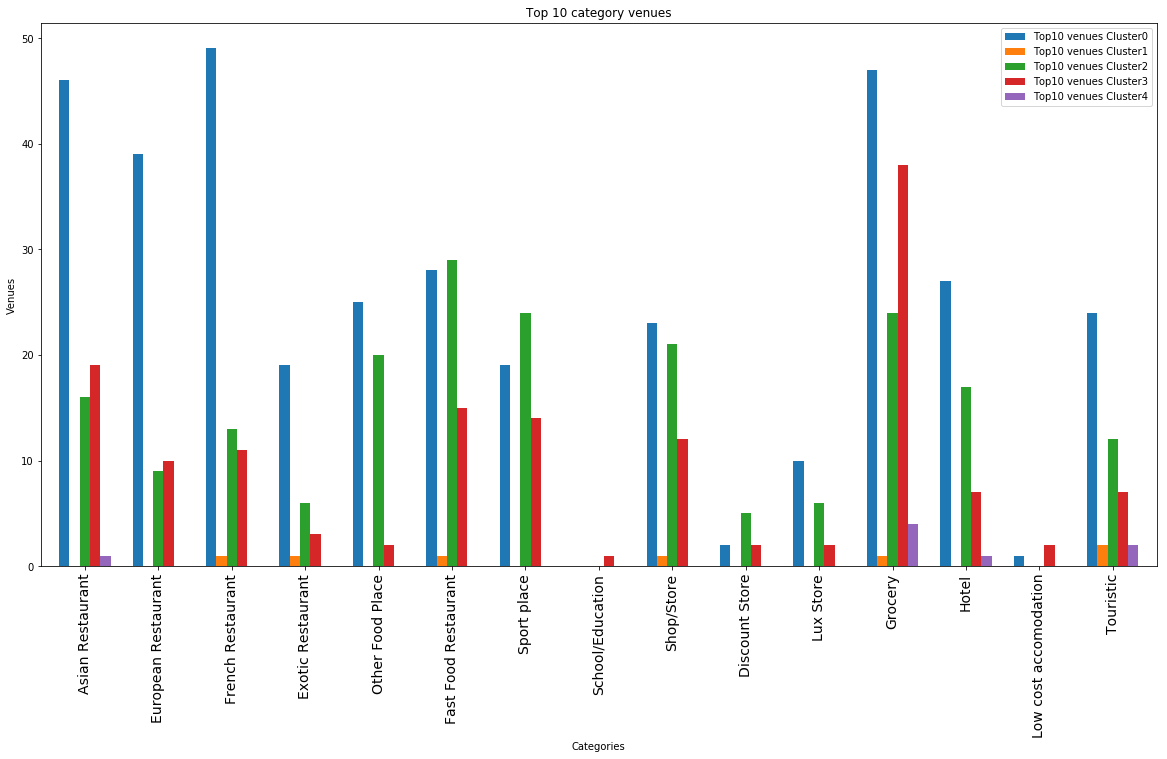

In [199]:
from matplotlib import pyplot as plt

ax = df_paris_analysis.loc[:'Touristic',:].plot.bar(figsize=(20, 10), width=0.7, rot=0)
ax.set_ylabel('Venues')
#ax.set_ylim(0, 0.3)
ax.set_title('Top 10 category venues')
plt.xticks(fontsize=14, rotation=90);

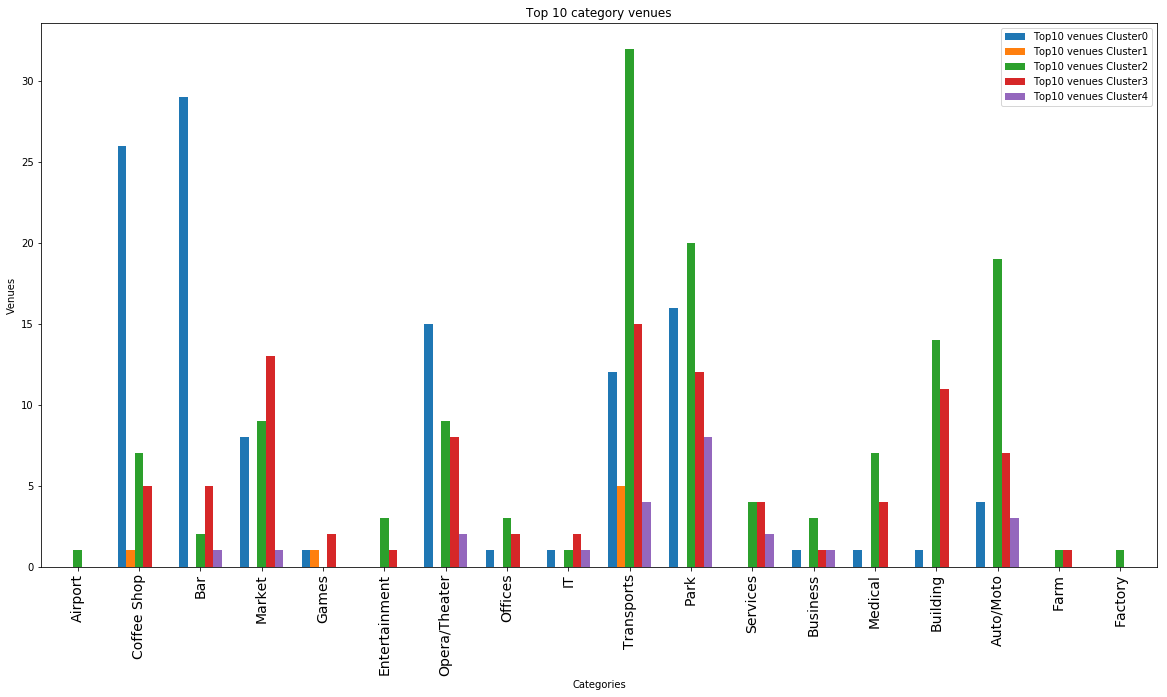

In [100]:
ax = df_paris_analysis.loc['Airport':,:].plot.bar(figsize=(20, 10), width=0.7, rot=0)
ax.set_ylabel('Venues')
#ax.set_ylim(0, 0.3)
ax.set_title('Top 10 category venues')
plt.xticks(fontsize=14, rotation=90);

# Rome Analysis

### Get the Rome venues for each neighborhood (the radius for the research is the half of the distance of each neighborhoods with its closest one)

In [284]:
def getNearbyVenueRoma(boroughs, names, latitudes, longitudes):
    
    venues_list=[]
    for borough,  name, lat, lng in zip(boroughs, names, latitudes, longitudes):
            
        dist=[]
        
        for borough2,  name2, lat2, lng2 in zip(boroughs, names, latitudes, longitudes):
            R = 6371e3 # metres
            dlng = (lng2 - lng)*np.pi/180
            dlat = (lat2 - lat)*np.pi/180
            a = (np.sin(dlat/2))**2 + np.cos(lat*np.pi/180) * np.cos(lat2*np.pi/180) * (np.sin(dlng/2))**2
            c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a) )
            d = R * c #(where R is the radius of the Earth)
                
                #R = 6371e3 # metres
                #phi1 = lat * np.pi/180 # φ, λ in radians
                #phi2 = lat2 * np.pi/180
                #Delta_phi = (lat2-lat) * np.pi/180
                #Delta_lambda = (lng2-lng) * np.pi/180
                #d = np.arccos(np.sin(phi1)*np.sin(phi2) + np.cos(phi1)*np.cos(phi2) * np.cos(Delta_lambda)) * R
            if d!=0:
                dist.append(d)
            else:
                continue
            
        
        min_dist=np.amin(dist)
        radius=int(min_dist/2.)
        
        print(name, radius)
        
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            borough,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough','Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [285]:
Roma_venues = getNearbyVenueRoma(boroughs=df_Roma['Borough'], names=df_Roma['Neighborhood'],
                                   latitudes=df_Roma['Latitude'],
                                   longitudes=df_Roma['Longitude']
                                  )

Centro Storico 673
Trastevere 731
Aventino 476
Testaccio 476
Esquilino 529
XX Settembre 457
Celio 406
Zona Archeologica 406
Prati 676
Della Vittoria 109
Eroi 605
Villaggio Olimpico 470
Parioli 577
Flaminio 470
Salario 457
Trieste 596
Villa Borghese 618
Villa Ada 596
Nomentano 577
San Lorenzo 446
Università 446
Verano 415
Monte Sacro 226
Val Melaina 432
Monte Sacro Alto 678
Fidene 710
Serpentara 821
Casal Boccone 412
Conca d'Oro 226
Sacco Pastore 367
Tufello 290
Aeroporto dell' Urbe 838
Settebagni 1574
Bufalotta 412
Tor San Giovanni 1129
Casal Bertone 415
Casal Bruciato 547
Tiburtino Nord 393
Tiburtino Sud 448
San Basilio 1105
Tor Cervara 862
Pietralata 393
Casal de' Pazzi 862
Sant'Alessandro 1129
Settecamini 1290
Torpignattara 410
Casilino 410
Quadraro 407
Gordiani 579
Centocelle 501
Alessandrina 501
Tor Sapienza 558
La Rustica 794
Tor Tre Teste 535
Casetta Mistica 653
Centro Direzionale Centocelle 569
Omo 535
Torrespaccata 778
Torre Maura 427
Giardinetti-Tor Vergata 910
Acqua Vergine 

In [286]:
print(Roma_venues.shape)
Roma_venues.head()

(2524, 8)


,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Municipio Roma I,Centro Storico,41.899,12.4766,Pantheon,41.899133,12.476805,Monument / Landmark
1,Municipio Roma I,Centro Storico,41.899,12.4766,Piazza della Rotonda,41.899253,12.476779,Plaza
2,Municipio Roma I,Centro Storico,41.899,12.4766,Bartolucci,41.899820,12.478812,Toy / Game Store
3,Municipio Roma I,Centro Storico,41.899,12.4766,Antica Salumeria,41.899209,12.476511,Sandwich Place
4,Municipio Roma I,Centro Storico,41.899,12.4766,Il Panino Ingegnoso,41.899982,12.479195,Sandwich Place


In [105]:
Roma_venues_old=Roma_venues

In [287]:
#Roma_venues=Roma_venues_old
Roma_venues['Venue Category'].unique()

array(['Monument / Landmark', 'Plaza', 'Toy / Game Store',
       'Sandwich Place', 'Church', 'Hotel', 'Fountain', 'Ice Cream Shop',
       'Italian Restaurant', 'Pizza Place', 'Coffee Shop', 'Lounge',
       'Restaurant', 'Seafood Restaurant', 'Argentinian Restaurant',
       'Art Museum', 'Wine Bar', 'Dessert Shop', 'Historic Site',
       'Roman Restaurant', 'Museum', 'Bookstore', 'Pie Shop', 'Bakery',
       'Abruzzo Restaurant', 'Fondue Restaurant', 'Boutique',
       'Cocktail Bar', 'Gourmet Shop', 'Café', 'Food & Drink Shop',
       'Diner', 'Trattoria/Osteria', 'Bistro', 'Deli / Bodega',
       'Breakfast Spot', 'Resort', 'Other Nightlife', 'Beer Bar',
       'Scenic Lookout', 'Bar', 'Wine Shop', 'Park',
       'Gluten-free Restaurant', 'Brewery', 'Pub', 'History Museum',
       'Bed & Breakfast', 'Burger Joint', 'Supermarket', 'Gastropub',
       'Greek Restaurant', 'Garden', 'Food Court', 'Theater',
       'Japanese Restaurant', 'American Restaurant', 'Chinese Restaurant',
  

In [288]:
Roma_venues_1=Roma_venues['Venue Category']
Roma_venues['Venue Category']=Roma_venues['Venue Category'].replace(to_replace=['Noodle House','Soba Restaurant','Indonesian Restaurant','Cantonese Restaurant','Cambodian Restaurant','Jiangxi Restaurant','Okonomiyaki Restaurant','Deli / Bodega','Indian Restaurant','Taiwanese Restaurant','Chinese Restaurant','Japanese Restaurant','Thai Restaurant','Ramen Restaurant','Sushi Restaurant','Dumpling Restaurant','Filipino Restaurant','Vietnamese Restaurant','Korean Restaurant','Dim Sum Restaurant','Asian Restaurant']
                            ,value ="Asian Restaurant").replace(to_replace=['Sicilian Restaurant','Abruzzo Restaurant','Austrian Restaurant','Roman Restaurant','Spanish Restaurant','English Restaurant','Eastern European Restaurant','Russian Restaurant','Trattoria/Osteria','Italian Restaurant','Modern European Restaurant','Portuguese Restaurant','German Restaurant','Belgian Restaurant','Greek Restaurant','Restaurant','Italian Restaurant','Scandinavian Restaurant']
                            ,value ="European Restaurant").replace(to_replace=['Fondue Restaurant', 'Alsatian Restaurant','Auvergne Restaurant','Southwestern French Restaurant','Cajun / Creole Restaurant','Savoyard Restaurant','Basque Restaurant','Creperie','Breton Restaurant','Brasserie','Bistro','Corsican Restaurant', 'Provençal Restaurant','French Restaurant']
                            ,value ="French Restaurant").replace(to_replace=['Cuban Restaurant','African Restaurant','Arepa Restaurant','Burrito Place','Southern / Soul Food Restaurant','Halal Restaurant','Caribbean Restaurant','Hawaiian Restaurant','New American Restaurant','American Restaurant','South American Restaurant','Argentinian Restaurant','Colombian Restaurant','Mexican Restaurant','Latin American Restaurant','Brazilian Restaurant', 'Peruvian Restaurant','Moroccan Restaurant','Ethiopian Restaurant', 'Midle East Restaurant','Persian Restaurant','Lebanese Restaurant','Turkish Restaurant','Middle Eastern Restaurant','Falafel Restaurant','Afghan Restaurant', 'Israeli Restaurant']
                            ,value ="Exotic Restaurant").replace(to_replace=['Paella Restaurant','Buffet','Gastropub','Comfort Food Restaurant','Diner','Breakfast Spot','Steakhouse','Soup Place','Sandwich Place','Salad Place','Fried Chicken Joint','Food Court','Theme Restaurant','Molecular Gastronomy Restaurant','Mediterranean Restaurant','Seafood Restaurant','Vegetarian / Vegan Restaurant','Gluten-free Restaurant']
                            ,value="Other Food Place").replace(to_replace=['Mac & Cheese Joint','Friterie','Street Food Gathering', 'Piadineria','Burger Joint','Kebab Restaurant','Tapas Restaurant','BBQ Joint','Taco Place', 'Food Truck','Pizza Place','Snack Place','Doner Restaurant','Fast Food Restaurant',]
                            ,value="Fast Food Restaurant").replace(to_replace=['Gun Range','Rock Climbing Spot','Swim School','Outdoors & Recreation','Athletics & Sports','Racetrack','Trail','Pool Hall','Dive Spot','Indoor Play Area','Football Stadium','Hockey Arena','Martial Arts Dojo','Rugby Stadium', 'Rugby Pitch','Basketball Stadium','Golf Course','Track Stadium', 'Basketball Court','Tennis Stadium','Tennis Court','Soccer Stadium','Racecourse','Boxing Gym','Stadium','Cycle Studio','Climbing Gym','Yoga Studio','Soccer Field','Pool','Sports Club','Gym','Gym Pool',' Athletics & Sports','Basketball Stadium', 'Baseball Stadium', 'Gym / Fitness Center', 'Dance Studio']
                            ,value="Sport place").replace(to_replace=['Music School','College Academic Building','University','College Arts Building','College Gym', 'College Rec Center']
                            ,value="School/Education").replace(to_replace=['Lighting Store','Clothing Store', '"Mens Store"',"Women's Store", "Men's Store",'Library','Paper / Office Supplies Store','Music Store','Newsstand','Print Shop','Shop & Service','Photography Studio','Shoe Store','Locksmith','Flower Shop','Smoke Shop','Board Shop','Kids Store','Optical Shop','Sporting Goods Shop','Big Box Store','Mobile Phone Shop','Candy Store','Pop-Up Shop','Souvlaki Shop','Souvenir Shop','Adult Boutique','Chocolate Shop','Comic Shop','Hobby Shop','Miscellaneous Shop','Record Shop','Shopping Mall','Smoke Shop','Sporting Goods Shop','Electronics Store', 'Toy / Game Store','Video Game Store','Baby Store','Bookstore','Camera Store','Pet Store']
                            ,value="Shop/Store").replace(to_replace=['Warehouse Store','Discount Store','Gift Shop','Convenience Store','Thrift / Vintage Store']
                            ,value="Discount Store").replace(to_replace=['Outlet Store','Shopping Plaza','Perfume Shop','Boutique', 'Antique Shop','Cosmetics Shop','Gourmet Shop','Tailor Shop','Accessories Store','Arts & Crafts Store','Department Store','Jewelry Store','Lingerie Store','Liquor Store']
                            ,value="Lux Store").replace(to_replace =[ 'Pie Shop','Food','Winery','Frozen Yogurt Shop','Smoothie Shop','Ice Cream Shop','Donut Shop','Bagel Shop','Bubble Tea Shop','Cupcake Shop','Butcher','Food & Drink Shop', 'Fruit & Vegetable Store','Fish & Chips Shop','Vineyard','Health Food Store','Organic Grocery','Grocery Store', 'Bakery', 'Supermarket','Cheese Shop', 'Pastry Shop', 'Beer Store', 'Wine Shop']
                            ,value ="Grocery").replace(to_replace =['Hotel Pool','Hotel','Hotel Bar', 'Lounge', 'Resort', 'Sauna / Steam Room', 'Spa','Hot Spring']
                            ,value ="Hotel").replace(to_replace =['Agriturismo','Recreation Center','Vacation Rental','Boarding House','Residential Building (Apartment / Condo)','Motel','Hostel', 'Bed & Breakfast','Campground']
                            ,value ="Low cost accomodation").replace(to_replace =['Public Art','Tour Provider','Lighthouse','Temple','Tourist Information Center','Outdoor Sculpture','Street Art','Arcade','Castle','Science Museum','Event Space','Fountain','Planetarium','Performing Arts Venue','Scenic Lookout','Cultural Center','Museum','Bridge','Church','Exhibit','Pedestrian Plaza', 'Plaza','Art Gallery','Art Museum','Monument / Landmark','History Museum','Performing Arts Venue','Sculpture Garden', 'Canal', 'Historic Site']
                            ,value ="Touristic").replace(to_replace =['Airport Lounge', 'Airport Terminal','Airport Food Court','Airport Gate','Airport Service']
                            ,value ="Airport").replace(to_replace =['College Cafeteria','Pet Café','Cafeteria',"Café","Dessert Shop", "Tea Room", 'Gaming Cafe']
                            ,value ="Coffee Shop").replace(to_replace =['Dive Bar','Piano Bar','Other Nightlife','Juice Bar','Sports Bar','Karaoke Bar','Brewery','Hookah Bar','Whisky Bar','Wine Bar','Pub','Beer Bar' ,'Irish Pub','Cocktail Bar', 'Speakeasy', 'Roof Deck', 'Beer Garden', 'Nightclub']
                            ,value ="Bar").replace(to_replace =['Night Market','Christmas Market','Flea Market','Farmers Market','Fish Market','Market']
                            ,value ="Market").replace(to_replace =['Paintball Field','Skating Rink','Skate Park','Bowling Alley','Laser Tag']
                            ,value ="Games").replace(to_replace =['Casino','Theme Park','Convention Center','Circus','Theme Park Ride / Attraction','Drive-in Theater', 'Rock Club', 'Multiplex']
                            ,value ="Entertainment").replace(to_replace =['Arts & Entertainment','Auditorium','Movie Theater','College Theater','Jazz Club', 'General Entertainment','Indie Movie Theater', 'Concert Hall', 'Comedy Club', 'Theater', 'Opera House', 'Music Venue', 'Movie Theater']
                            ,value ="Opera/Theater").replace(to_replace =['Design Studio','Insurance Office','Film Studio','Event Service','Recording Studio','Radio Station','City Hall','Real Estate Office',  'Non-Profit','Office', 'Transportation Service']
                            ,value ="Offices").replace(to_replace =['IT Services', 'Coworking Space','Hardware Store','Tech Startup']
                            ,value ="IT").replace(to_replace =['Toll Booth','Train','Toll Plaza','Rest Area','Platform','Road','Tunnel','Harbor / Marina','Bus Line','Boat or Ferry', 'Intersection','Light Rail Station','Metro Station','Bus Stop','Bus Station','Tram Station','Train Station','Bike Rental / Bike Share']
                            ,value ="Transports").replace(to_replace =['Field','Dog Run','Beach','Tree','Canal Lock','River','Cemetery','Park','State / Provincial Park','Garden Center','Lake', 'National Park','Aquarium','Track', 'Forest','Botanical Garden', 'Garden','Zoo', 'Playground', 'Poke Place', 'Zoo Exhibit']
                            ,value ="Park").replace(to_replace =['Fire Station','Courthouse','Spiritual Center','Tattoo Parlor','Photography Lab','Massage Studio','Funeral Home','Daycare','Laundromat','Salon / Barbershop','Health & Beauty Service']
                            ,value ="Services").replace(to_replace =['Lawyer','Financial or Legal Service','Bank','Business Service']
                            ,value ="Business").replace(to_replace =["Doctor's Office",'Medical Supply Store','Pharmacy']
                            ,value ="Medical").replace(to_replace =['Neighborhood','Home Service', 'Building','Construction & Landscaping', 'Furniture / Home Store']
                            ,value ="Building").replace(to_replace =['Car Wash','Gas Station','Auto Dealership','Auto Garage','Rental Service','Rental Car Location','Auto Workshop','Other Repair Shop', 'Automotive Shop','Motorcycle Shop']
                            ,value ="Auto/Moto").replace(to_replace =['Factory', 'Recycling Facility']
                            ,value ="Factory").replace(to_replace =['Farm','Stables']
                            ,value ="Farm")

In [289]:
Roma_venues['Venue Category'].unique()

array(['Touristic', 'Shop/Store', 'Other Food Place', 'Hotel', 'Grocery',
       'European Restaurant', 'Fast Food Restaurant', 'Coffee Shop',
       'Exotic Restaurant', 'Bar', 'French Restaurant', 'Lux Store',
       'Asian Restaurant', 'Park', 'Low cost accomodation',
       'Opera/Theater', 'Market', 'Transports', 'Building', 'Sport place',
       'Discount Store', 'Offices', 'Services', 'Games',
       'School/Education', 'Entertainment', 'IT', 'Farm', 'Airport',
       'Business', 'Medical', 'Auto/Moto'], dtype=object)

In [290]:
Roma_venues.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Municipio Roma I,Centro Storico,41.899,12.4766,Pantheon,41.899133,12.476805,Touristic
1,Municipio Roma I,Centro Storico,41.899,12.4766,Piazza della Rotonda,41.899253,12.476779,Touristic
2,Municipio Roma I,Centro Storico,41.899,12.4766,Bartolucci,41.899820,12.478812,Shop/Store
3,Municipio Roma I,Centro Storico,41.899,12.4766,Antica Salumeria,41.899209,12.476511,Other Food Place
4,Municipio Roma I,Centro Storico,41.899,12.4766,Il Panino Ingegnoso,41.899982,12.479195,Other Food Place


### Get the top10 venues for each Rome neighborhood

In [291]:
# one hot encoding
Roma_onehot = pd.get_dummies(Roma_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Roma_onehot['Neighborhood'] = Roma_venues['Neighborhood'] 
#print(Roma_onehot)

# move neighborhood column to the first column
fixed_columns = [Roma_onehot.columns[-1]] + list(Roma_onehot.columns[:-1])
Roma_onehot = Roma_onehot[fixed_columns]

Roma_grouped = Roma_onehot.groupby('Neighborhood').mean().reset_index()
Roma_grouped.set_index('Neighborhood').loc[:,'Entertainment':]

,Entertainment,European Restaurant,Exotic Restaurant,Farm,Fast Food Restaurant,French Restaurant,Games,Grocery,Hotel,IT,...,Offices,Opera/Theater,Other Food Place,Park,School/Education,Services,Shop/Store,Sport place,Touristic,Transports
Neighborhood,,,,,,,,,,,,,,,,,,,,,
Acilia Nord,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.333333,0.000000
Acilia Sud,0.000000,0.142857,0.000000,0.000000,0.071429,0.000000,0.000000,0.214286,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.214286,0.071429,0.071429,0.000000
Acqua Vergine,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.500000,0.000000,0.000000,0.250000
Acquatraversa,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.250000,0.000000,...,0.000000,0.000000,0.000000,0.250000,0.0,0.000000,0.000000,0.250000,0.000000,0.000000
Aeroporto dell' Urbe,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.500000,0.000000,0.250000
Alessandrina,0.000000,0.571429,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.142857,0.142857,0.000000,0.000000
Appia Antica Nord,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.250000,0.0,0.000000,0.000000,0.250000,0.000000,0.000000
Appia Antica Sud,0.000000,0.181818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.090909,0.000000,0.0,0.000000,0.000000,0.272727,0.090909,0.000000
Appio,0.000000,0.200000,0.000000,0.000000,0.155556,0.022222,0.000000,0.155556,0.022222,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.022222,0.066667,0.000000


In [292]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    row_venues=[]
    
    for i in range(num_top_venues):
        if row_categories_sorted[i]!=0.0:
            row_venues.append(row_categories_sorted.index.values[i])
        else: 
            row_venues.append('Void')
    
    #return row_categories_sorted.index.values[0:num_top_venues]
    return row_venues

In [293]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Roma_venues_sorted = pd.DataFrame(columns=columns)
Roma_venues_sorted['Neighborhood'] = Roma_grouped['Neighborhood']

for ind in np.arange(Roma_grouped.shape[0]):
    Roma_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Roma_grouped.iloc[ind, :], num_top_venues)

Roma_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Acilia Nord,Grocery,Touristic,Bar,Void,Void,Void,Void,Void,Void,Void
1,Acilia Sud,Grocery,Shop/Store,European Restaurant,Coffee Shop,Medical,Sport place,Touristic,Fast Food Restaurant,Void,Void
2,Acqua Vergine,Shop/Store,Transports,Fast Food Restaurant,Void,Void,Void,Void,Void,Void,Void
3,Acquatraversa,Sport place,Hotel,Park,Grocery,Coffee Shop,Void,Void,Void,Void,Void
4,Aeroporto dell' Urbe,Sport place,Transports,Airport,Void,Void,Void,Void,Void,Void,Void


## Clustering of Rome

### Study the inertia of the clusetring due to the variation of the number of clusters

In [294]:
from sklearn.cluster import KMeans
# define the dataframe columns
Roma_Inertia_Col = ['ClusterNumber', 'Inertia'] 

# instantiate the dataframe
Roma_Inertia_Df = pd.DataFrame(columns=Roma_Inertia_Col)

Roma_grouped_clustering = Roma_grouped.drop('Neighborhood', 1)
for k in range (1, 15):
    # Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
    Roma_kmeans_model = KMeans(n_clusters=k, random_state=1, init='k-means++', n_init=10, max_iter=300, tol=0.0001,).fit(Roma_grouped_clustering)
    # Sum of distances of samples to their closest cluster center
    Roma_inertia = Roma_kmeans_model.inertia_
    
    Roma_Inertia_Df = Roma_Inertia_Df.append({'ClusterNumber': k,
                                          'Inertia': Roma_inertia,
                                                     }, ignore_index=True)

In [295]:
Roma_Inertia_Df=Roma_Inertia_Df.set_index("ClusterNumber")

In [296]:
from sklearn import preprocessing
x = Roma_Inertia_Df[['Inertia']].values.astype(float)

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# Run the normalizer on the dataframe
#Roma_Inertia_Df[['Inertia']] = pd.DataFrame(x_scaled)
Roma_Inertia_Df[['Inertia']] = pd.DataFrame(x)

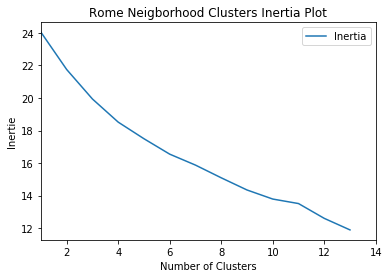

In [297]:
from matplotlib import pyplot as plt

# Plotting the results
Roma_Inertia_Df.index = Roma_Inertia_Df.index.map(int)
Roma_Inertia_Df.plot(kind='line')

plt.title('Rome Neigborhood Clusters Inertia Plot')
plt.ylabel('Inertie')
plt.xlabel('Number of Clusters')

plt.show()

In [298]:
# set number of clusters
kclusters = 6

Roma_grouped_clustering = Roma_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Roma_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 3, 2, 1, 4, 4, 4, 2, 1], dtype=int32)

In [299]:
# add clustering labels
Roma_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Roma_merged = df_Roma

# merge paris_grouped with paris_data to add latitude/longitude for each neighborhood
Roma_merged =Roma_merged.join(Roma_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
Roma_merged.dropna(axis=0, inplace=True)
Roma_merged = Roma_merged.astype({'Cluster Labels':'int32'})
Roma_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Municipio Roma I,Centro Storico,41.899000,12.476600,4,Touristic,European Restaurant,Hotel,Other Food Place,Grocery,Coffee Shop,Fast Food Restaurant,Bar,Shop/Store,Lux Store
1,Municipio Roma I,Trastevere,41.887222,12.465556,4,European Restaurant,Bar,Grocery,Touristic,Fast Food Restaurant,Other Food Place,Hotel,Coffee Shop,Park,Opera/Theater
2,Municipio Roma I,Aventino,41.880100,12.485200,4,European Restaurant,Other Food Place,Coffee Shop,Bar,Grocery,Asian Restaurant,Hotel,Park,Exotic Restaurant,Touristic
3,Municipio Roma I,Testaccio,41.876111,12.475000,4,European Restaurant,Touristic,Other Food Place,Bar,Coffee Shop,Market,Opera/Theater,Fast Food Restaurant,Hotel,Lux Store
4,Municipio Roma I,Esquilino,41.893056,12.503889,2,European Restaurant,Hotel,Asian Restaurant,Coffee Shop,Low cost accomodation,Grocery,Touristic,Exotic Restaurant,Market,Fast Food Restaurant


In [300]:
# create map
map_romeclusters = folium.Map(location=[latitude_rome, longitude_rome], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, bor,  poi, cluster in zip(Roma_merged['Latitude'], Roma_merged['Longitude'], Roma_merged['Borough'], Roma_merged['Neighborhood'], Roma_merged['Cluster Labels']):
    label = folium.Popup(str(bor)+' - '+ str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_romeclusters)
       
map_romeclusters

In [210]:
df_roma_cluster0=Roma_merged.loc[Roma_merged['Cluster Labels'] == 0, Roma_merged.columns[[1]+[4] + list(range(5, Roma_merged.shape[1]))]]
df_roma_cluster0

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Villaggio Olimpico,0,Grocery,Bar,European Restaurant,Opera/Theater,Other Food Place,Games,Shop/Store,Void,Void,Void
18,Nomentano,0,Grocery,Hotel,Asian Restaurant,European Restaurant,Bar,Other Food Place,Touristic,Coffee Shop,Opera/Theater,Exotic Restaurant
21,Verano,0,Grocery,Void,Void,Void,Void,Void,Void,Void,Void,Void
23,Val Melaina,0,Grocery,Shop/Store,Bar,Other Food Place,Offices,Void,Void,Void,Void,Void
25,Fidene,0,Grocery,European Restaurant,Hotel,Coffee Shop,Fast Food Restaurant,Touristic,Transports,Void,Void,Void
28,Conca d'Oro,0,Grocery,Market,Touristic,Asian Restaurant,Void,Void,Void,Void,Void,Void
35,Casal Bertone,0,Other Food Place,Touristic,Grocery,Hotel,Opera/Theater,Coffee Shop,Bar,Void,Void,Void
36,Casal Bruciato,0,Grocery,Coffee Shop,Fast Food Restaurant,Opera/Theater,Sport place,Touristic,Void,Void,Void,Void
41,Pietralata,0,Transports,Park,Hotel,Grocery,Void,Void,Void,Void,Void,Void
45,Torpignattara,0,Grocery,Touristic,Transports,Fast Food Restaurant,Other Food Place,Opera/Theater,Discount Store,European Restaurant,Exotic Restaurant,Void


In [211]:
df_roma_cluster1=Roma_merged.loc[Roma_merged['Cluster Labels'] == 1, Roma_merged.columns[[1]+[4] + list(range(5, Roma_merged.shape[1]))]]
df_roma_cluster1

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Della Vittoria,1,Sport place,Bar,Void,Void,Void,Void,Void,Void,Void,Void
31,Aeroporto dell' Urbe,1,Sport place,Transports,Airport,Void,Void,Void,Void,Void,Void,Void
46,Casilino,1,Sport place,Touristic,European Restaurant,Void,Void,Void,Void,Void,Void,Void
67,Tor Fiscale,1,Sport place,Void,Void,Void,Void,Void,Void,Void,Void,Void
71,Appio-Claudio,1,Sport place,Void,Void,Void,Void,Void,Void,Void,Void,Void
112,Castel Porziano,1,Sport place,Other Food Place,Void,Void,Void,Void,Void,Void,Void,Void
115,Pian Due Torri,1,Sport place,Coffee Shop,European Restaurant,Void,Void,Void,Void,Void,Void,Void
145,Grotta Rossa Ovest,1,Sport place,Hotel,Void,Void,Void,Void,Void,Void,Void,Void
154,Foro Italico,1,Touristic,Sport place,Void,Void,Void,Void,Void,Void,Void,Void


In [212]:
df_roma_cluster2=Roma_merged.loc[Roma_merged['Cluster Labels'] == 2, Roma_merged.columns[[1]+[4] + list(range(5, Roma_merged.shape[1]))]]
df_roma_cluster2

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Esquilino,2,European Restaurant,Hotel,Asian Restaurant,Coffee Shop,Low cost accomodation,Grocery,Touristic,Exotic Restaurant,Market,Fast Food Restaurant
7,Zona Archeologica,2,Touristic,Coffee Shop,Hotel,European Restaurant,Bar,Market,Grocery,Park,Shop/Store,Void
12,Parioli,2,European Restaurant,Other Food Place,Coffee Shop,Fast Food Restaurant,Touristic,Hotel,Sport place,Shop/Store,School/Education,Opera/Theater
13,Flaminio,2,European Restaurant,Sport place,Other Food Place,Coffee Shop,Fast Food Restaurant,Shop/Store,Touristic,Hotel,French Restaurant,Bar
14,Salario,2,European Restaurant,Coffee Shop,Asian Restaurant,Other Food Place,Bar,Grocery,Touristic,Exotic Restaurant,Fast Food Restaurant,Discount Store
15,Trieste,2,Coffee Shop,Grocery,Fast Food Restaurant,Touristic,Other Food Place,Bar,European Restaurant,Asian Restaurant,Opera/Theater,Shop/Store
17,Villa Ada,2,Park,Opera/Theater,Bar,Void,Void,Void,Void,Void,Void,Void
20,Università,2,European Restaurant,Coffee Shop,Fast Food Restaurant,Transports,Low cost accomodation,Bar,French Restaurant,Hotel,Grocery,Park
22,Monte Sacro,2,Asian Restaurant,Other Food Place,Touristic,Void,Void,Void,Void,Void,Void,Void
32,Settebagni,2,Transports,Sport place,Coffee Shop,European Restaurant,Other Food Place,Low cost accomodation,Bar,Building,Fast Food Restaurant,Grocery


In [213]:
df_roma_cluster3=Roma_merged.loc[Roma_merged['Cluster Labels'] == 3, Roma_merged.columns[[1]+[4] + list(range(5, Roma_merged.shape[1]))]]
df_roma_cluster3

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,Serpentara,3,Shop/Store,Lux Store,European Restaurant,Coffee Shop,Fast Food Restaurant,Other Food Place,Transports,Bar,Grocery,Asian Restaurant
33,Bufalotta,3,Shop/Store,Grocery,Other Food Place,IT,Fast Food Restaurant,Sport place,Void,Void,Void,Void
54,Casetta Mistica,3,Shop/Store,Hotel,Farm,Void,Void,Void,Void,Void,Void,Void
56,Omo,3,Shop/Store,Void,Void,Void,Void,Void,Void,Void,Void,Void
58,Torre Maura,3,Shop/Store,Coffee Shop,Grocery,Fast Food Restaurant,Void,Void,Void,Void,Void,Void
59,Giardinetti-Tor Vergata,3,Sport place,Shop/Store,Fast Food Restaurant,Coffee Shop,Void,Void,Void,Void,Void,Void
60,Acqua Vergine,3,Shop/Store,Transports,Fast Food Restaurant,Void,Void,Void,Void,Void,Void,Void
77,Gregna,3,Shop/Store,Hotel,Fast Food Restaurant,Sport place,Bar,Void,Void,Void,Void,Void
100,Castel Romano,3,Shop/Store,Fast Food Restaurant,Lux Store,Other Food Place,Coffee Shop,European Restaurant,Entertainment,Grocery,Asian Restaurant,Void


In [214]:
df_roma_cluster4=Roma_merged.loc[Roma_merged['Cluster Labels'] == 4, Roma_merged.columns[[1]+[4] + list(range(5, Roma_merged.shape[1]))]]
df_roma_cluster4

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Centro Storico,4,Touristic,European Restaurant,Hotel,Other Food Place,Grocery,Coffee Shop,Fast Food Restaurant,Bar,Shop/Store,Lux Store
1,Trastevere,4,European Restaurant,Bar,Grocery,Touristic,Fast Food Restaurant,Other Food Place,Hotel,Coffee Shop,Park,Opera/Theater
2,Aventino,4,European Restaurant,Other Food Place,Coffee Shop,Bar,Grocery,Asian Restaurant,Hotel,Park,Exotic Restaurant,Touristic
3,Testaccio,4,European Restaurant,Touristic,Other Food Place,Bar,Coffee Shop,Market,Opera/Theater,Fast Food Restaurant,Hotel,Lux Store
5,XX Settembre,4,European Restaurant,Hotel,Touristic,Grocery,Fast Food Restaurant,Low cost accomodation,Other Food Place,Coffee Shop,Bar,Asian Restaurant
6,Celio,4,European Restaurant,Bar,Hotel,Touristic,Coffee Shop,Other Food Place,Grocery,Low cost accomodation,Discount Store,Fast Food Restaurant
8,Prati,4,European Restaurant,Grocery,Hotel,Other Food Place,Bar,Coffee Shop,Touristic,Asian Restaurant,Low cost accomodation,Fast Food Restaurant
10,Eroi,4,European Restaurant,Coffee Shop,Grocery,Asian Restaurant,Touristic,Hotel,Other Food Place,Fast Food Restaurant,Bar,Lux Store
16,Villa Borghese,4,Touristic,Park,European Restaurant,Hotel,Sport place,Bar,Opera/Theater,Grocery,Coffee Shop,French Restaurant
19,San Lorenzo,4,European Restaurant,Bar,Fast Food Restaurant,Coffee Shop,Other Food Place,Hotel,Opera/Theater,Grocery,Park,Lux Store


In [215]:
df_roma_cluster5=Roma_merged.loc[Roma_merged['Cluster Labels'] == 5, Roma_merged.columns[[1]+[4] + list(range(5, Roma_merged.shape[1]))]]
df_roma_cluster5

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,Monte Sacro Alto,5,Shop/Store,Fast Food Restaurant,Coffee Shop,Asian Restaurant,Other Food Place,Discount Store,Lux Store,European Restaurant,Touristic,Grocery
27,Casal Boccone,5,Sport place,Farm,Fast Food Restaurant,Void,Void,Void,Void,Void,Void,Void
29,Sacco Pastore,5,Fast Food Restaurant,Bar,Hotel,European Restaurant,Coffee Shop,Other Food Place,Market,Entertainment,Shop/Store,Exotic Restaurant
37,Tiburtino Nord,5,Transports,Park,Coffee Shop,Fast Food Restaurant,Void,Void,Void,Void,Void,Void
42,Casal de' Pazzi,5,Hotel,Fast Food Restaurant,Grocery,Transports,Sport place,Asian Restaurant,Touristic,Void,Void,Void
52,La Rustica,5,Transports,Hotel,Shop/Store,Auto/Moto,Fast Food Restaurant,European Restaurant,Void,Void,Void,Void
53,Tor Tre Teste,5,Hotel,Coffee Shop,Shop/Store,Fast Food Restaurant,Void,Void,Void,Void,Void,Void
62,Torre Angela,5,Transports,Shop/Store,European Restaurant,Opera/Theater,Sport place,Fast Food Restaurant,Void,Void,Void,Void
63,Borghesiana,5,Grocery,Sport place,Fast Food Restaurant,Shop/Store,Other Food Place,Coffee Shop,Void,Void,Void,Void
66,Tuscolano Sud,5,Fast Food Restaurant,Grocery,Asian Restaurant,Bar,Other Food Place,European Restaurant,Sport place,Coffee Shop,Park,Hotel


In [216]:
cluster0_top5_roma_venues=np.concatenate([df_roma_cluster0['1st Most Common Venue'].unique(), df_roma_cluster0['2nd Most Common Venue'].unique(), df_roma_cluster0['3rd Most Common Venue'].unique(), df_roma_cluster0['4th Most Common Venue'].unique(), df_roma_cluster0['5th Most Common Venue'].unique()])
#print('Cluster 0: Top 5 venues',cluster0_top5_roma_venues)

cluster0_top10_roma_venues=np.concatenate([df_roma_cluster0['1st Most Common Venue'].unique(), df_roma_cluster0['2nd Most Common Venue'].unique(), df_roma_cluster0['3rd Most Common Venue'].unique(), df_roma_cluster0['4th Most Common Venue'].unique(), df_roma_cluster0['5th Most Common Venue'].unique(), df_roma_cluster0['6th Most Common Venue'].unique(), df_roma_cluster0['7th Most Common Venue'].unique(), df_roma_cluster0['8th Most Common Venue'].unique(), df_roma_cluster0['9th Most Common Venue'].unique(), df_roma_cluster0['10th Most Common Venue'].unique()])
cluster0_top10_roma_venues=np.unique(cluster0_top10_roma_venues)
print('Cluster 0: Top 10 venues',cluster0_top10_roma_venues)

#cluster0_top15_roma_venues=np.concatenate([df_roma_cluster0['1st Most Common Venue'].unique(), df_roma_cluster0['2nd Most Common Venue'].unique(), df_roma_cluster0['3rd Most Common Venue'].unique(), df_roma_cluster0['4th Most Common Venue'].unique(), df_roma_cluster0['5th Most Common Venue'].unique(), df_roma_cluster0['6th Most Common Venue'].unique(), df_roma_cluster0['7th Most Common Venue'].unique(), df_roma_cluster0['8th Most Common Venue'].unique(), df_roma_cluster0['9th Most Common Venue'].unique(), df_roma_cluster0['10th Most Common Venue'].unique(), df_roma_cluster0['11th Most Common Venue'].unique(),df_roma_cluster0['12th Most Common Venue'].unique(),df_roma_cluster0['13th Most Common Venue'].unique(),df_roma_cluster0['14th Most Common Venue'].unique(),df_roma_cluster0['15th Most Common Venue'].unique()])
#cluster0_top15_roma_venues=np.unique(cluster0_top15_roma_venues)
#print('Cluster 0: Top 15 venues',cluster0_top15_roma_venues)

Cluster 0: Top 10 venues ['Asian Restaurant' 'Bar' 'Building' 'Business' 'Coffee Shop'
 'Discount Store' 'European Restaurant' 'Exotic Restaurant' 'Farm'
 'Fast Food Restaurant' 'Games' 'Grocery' 'Hotel' 'Low cost accomodation'
 'Lux Store' 'Market' 'Medical' 'Offices' 'Opera/Theater'
 'Other Food Place' 'Park' 'Services' 'Shop/Store' 'Sport place'
 'Touristic' 'Transports' 'Void']


In [217]:
cluster1_top5_roma_venues=np.concatenate([df_roma_cluster1['1st Most Common Venue'].unique(), df_roma_cluster1['2nd Most Common Venue'].unique(), df_roma_cluster1['3rd Most Common Venue'].unique(), df_roma_cluster1['4th Most Common Venue'].unique(), df_roma_cluster1['5th Most Common Venue'].unique()])
#print('Cluster 1: Top 5 venues',cluster1_top5_roma_venues)

cluster1_top10_roma_venues=np.concatenate([df_roma_cluster1['1st Most Common Venue'].unique(), df_roma_cluster1['2nd Most Common Venue'].unique(), df_roma_cluster1['3rd Most Common Venue'].unique(), df_roma_cluster1['4th Most Common Venue'].unique(), df_roma_cluster1['5th Most Common Venue'].unique(), df_roma_cluster1['6th Most Common Venue'].unique(), df_roma_cluster1['7th Most Common Venue'].unique(), df_roma_cluster1['8th Most Common Venue'].unique(), df_roma_cluster1['9th Most Common Venue'].unique(), df_roma_cluster1['10th Most Common Venue'].unique()])
cluster1_top10_roma_venues=np.unique(cluster1_top10_roma_venues)
print('Cluster 1: Top 10 venues',cluster1_top10_roma_venues)

#cluster1_top15_roma_venues=np.concatenate([df_roma_cluster1['1st Most Common Venue'].unique(), df_roma_cluster1['2nd Most Common Venue'].unique(), df_roma_cluster1['3rd Most Common Venue'].unique(), df_roma_cluster1['4th Most Common Venue'].unique(), df_roma_cluster1['5th Most Common Venue'].unique(), df_roma_cluster1['6th Most Common Venue'].unique(), df_roma_cluster1['7th Most Common Venue'].unique(), df_roma_cluster1['8th Most Common Venue'].unique(), df_roma_cluster1['9th Most Common Venue'].unique(), df_roma_cluster1['10th Most Common Venue'].unique(), df_roma_cluster1['11th Most Common Venue'].unique(),df_roma_cluster1['12th Most Common Venue'].unique(),df_roma_cluster1['13th Most Common Venue'].unique(),df_roma_cluster1['14th Most Common Venue'].unique(),df_roma_cluster1['15th Most Common Venue'].unique()])
#cluster1_top15_roma_venues=np.unique(cluster1_top15_roma_venues)
#print('Cluster 1: Top 15 venues',cluster1_top15_roma_venues)

Cluster 1: Top 10 venues ['Airport' 'Bar' 'Coffee Shop' 'European Restaurant' 'Hotel'
 'Other Food Place' 'Sport place' 'Touristic' 'Transports' 'Void']


In [218]:
cluster2_top5_roma_venues=np.concatenate([df_roma_cluster2['1st Most Common Venue'].unique(), df_roma_cluster2['2nd Most Common Venue'].unique(), df_roma_cluster2['3rd Most Common Venue'].unique(), df_roma_cluster2['4th Most Common Venue'].unique(), df_roma_cluster2['5th Most Common Venue'].unique()])
#print('Cluster 2: Top 5 venues',cluster2_top5_roma_venues)

cluster2_top10_roma_venues=np.concatenate([df_roma_cluster2['1st Most Common Venue'].unique(), df_roma_cluster2['2nd Most Common Venue'].unique(), df_roma_cluster2['3rd Most Common Venue'].unique(), df_roma_cluster2['4th Most Common Venue'].unique(), df_roma_cluster2['5th Most Common Venue'].unique(), df_roma_cluster2['6th Most Common Venue'].unique(), df_roma_cluster2['7th Most Common Venue'].unique(), df_roma_cluster2['8th Most Common Venue'].unique(), df_roma_cluster2['9th Most Common Venue'].unique(), df_roma_cluster2['10th Most Common Venue'].unique()])
cluster2_top10_roma_venues=np.unique(cluster2_top10_roma_venues)
print('Cluster 2: Top 10 venues',cluster2_top10_roma_venues)

#cluster2_top15_roma_venues=np.concatenate([df_roma_cluster2['1st Most Common Venue'].unique(), df_roma_cluster2['2nd Most Common Venue'].unique(), df_roma_cluster2['3rd Most Common Venue'].unique(), df_roma_cluster2['4th Most Common Venue'].unique(), df_roma_cluster2['5th Most Common Venue'].unique(), df_roma_cluster2['6th Most Common Venue'].unique(), df_roma_cluster2['7th Most Common Venue'].unique(), df_roma_cluster2['8th Most Common Venue'].unique(), df_roma_cluster2['9th Most Common Venue'].unique(), df_roma_cluster2['10th Most Common Venue'].unique(), df_roma_cluster2['11th Most Common Venue'].unique(),df_roma_cluster2['12th Most Common Venue'].unique(),df_roma_cluster2['13th Most Common Venue'].unique(),df_roma_cluster2['14th Most Common Venue'].unique(),df_roma_cluster2['15th Most Common Venue'].unique()])
#cluster2_top15_roma_venues=np.unique(cluster2_top15_roma_venues)
#print('Cluster 2: Top 15 venues',cluster2_top15_roma_venues)

Cluster 2: Top 10 venues ['Airport' 'Asian Restaurant' 'Auto/Moto' 'Bar' 'Building' 'Business'
 'Coffee Shop' 'Discount Store' 'Entertainment' 'European Restaurant'
 'Exotic Restaurant' 'Farm' 'Fast Food Restaurant' 'French Restaurant'
 'Grocery' 'Hotel' 'Low cost accomodation' 'Lux Store' 'Market' 'Medical'
 'Opera/Theater' 'Other Food Place' 'Park' 'School/Education' 'Shop/Store'
 'Sport place' 'Touristic' 'Transports' 'Void']


In [219]:
cluster3_top5_roma_venues=np.concatenate([df_roma_cluster3['1st Most Common Venue'].unique(), df_roma_cluster3['2nd Most Common Venue'].unique(), df_roma_cluster3['3rd Most Common Venue'].unique(), df_roma_cluster3['4th Most Common Venue'].unique(), df_roma_cluster3['5th Most Common Venue'].unique()])
#print('Cluster 3: Top 5 venues',cluster3_top5_roma_venues)

cluster3_top10_roma_venues=np.concatenate([df_roma_cluster3['1st Most Common Venue'].unique(), df_roma_cluster3['2nd Most Common Venue'].unique(), df_roma_cluster3['3rd Most Common Venue'].unique(), df_roma_cluster3['4th Most Common Venue'].unique(), df_roma_cluster3['5th Most Common Venue'].unique(), df_roma_cluster3['6th Most Common Venue'].unique(), df_roma_cluster3['7th Most Common Venue'].unique(), df_roma_cluster3['8th Most Common Venue'].unique(), df_roma_cluster3['9th Most Common Venue'].unique(), df_roma_cluster3['10th Most Common Venue'].unique()])
cluster3_top10_roma_venues=np.unique(cluster3_top10_roma_venues)
print('Cluster 3: Top 10 venues',cluster3_top10_roma_venues)

#cluster3_top15_roma_venues=np.concatenate([df_roma_cluster3['1st Most Common Venue'].unique(), df_roma_cluster3['2nd Most Common Venue'].unique(), df_roma_cluster3['3rd Most Common Venue'].unique(), df_roma_cluster3['4th Most Common Venue'].unique(), df_roma_cluster3['5th Most Common Venue'].unique(), df_roma_cluster3['6th Most Common Venue'].unique(), df_roma_cluster3['7th Most Common Venue'].unique(), df_roma_cluster3['8th Most Common Venue'].unique(), df_roma_cluster3['9th Most Common Venue'].unique(), df_roma_cluster3['10th Most Common Venue'].unique(), df_roma_cluster3['11th Most Common Venue'].unique(),df_roma_cluster3['12th Most Common Venue'].unique(),df_roma_cluster3['13th Most Common Venue'].unique(),df_roma_cluster3['14th Most Common Venue'].unique(),df_roma_cluster3['15th Most Common Venue'].unique()])
#cluster3_top15_roma_venues=np.unique(cluster3_top15_roma_venues)
#print('Cluster 3: Top 15 venues',cluster3_top15_roma_venues)

Cluster 3: Top 10 venues ['Asian Restaurant' 'Bar' 'Coffee Shop' 'Entertainment'
 'European Restaurant' 'Farm' 'Fast Food Restaurant' 'Grocery' 'Hotel'
 'IT' 'Lux Store' 'Other Food Place' 'Shop/Store' 'Sport place'
 'Transports' 'Void']


In [220]:
cluster4_top5_roma_venues=np.concatenate([df_roma_cluster4['1st Most Common Venue'].unique(), df_roma_cluster4['2nd Most Common Venue'].unique(), df_roma_cluster4['3rd Most Common Venue'].unique(), df_roma_cluster4['4th Most Common Venue'].unique(), df_roma_cluster4['5th Most Common Venue'].unique()])
#print('Cluster 4: Top 5 venues',cluster4_top5_roma_venues)

cluster4_top10_roma_venues=np.concatenate([df_roma_cluster4['1st Most Common Venue'].unique(), df_roma_cluster4['2nd Most Common Venue'].unique(), df_roma_cluster4['3rd Most Common Venue'].unique(), df_roma_cluster4['4th Most Common Venue'].unique(), df_roma_cluster4['5th Most Common Venue'].unique(), df_roma_cluster4['6th Most Common Venue'].unique(), df_roma_cluster4['7th Most Common Venue'].unique(), df_roma_cluster4['8th Most Common Venue'].unique(), df_roma_cluster4['9th Most Common Venue'].unique(), df_roma_cluster4['10th Most Common Venue'].unique()])
cluster4_top10_roma_venues=np.unique(cluster4_top10_roma_venues)
print('Cluster 4: Top 10 venues',cluster4_top10_roma_venues)


cluster5_top10_roma_venues=np.concatenate([df_roma_cluster5['1st Most Common Venue'].unique(), df_roma_cluster5['2nd Most Common Venue'].unique(), df_roma_cluster5['3rd Most Common Venue'].unique(), df_roma_cluster5['4th Most Common Venue'].unique(), df_roma_cluster5['5th Most Common Venue'].unique(), df_roma_cluster5['6th Most Common Venue'].unique(), df_roma_cluster5['7th Most Common Venue'].unique(), df_roma_cluster5['8th Most Common Venue'].unique(), df_roma_cluster5['9th Most Common Venue'].unique(), df_roma_cluster5['10th Most Common Venue'].unique()])
cluster5_top10_roma_venues=np.unique(cluster4_top10_roma_venues)
print('Cluster 5: Top 10 venues',cluster5_top10_roma_venues)

#cluster4_top15_roma_venues=np.concatenate([df_roma_cluster4['1st Most Common Venue'].unique(), df_roma_cluster4['2nd Most Common Venue'].unique(), df_roma_cluster4['3rd Most Common Venue'].unique(), df_roma_cluster4['4th Most Common Venue'].unique(), df_roma_cluster4['5th Most Common Venue'].unique(), df_roma_cluster4['6th Most Common Venue'].unique(), df_roma_cluster4['7th Most Common Venue'].unique(), df_roma_cluster4['8th Most Common Venue'].unique(), df_roma_cluster4['9th Most Common Venue'].unique(), df_roma_cluster4['10th Most Common Venue'].unique(), df_roma_cluster4['11th Most Common Venue'].unique(),df_roma_cluster4['12th Most Common Venue'].unique(),df_roma_cluster4['13th Most Common Venue'].unique(),df_roma_cluster4['14th Most Common Venue'].unique(),df_roma_cluster4['15th Most Common Venue'].unique()])
#cluster4_top15_roma_venues=np.unique(cluster4_top15_roma_venues)
#print('Cluster 4: Top 15 venues',cluster4_top15_roma_venues)

Cluster 4: Top 10 venues ['Asian Restaurant' 'Auto/Moto' 'Bar' 'Building' 'Coffee Shop'
 'Discount Store' 'Entertainment' 'European Restaurant'
 'Exotic Restaurant' 'Fast Food Restaurant' 'French Restaurant' 'Grocery'
 'Hotel' 'Low cost accomodation' 'Lux Store' 'Market' 'Medical' 'Offices'
 'Opera/Theater' 'Other Food Place' 'Park' 'Shop/Store' 'Sport place'
 'Touristic' 'Transports' 'Void']
Cluster 5: Top 10 venues ['Asian Restaurant' 'Auto/Moto' 'Bar' 'Building' 'Coffee Shop'
 'Discount Store' 'Entertainment' 'European Restaurant'
 'Exotic Restaurant' 'Fast Food Restaurant' 'French Restaurant' 'Grocery'
 'Hotel' 'Low cost accomodation' 'Lux Store' 'Market' 'Medical' 'Offices'
 'Opera/Theater' 'Other Food Place' 'Park' 'Shop/Store' 'Sport place'
 'Touristic' 'Transports' 'Void']


In [221]:
print('Cluster 0: Top 10 venues',cluster0_top10_roma_venues)
print('Cluster 1: Top 10 venues',cluster1_top10_roma_venues)
print('Cluster 2: Top 10 venues',cluster2_top10_roma_venues)
print('Cluster 3: Top 10 venues',cluster3_top10_roma_venues)
print('Cluster 4: Top 10 venues',cluster4_top10_roma_venues)
print('Cluster 5: Top 10 venues',cluster5_top10_roma_venues)

Cluster 0: Top 10 venues ['Asian Restaurant' 'Bar' 'Building' 'Business' 'Coffee Shop'
 'Discount Store' 'European Restaurant' 'Exotic Restaurant' 'Farm'
 'Fast Food Restaurant' 'Games' 'Grocery' 'Hotel' 'Low cost accomodation'
 'Lux Store' 'Market' 'Medical' 'Offices' 'Opera/Theater'
 'Other Food Place' 'Park' 'Services' 'Shop/Store' 'Sport place'
 'Touristic' 'Transports' 'Void']
Cluster 1: Top 10 venues ['Airport' 'Bar' 'Coffee Shop' 'European Restaurant' 'Hotel'
 'Other Food Place' 'Sport place' 'Touristic' 'Transports' 'Void']
Cluster 2: Top 10 venues ['Airport' 'Asian Restaurant' 'Auto/Moto' 'Bar' 'Building' 'Business'
 'Coffee Shop' 'Discount Store' 'Entertainment' 'European Restaurant'
 'Exotic Restaurant' 'Farm' 'Fast Food Restaurant' 'French Restaurant'
 'Grocery' 'Hotel' 'Low cost accomodation' 'Lux Store' 'Market' 'Medical'
 'Opera/Theater' 'Other Food Place' 'Park' 'School/Education' 'Shop/Store'
 'Sport place' 'Touristic' 'Transports' 'Void']
Cluster 3: Top 10 venues ['As

### Roma cluster0 analysis

In [222]:
roma_asian_rest_count0    =0
roma_europ_rest_count0    =0
roma_french_rest0         =0
roma_exotic_rest0         =0
roma_oth_food_count0      =0
roma_fastfood_count0      =0
roma_sport_count0         =0
roma_school_count0        =0
roma_shop_count0          =0
roma_discount_count0      =0
roma_luxshop_count0       =0
roma_grocery_count0       =0
roma_hotel_count0         =0
roma_lcost_accom_count0   =0
roma_touristic_count0     =0
roma_airport_count0       =0
roma_coffe_count0         =0
roma_bar_count0           =0
roma_market_count0        =0
roma_games_count0         =0
roma_entertainment_count0 =0
roma_theater_count0       =0
roma_offices_count0       =0
roma_IT_count0            =0
roma_transports_count0    =0
roma_park_count0          =0
roma_services_count0      =0
roma_business_count0      =0
roma_medical_count0       =0
roma_building_count0      =0
roma_auto_count0          =0
roma_farm_count0          =0
roma_factory_count0       =0

In [223]:
for i in range(2,12):
    try:
        roma_asian_rest_count0    = roma_asian_rest_count0     +df_roma_cluster0.iloc[:,i].value_counts()['Asian Restaurant']
    except:
        pass

for i in range(2,12):
    try:
        roma_europ_rest_count0    = roma_europ_rest_count0     +df_roma_cluster0.iloc[:,i].value_counts()['European Restaurant']
    except:
        pass    
    

for i in range(2,12):
    try:
        roma_french_rest0         = roma_french_rest0          +df_roma_cluster0.iloc[:,i].value_counts()['French Restaurant']
    except:
        pass
    
    
for i in range(2,12):
    try:
        roma_exotic_rest0        = roma_exotic_rest0         +df_roma_cluster0.iloc[:,i].value_counts()['Exotic Restaurant']
    except:
        pass 

    
for i in range(2,12):
    try:
        roma_oth_food_count0      = roma_oth_food_count0       +df_roma_cluster0.iloc[:,i].value_counts()['Other Food Place']
    except:
        pass

    
for i in range(2,12):
    try:
        roma_fastfood_count0    = roma_fastfood_count0     +df_roma_cluster0.iloc[:,i].value_counts()["Fast Food Restaurant"]
    except:
        pass

    
for i in range(2,12):
    try:
        roma_sport_count0         = roma_sport_count0          +df_roma_cluster0.iloc[:,i].value_counts()["Sport place"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_school_count0        = roma_school_count0         +df_roma_cluster0.iloc[:,i].value_counts()["School/Education"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_shop_count0          = roma_shop_count0           +df_roma_cluster0.iloc[:,i].value_counts()["Shop/Store"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_discount_count0     = roma_discount_count0           +df_roma_cluster0.iloc[:,i].value_counts()["Discount Store"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_luxshop_count0       = roma_luxshop_count0        +df_roma_cluster0.iloc[:,i].value_counts()["Lux Store"]
    except:
        pass

for i in range(2,12):
    try:
        roma_grocery_count0       = roma_grocery_count0        +df_roma_cluster0.iloc[:,i].value_counts()["Grocery"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_hotel_count0         = roma_hotel_count0          +df_roma_cluster0.iloc[:,i].value_counts()["Hotel"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_lcost_accom_count0   = roma_lcost_accom_count0    +df_roma_cluster0.iloc[:,i].value_counts()["Low cost accomodation"]
    except:
        pass    
    
for i in range(2,12):
    try:
        roma_touristic_count0     = roma_touristic_count0         +df_roma_cluster0.iloc[:,i].value_counts()["Touristic"]
    except:
        pass 
    
for i in range(2,12):
    try:
        roma_airport_count0       = roma_airport_count0        +df_roma_cluster0.iloc[:,i].value_counts()["Airport"]
    except:
        pass    
    
for i in range(2,12):
    try:
        roma_coffe_count0         = roma_coffe_count0          +df_roma_cluster0.iloc[:,i].value_counts()["Coffee Shop"]
    except:
        pass    
    
for i in range(2,12):
    try:
        roma_bar_count0           = roma_bar_count0            +df_roma_cluster0.iloc[:,i].value_counts()["Bar"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_market_count0        = roma_market_count0         +df_roma_cluster0.iloc[:,i].value_counts()["Market"]
    except:
        pass   
    
for i in range(2,12):
    try:
        roma_games_count0         = roma_games_count0          +df_roma_cluster0.iloc[:,i].value_counts()["Games"]
    except:
        pass    
    
for i in range(2,12):
    try:
        roma_entertainment_count0 = roma_entertainment_count0  +df_roma_cluster0.iloc[:,i].value_counts()["Entertainment"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_theater_count0       = roma_theater_count0  +df_roma_cluster0.iloc[:,i].value_counts()["Opera/Theater"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_offices_count0       = roma_offices_count0        +df_roma_cluster0.iloc[:,i].value_counts()["Offices"]
    except:
        pass  
    
for i in range(2,12):
    try:
        roma_IT_count0            = roma_IT_count0             +df_roma_cluster0.iloc[:,i].value_counts()["IT"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_transports_count0    = roma_transports_count0     +df_roma_cluster0.iloc[:,i].value_counts()["Transports"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_park_count0          = roma_park_count0           +df_roma_cluster0.iloc[:,i].value_counts()["Park"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_services_count0      = roma_services_count0       +df_roma_cluster0.iloc[:,i].value_counts()["Services"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_business_count0      = roma_business_count0       +df_roma_cluster0.iloc[:,i].value_counts()["Business"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_medical_count0       = roma_medical_count0        +df_roma_cluster0.iloc[:,i].value_counts()["Medical"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_building_count0      = roma_building_count0       +df_roma_cluster0.iloc[:,i].value_counts()["Building"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_auto_count0          = roma_auto_count0           +df_roma_cluster0.iloc[:,i].value_counts()["Auto/Moto"]
    except:
        pass    

for i in range(2,12):
    try:
        roma_farm_count0          = roma_farm_count0           +df_roma_cluster0.iloc[:,i].value_counts()["Farm"]
    except:
        pass

for i in range(2,12):
    try:
        roma_factory_count0       = roma_factory_count0           +df_roma_cluster0.iloc[:,i].value_counts()["Factory"]
    except:
        pass
    

roma_top10_categories0=[roma_asian_rest_count0, roma_europ_rest_count0, roma_french_rest0, roma_exotic_rest0, roma_oth_food_count0, roma_fastfood_count0, roma_sport_count0, roma_school_count0, roma_shop_count0, roma_discount_count0, roma_luxshop_count0, roma_grocery_count0,  roma_hotel_count0,  roma_lcost_accom_count0,roma_touristic_count0,  roma_airport_count0, roma_coffe_count0, roma_bar_count0,roma_market_count0, roma_games_count0, roma_entertainment_count0,roma_theater_count0,roma_offices_count0, roma_IT_count0, roma_transports_count0, roma_park_count0, roma_services_count0, roma_business_count0, roma_medical_count0, roma_building_count0, roma_auto_count0, roma_farm_count0, roma_factory_count0]      

In [224]:
print(roma_top10_categories0)

[2, 7, 0, 2, 8, 6, 3, 0, 7, 1, 1, 19, 7, 1, 10, 0, 8, 7, 1, 1, 0, 6, 2, 0, 6, 1, 1, 1, 1, 1, 0, 1, 0]


### Roma cluster1 analysis

In [225]:
roma_asian_rest_count1    =0
roma_europ_rest_count1    =0
roma_french_rest1         =0
roma_exotic_rest1         =0
roma_oth_food_count1      =0
roma_fastfood_count1      =0
roma_sport_count1         =0
roma_school_count1        =0
roma_shop_count1          =0
roma_discount_count1      =0
roma_luxshop_count1       =0
roma_grocery_count1       =0
roma_hotel_count1         =0
roma_lcost_accom_count1   =0
roma_touristic_count1     =0
roma_airport_count1       =0
roma_coffe_count1         =0
roma_bar_count1           =0
roma_market_count1        =0
roma_games_count1         =0
roma_entertainment_count1 =0
roma_theater_count1       =0
roma_offices_count1       =0
roma_IT_count1            =0
roma_transports_count1    =0
roma_park_count1          =0
roma_services_count1      =0
roma_business_count1      =0
roma_medical_count1       =0
roma_building_count1      =0
roma_auto_count1          =0
roma_farm_count1          =0
roma_factory_count1       =0

In [226]:
for i in range(2,12):
    try:
        roma_asian_rest_count1    = roma_asian_rest_count1     +df_roma_cluster1.iloc[:,i].value_counts()['Asian Restaurant']
    except:
        pass

for i in range(2,12):
    try:
        roma_europ_rest_count1    = roma_europ_rest_count1     +df_roma_cluster1.iloc[:,i].value_counts()['European Restaurant']
    except:
        pass    
    

for i in range(2,12):
    try:
        roma_french_rest1         = roma_french_rest1          +df_roma_cluster1.iloc[:,i].value_counts()['French Restaurant']
    except:
        pass
    
    
for i in range(2,12):
    try:
        roma_exotic_rest1        = roma_exotic_rest1         +df_roma_cluster1.iloc[:,i].value_counts()['Exotic Restaurant']
    except:
        pass 

    
for i in range(2,12):
    try:
        roma_oth_food_count1      = roma_oth_food_count1       +df_roma_cluster1.iloc[:,i].value_counts()['Other Food Place']
    except:
        pass

    
for i in range(2,12):
    try:
        roma_fastfood_count1    = roma_fastfood_count1     +df_roma_cluster1.iloc[:,i].value_counts()["Fast Food Restaurant"]
    except:
        pass

    
for i in range(2,12):
    try:
        roma_sport_count1         = roma_sport_count1          +df_roma_cluster1.iloc[:,i].value_counts()["Sport place"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_school_count1        = roma_school_count1         +df_roma_cluster1.iloc[:,i].value_counts()["School/Education"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_shop_count1          = roma_shop_count1           +df_roma_cluster1.iloc[:,i].value_counts()["Shop/Store"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_discount_count1     = roma_discount_count1           +df_roma_cluster1.iloc[:,i].value_counts()["Discount Store"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_luxshop_count1       = roma_luxshop_count1        +df_roma_cluster1.iloc[:,i].value_counts()["Lux Store"]
    except:
        pass

for i in range(2,12):
    try:
        roma_grocery_count1       = roma_grocery_count1        +df_roma_cluster1.iloc[:,i].value_counts()["Grocery"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_hotel_count1         = roma_hotel_count1          +df_roma_cluster1.iloc[:,i].value_counts()["Hotel"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_lcost_accom_count1   = roma_lcost_accom_count1    +df_roma_cluster1.iloc[:,i].value_counts()["Low cost accomodation"]
    except:
        pass    
    
for i in range(2,12):
    try:
        roma_touristic_count1     = roma_touristic_count1         +df_roma_cluster1.iloc[:,i].value_counts()["Touristic"]
    except:
        pass 
    
for i in range(2,12):
    try:
        roma_airport_count1       = roma_airport_count1        +df_roma_cluster1.iloc[:,i].value_counts()["Airport"]
    except:
        pass    
    
for i in range(2,12):
    try:
        roma_coffe_count1         = roma_coffe_count1          +df_roma_cluster1.iloc[:,i].value_counts()["Coffee Shop"]
    except:
        pass    
    
for i in range(2,12):
    try:
        roma_bar_count1           = roma_bar_count1            +df_roma_cluster1.iloc[:,i].value_counts()["Bar"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_market_count1        = roma_market_count1         +df_roma_cluster1.iloc[:,i].value_counts()["Market"]
    except:
        pass   
    
for i in range(2,12):
    try:
        roma_games_count1         = roma_games_count1          +df_roma_cluster1.iloc[:,i].value_counts()["Games"]
    except:
        pass    
    
for i in range(2,12):
    try:
        roma_entertainment_count1 = roma_entertainment_count1  +df_roma_cluster1.iloc[:,i].value_counts()["Entertainment"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_theater_count1       = roma_theater_count1  +df_roma_cluster1.iloc[:,i].value_counts()["Opera/Theater"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_offices_count1       = roma_offices_count1        +df_roma_cluster1.iloc[:,i].value_counts()["Offices"]
    except:
        pass  
    
for i in range(2,12):
    try:
        roma_IT_count1            = roma_IT_count1             +df_roma_cluster1.iloc[:,i].value_counts()["IT"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_transports_count1    = roma_transports_count1     +df_roma_cluster1.iloc[:,i].value_counts()["Transports"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_park_count1          = roma_park_count1           +df_roma_cluster1.iloc[:,i].value_counts()["Park"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_services_count1      = roma_services_count1       +df_roma_cluster1.iloc[:,i].value_counts()["Services"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_business_count1      = roma_business_count1       +df_roma_cluster1.iloc[:,i].value_counts()["Business"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_medical_count1       = roma_medical_count1        +df_roma_cluster1.iloc[:,i].value_counts()["Medical"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_building_count1      = roma_building_count1       +df_roma_cluster1.iloc[:,i].value_counts()["Building"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_auto_count1          = roma_auto_count1           +df_roma_cluster1.iloc[:,i].value_counts()["Auto/Moto"]
    except:
        pass    

for i in range(2,12):
    try:
        roma_farm_count1          = roma_farm_count1           +df_roma_cluster1.iloc[:,i].value_counts()["Farm"]
    except:
        pass

for i in range(2,12):
    try:
        roma_factory_count1       = roma_factory_count1           +df_roma_cluster1.iloc[:,i].value_counts()["Factory"]
    except:
        pass
    

roma_top10_categories1=[roma_asian_rest_count1, roma_europ_rest_count1, roma_french_rest1, roma_exotic_rest1, roma_oth_food_count1, roma_fastfood_count1, roma_sport_count1, roma_school_count1, roma_shop_count1, roma_discount_count1, roma_luxshop_count1, roma_grocery_count1,  roma_hotel_count1,  roma_lcost_accom_count1,roma_touristic_count1,  roma_airport_count1, roma_coffe_count1, roma_bar_count1,roma_market_count1, roma_games_count1, roma_entertainment_count1,roma_theater_count1,roma_offices_count1, roma_IT_count1, roma_transports_count1, roma_park_count1, roma_services_count1, roma_business_count1, roma_medical_count1, roma_building_count1, roma_auto_count1, roma_farm_count1, roma_factory_count1]      

### Roma cluster2 analysis

In [227]:
roma_asian_rest_count2    =0
roma_europ_rest_count2    =0
roma_french_rest2         =0
roma_exotic_rest2         =0
roma_oth_food_count2      =0
roma_fastfood_count2      =0
roma_sport_count2         =0
roma_school_count2        =0
roma_shop_count2          =0
roma_discount_count2      =0
roma_luxshop_count2       =0
roma_grocery_count2       =0
roma_hotel_count2         =0
roma_lcost_accom_count2   =0
roma_touristic_count2     =0
roma_airport_count2       =0
roma_coffe_count2         =0
roma_bar_count2           =0
roma_market_count2        =0
roma_games_count2         =0
roma_entertainment_count2 =0
roma_theater_count2       =0
roma_offices_count2       =0
roma_IT_count2            =0
roma_transports_count2    =0
roma_park_count2          =0
roma_services_count2      =0
roma_business_count2      =0
roma_medical_count2       =0
roma_building_count2      =0
roma_auto_count2          =0
roma_farm_count2          =0
roma_factory_count2       =0

In [228]:
for i in range(2,12):
    try:
        roma_asian_rest_count2    = roma_asian_rest_count2     +df_roma_cluster2.iloc[:,i].value_counts()['Asian Restaurant']
    except:
        pass

for i in range(2,12):
    try:
        roma_europ_rest_count2    = roma_europ_rest_count2     +df_roma_cluster2.iloc[:,i].value_counts()['European Restaurant']
    except:
        pass    
    

for i in range(2,12):
    try:
        roma_french_rest2         = roma_french_rest2          +df_roma_cluster2.iloc[:,i].value_counts()['French Restaurant']
    except:
        pass
    
    
for i in range(2,12):
    try:
        roma_exotic_rest2        = roma_exotic_rest2         +df_roma_cluster2.iloc[:,i].value_counts()['Exotic Restaurant']
    except:
        pass 

    
for i in range(2,12):
    try:
        roma_oth_food_count2      = roma_oth_food_count2       +df_roma_cluster2.iloc[:,i].value_counts()['Other Food Place']
    except:
        pass

    
for i in range(2,12):
    try:
        roma_fastfood_count2    = roma_fastfood_count2     +df_roma_cluster2.iloc[:,i].value_counts()["Fast Food Restaurant"]
    except:
        pass

    
for i in range(2,12):
    try:
        roma_sport_count2         = roma_sport_count2          +df_roma_cluster2.iloc[:,i].value_counts()["Sport place"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_school_count2        = roma_school_count2         +df_roma_cluster2.iloc[:,i].value_counts()["School/Education"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_shop_count2          = roma_shop_count2           +df_roma_cluster2.iloc[:,i].value_counts()["Shop/Store"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_discount_count2     = roma_discount_count2           +df_roma_cluster2.iloc[:,i].value_counts()["Discount Store"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_luxshop_count2       = roma_luxshop_count2        +df_roma_cluster2.iloc[:,i].value_counts()["Lux Store"]
    except:
        pass

for i in range(2,12):
    try:
        roma_grocery_count2       = roma_grocery_count2        +df_roma_cluster2.iloc[:,i].value_counts()["Grocery"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_hotel_count2         = roma_hotel_count2          +df_roma_cluster2.iloc[:,i].value_counts()["Hotel"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_lcost_accom_count2   = roma_lcost_accom_count2    +df_roma_cluster2.iloc[:,i].value_counts()["Low cost accomodation"]
    except:
        pass    
    
for i in range(2,12):
    try:
        roma_touristic_count2     = roma_touristic_count2         +df_roma_cluster2.iloc[:,i].value_counts()["Touristic"]
    except:
        pass 
    
for i in range(2,12):
    try:
        roma_airport_count2       = roma_airport_count2        +df_roma_cluster2.iloc[:,i].value_counts()["Airport"]
    except:
        pass    
    
for i in range(2,12):
    try:
        roma_coffe_count2         = roma_coffe_count2          +df_roma_cluster2.iloc[:,i].value_counts()["Coffee Shop"]
    except:
        pass    
    
for i in range(2,12):
    try:
        roma_bar_count2           = roma_bar_count2            +df_roma_cluster2.iloc[:,i].value_counts()["Bar"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_market_count2        = roma_market_count2         +df_roma_cluster2.iloc[:,i].value_counts()["Market"]
    except:
        pass   
    
for i in range(2,12):
    try:
        roma_games_count2         = roma_games_count2          +df_roma_cluster2.iloc[:,i].value_counts()["Games"]
    except:
        pass    
    
for i in range(2,12):
    try:
        roma_entertainment_count2 = roma_entertainment_count2  +df_roma_cluster2.iloc[:,i].value_counts()["Entertainment"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_theater_count2       = roma_theater_count2  +df_roma_cluster2.iloc[:,i].value_counts()["Opera/Theater"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_offices_count2       = roma_offices_count2        +df_roma_cluster2.iloc[:,i].value_counts()["Offices"]
    except:
        pass  
    
for i in range(2,12):
    try:
        roma_IT_count2            = roma_IT_count2             +df_roma_cluster2.iloc[:,i].value_counts()["IT"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_transports_count2    = roma_transports_count2     +df_roma_cluster2.iloc[:,i].value_counts()["Transports"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_park_count2          = roma_park_count2           +df_roma_cluster2.iloc[:,i].value_counts()["Park"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_services_count2      = roma_services_count2       +df_roma_cluster2.iloc[:,i].value_counts()["Services"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_business_count2      = roma_business_count2       +df_roma_cluster2.iloc[:,i].value_counts()["Business"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_medical_count2       = roma_medical_count2        +df_roma_cluster2.iloc[:,i].value_counts()["Medical"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_building_count2      = roma_building_count2       +df_roma_cluster2.iloc[:,i].value_counts()["Building"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_auto_count2          = roma_auto_count2           +df_roma_cluster2.iloc[:,i].value_counts()["Auto/Moto"]
    except:
        pass    

for i in range(2,12):
    try:
        roma_farm_count2          = roma_farm_count2           +df_roma_cluster2.iloc[:,i].value_counts()["Farm"]
    except:
        pass

for i in range(2,12):
    try:
        roma_factory_count2       = roma_factory_count2           +df_roma_cluster2.iloc[:,i].value_counts()["Factory"]
    except:
        pass
    

roma_top10_categories2=[roma_asian_rest_count2, roma_europ_rest_count2, roma_french_rest2, roma_exotic_rest2, roma_oth_food_count2, roma_fastfood_count2, roma_sport_count2, roma_school_count2, roma_shop_count2, roma_discount_count2, roma_luxshop_count2, roma_grocery_count2,  roma_hotel_count2,  roma_lcost_accom_count2,roma_touristic_count2,  roma_airport_count2, roma_coffe_count2, roma_bar_count2,roma_market_count2, roma_games_count2, roma_entertainment_count2,roma_theater_count2,roma_offices_count2, roma_IT_count2, roma_transports_count2, roma_park_count2, roma_services_count2, roma_business_count2, roma_medical_count2, roma_building_count2, roma_auto_count2, roma_farm_count2, roma_factory_count2]      

### Roma cluster3 analysis

In [229]:
roma_asian_rest_count3    =0
roma_europ_rest_count3    =0
roma_french_rest3         =0
roma_exotic_rest3         =0
roma_oth_food_count3      =0
roma_fastfood_count3      =0
roma_sport_count3         =0
roma_school_count3        =0
roma_shop_count3          =0
roma_discount_count3      =0
roma_luxshop_count3       =0
roma_grocery_count3       =0
roma_hotel_count3         =0
roma_lcost_accom_count3   =0
roma_touristic_count3     =0
roma_airport_count3       =0
roma_coffe_count3         =0
roma_bar_count3           =0
roma_market_count3        =0
roma_games_count3         =0
roma_entertainment_count3 =0
roma_theater_count3       =0
roma_offices_count3       =0
roma_IT_count3            =0
roma_transports_count3    =0
roma_park_count3          =0
roma_services_count3      =0
roma_business_count3      =0
roma_medical_count3       =0
roma_building_count3      =0
roma_auto_count3          =0
roma_farm_count3          =0
roma_factory_count3       =0

In [230]:
for i in range(2,12):
    try:
        roma_asian_rest_count3    = roma_asian_rest_count3     +df_roma_cluster3.iloc[:,i].value_counts()['Asian Restaurant']
    except:
        pass

for i in range(2,12):
    try:
        roma_europ_rest_count3    = roma_europ_rest_count3     +df_roma_cluster3.iloc[:,i].value_counts()['European Restaurant']
    except:
        pass    
    

for i in range(2,12):
    try:
        roma_french_rest3         = roma_french_rest3          +df_roma_cluster3.iloc[:,i].value_counts()['French Restaurant']
    except:
        pass
    
    
for i in range(2,12):
    try:
        roma_exotic_rest3        = roma_exotic_rest3         +df_roma_cluster3.iloc[:,i].value_counts()['Exotic Restaurant']
    except:
        pass 

    
for i in range(2,12):
    try:
        roma_oth_food_count3      = roma_oth_food_count3       +df_roma_cluster3.iloc[:,i].value_counts()['Other Food Place']
    except:
        pass

    
for i in range(2,12):
    try:
        roma_fastfood_count3    = roma_fastfood_count3     +df_roma_cluster3.iloc[:,i].value_counts()["Fast Food Restaurant"]
    except:
        pass

    
for i in range(2,12):
    try:
        roma_sport_count3         = roma_sport_count3          +df_roma_cluster3.iloc[:,i].value_counts()["Sport place"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_school_count3        = roma_school_count3         +df_roma_cluster3.iloc[:,i].value_counts()["School/Education"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_shop_count3          = roma_shop_count3           +df_roma_cluster3.iloc[:,i].value_counts()["Shop/Store"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_discount_count3     = roma_discount_count3           +df_roma_cluster3.iloc[:,i].value_counts()["Discount Store"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_luxshop_count3       = roma_luxshop_count3        +df_roma_cluster3.iloc[:,i].value_counts()["Lux Store"]
    except:
        pass

for i in range(2,12):
    try:
        roma_grocery_count3       = roma_grocery_count3        +df_roma_cluster3.iloc[:,i].value_counts()["Grocery"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_hotel_count3         = roma_hotel_count3          +df_roma_cluster3.iloc[:,i].value_counts()["Hotel"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_lcost_accom_count3   = roma_lcost_accom_count3    +df_roma_cluster3.iloc[:,i].value_counts()["Low cost accomodation"]
    except:
        pass    
    
for i in range(2,12):
    try:
        roma_touristic_count3     = roma_touristic_count3         +df_roma_cluster3.iloc[:,i].value_counts()["Touristic"]
    except:
        pass 
    
for i in range(2,12):
    try:
        roma_airport_count3       = roma_airport_count3        +df_roma_cluster3.iloc[:,i].value_counts()["Airport"]
    except:
        pass    
    
for i in range(2,12):
    try:
        roma_coffe_count3         = roma_coffe_count3          +df_roma_cluster3.iloc[:,i].value_counts()["Coffee Shop"]
    except:
        pass    
    
for i in range(2,12):
    try:
        roma_bar_count3           = roma_bar_count3            +df_roma_cluster3.iloc[:,i].value_counts()["Bar"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_market_count3        = roma_market_count3         +df_roma_cluster3.iloc[:,i].value_counts()["Market"]
    except:
        pass   
    
for i in range(2,12):
    try:
        roma_games_count3         = roma_games_count3          +df_roma_cluster3.iloc[:,i].value_counts()["Games"]
    except:
        pass    
    
for i in range(2,12):
    try:
        roma_entertainment_count3 = roma_entertainment_count3  +df_roma_cluster3.iloc[:,i].value_counts()["Entertainment"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_theater_count3       = roma_theater_count3  +df_roma_cluster3.iloc[:,i].value_counts()["Opera/Theater"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_offices_count3       = roma_offices_count3        +df_roma_cluster3.iloc[:,i].value_counts()["Offices"]
    except:
        pass  
    
for i in range(2,12):
    try:
        roma_IT_count3            = roma_IT_count3             +df_roma_cluster3.iloc[:,i].value_counts()["IT"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_transports_count3    = roma_transports_count3     +df_roma_cluster3.iloc[:,i].value_counts()["Transports"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_park_count3          = roma_park_count3           +df_roma_cluster3.iloc[:,i].value_counts()["Park"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_services_count3      = roma_services_count3       +df_roma_cluster3.iloc[:,i].value_counts()["Services"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_business_count3      = roma_business_count3       +df_roma_cluster3.iloc[:,i].value_counts()["Business"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_medical_count3       = roma_medical_count3        +df_roma_cluster3.iloc[:,i].value_counts()["Medical"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_building_count3      = roma_building_count3       +df_roma_cluster3.iloc[:,i].value_counts()["Building"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_auto_count3          = roma_auto_count3           +df_roma_cluster3.iloc[:,i].value_counts()["Auto/Moto"]
    except:
        pass    

for i in range(2,12):
    try:
        roma_farm_count3          = roma_farm_count3           +df_roma_cluster3.iloc[:,i].value_counts()["Farm"]
    except:
        pass

for i in range(2,12):
    try:
        roma_factory_count3       = roma_factory_count3           +df_roma_cluster3.iloc[:,i].value_counts()["Factory"]
    except:
        pass
    

roma_top10_categories3=[roma_asian_rest_count3, roma_europ_rest_count3, roma_french_rest3, roma_exotic_rest3, roma_oth_food_count3, roma_fastfood_count3, roma_sport_count3, roma_school_count3, roma_shop_count3, roma_discount_count3, roma_luxshop_count3, roma_grocery_count3,  roma_hotel_count3,  roma_lcost_accom_count3,roma_touristic_count3,  roma_airport_count3, roma_coffe_count3, roma_bar_count3,roma_market_count3, roma_games_count3, roma_entertainment_count3,roma_theater_count3,roma_offices_count3, roma_IT_count3, roma_transports_count3, roma_park_count3, roma_services_count3, roma_business_count3, roma_medical_count3, roma_building_count3, roma_auto_count3, roma_farm_count3, roma_factory_count3]      

### Roma cluster4 analysis

In [231]:
roma_asian_rest_count4    =0
roma_europ_rest_count4    =0
roma_french_rest4         =0
roma_exotic_rest4         =0
roma_oth_food_count4      =0
roma_fastfood_count4      =0
roma_sport_count4         =0
roma_school_count4        =0
roma_shop_count4          =0
roma_discount_count4      =0
roma_luxshop_count4       =0
roma_grocery_count4       =0
roma_hotel_count4         =0
roma_lcost_accom_count4   =0
roma_touristic_count4     =0
roma_airport_count4       =0
roma_coffe_count4         =0
roma_bar_count4           =0
roma_market_count4        =0
roma_games_count4         =0
roma_entertainment_count4 =0
roma_theater_count4       =0
roma_offices_count4       =0
roma_IT_count4            =0
roma_transports_count4    =0
roma_park_count4          =0
roma_services_count4      =0
roma_business_count4      =0
roma_medical_count4       =0
roma_building_count4      =0
roma_auto_count4          =0
roma_farm_count4          =0
roma_factory_count4       =0

In [232]:
for i in range(2,12):
    try:
        roma_asian_rest_count4    = roma_asian_rest_count4     +df_roma_cluster4.iloc[:,i].value_counts()['Asian Restaurant']
    except:
        pass

for i in range(2,12):
    try:
        roma_europ_rest_count4    = roma_europ_rest_count4     +df_roma_cluster4.iloc[:,i].value_counts()['European Restaurant']
    except:
        pass    
    

for i in range(2,12):
    try:
        roma_french_rest4         = roma_french_rest4          +df_roma_cluster4.iloc[:,i].value_counts()['French Restaurant']
    except:
        pass
    
    
for i in range(2,12):
    try:
        roma_exotic_rest4        = roma_exotic_rest4         +df_roma_cluster4.iloc[:,i].value_counts()['Exotic Restaurant']
    except:
        pass 

    
for i in range(2,12):
    try:
        roma_oth_food_count4      = roma_oth_food_count4       +df_roma_cluster4.iloc[:,i].value_counts()['Other Food Place']
    except:
        pass

    
for i in range(2,12):
    try:
        roma_fastfood_count4    = roma_fastfood_count4     +df_roma_cluster4.iloc[:,i].value_counts()["Fast Food Restaurant"]
    except:
        pass

    
for i in range(2,12):
    try:
        roma_sport_count4         = roma_sport_count4          +df_roma_cluster4.iloc[:,i].value_counts()["Sport place"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_school_count4        = roma_school_count4         +df_roma_cluster4.iloc[:,i].value_counts()["School/Education"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_shop_count4          = roma_shop_count4           +df_roma_cluster4.iloc[:,i].value_counts()["Shop/Store"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_discount_count4     = roma_discount_count4           +df_roma_cluster4.iloc[:,i].value_counts()["Discount Store"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_luxshop_count4       = roma_luxshop_count4        +df_roma_cluster4.iloc[:,i].value_counts()["Lux Store"]
    except:
        pass

for i in range(2,12):
    try:
        roma_grocery_count4       = roma_grocery_count4        +df_roma_cluster4.iloc[:,i].value_counts()["Grocery"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_hotel_count4         = roma_hotel_count4          +df_roma_cluster4.iloc[:,i].value_counts()["Hotel"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_lcost_accom_count4   = roma_lcost_accom_count4    +df_roma_cluster4.iloc[:,i].value_counts()["Low cost accomodation"]
    except:
        pass    
    
for i in range(2,12):
    try:
        roma_touristic_count4     = roma_touristic_count4         +df_roma_cluster4.iloc[:,i].value_counts()["Touristic"]
    except:
        pass 
    
for i in range(2,12):
    try:
        roma_airport_count4       = roma_airport_count4        +df_roma_cluster4.iloc[:,i].value_counts()["Airport"]
    except:
        pass    
    
for i in range(2,12):
    try:
        roma_coffe_count4         = roma_coffe_count4          +df_roma_cluster4.iloc[:,i].value_counts()["Coffee Shop"]
    except:
        pass    
    
for i in range(2,12):
    try:
        roma_bar_count4           = roma_bar_count4            +df_roma_cluster4.iloc[:,i].value_counts()["Bar"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_market_count4        = roma_market_count4         +df_roma_cluster4.iloc[:,i].value_counts()["Market"]
    except:
        pass   
    
for i in range(2,12):
    try:
        roma_games_count4         = roma_games_count4          +df_roma_cluster4.iloc[:,i].value_counts()["Games"]
    except:
        pass    
    
for i in range(2,12):
    try:
        roma_entertainment_count4 = roma_entertainment_count4  +df_roma_cluster4.iloc[:,i].value_counts()["Entertainment"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_theater_count4       = roma_theater_count4  +df_roma_cluster4.iloc[:,i].value_counts()["Opera/Theater"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_offices_count4       = roma_offices_count4        +df_roma_cluster4.iloc[:,i].value_counts()["Offices"]
    except:
        pass  
    
for i in range(2,12):
    try:
        roma_IT_count4            = roma_IT_count4             +df_roma_cluster4.iloc[:,i].value_counts()["IT"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_transports_count4    = roma_transports_count4     +df_roma_cluster4.iloc[:,i].value_counts()["Transports"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_park_count4          = roma_park_count4           +df_roma_cluster4.iloc[:,i].value_counts()["Park"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_services_count4      = roma_services_count4       +df_roma_cluster4.iloc[:,i].value_counts()["Services"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_business_count4      = roma_business_count4       +df_roma_cluster4.iloc[:,i].value_counts()["Business"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_medical_count4       = roma_medical_count4        +df_roma_cluster4.iloc[:,i].value_counts()["Medical"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_building_count4      = roma_building_count4       +df_roma_cluster4.iloc[:,i].value_counts()["Building"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_auto_count4          = roma_auto_count4           +df_roma_cluster4.iloc[:,i].value_counts()["Auto/Moto"]
    except:
        pass    

for i in range(2,12):
    try:
        roma_farm_count4          = roma_farm_count4           +df_roma_cluster4.iloc[:,i].value_counts()["Farm"]
    except:
        pass

for i in range(2,12):
    try:
        roma_factory_count4       = roma_factory_count4           +df_roma_cluster4.iloc[:,i].value_counts()["Factory"]
    except:
        pass
    

roma_top10_categories4=[roma_asian_rest_count4, roma_europ_rest_count4, roma_french_rest4, roma_exotic_rest4, roma_oth_food_count4, roma_fastfood_count4, roma_sport_count4, roma_school_count4, roma_shop_count4, roma_discount_count4, roma_luxshop_count4, roma_grocery_count4,  roma_hotel_count4,  roma_lcost_accom_count4,roma_touristic_count4,  roma_airport_count4, roma_coffe_count4, roma_bar_count4,roma_market_count4, roma_games_count4, roma_entertainment_count4,roma_theater_count4,roma_offices_count4, roma_IT_count4, roma_transports_count4, roma_park_count4, roma_services_count4, roma_business_count4, roma_medical_count4, roma_building_count4, roma_auto_count4, roma_farm_count4, roma_factory_count4]      

In [233]:
roma_asian_rest_count5    =0
roma_europ_rest_count5    =0
roma_french_rest5         =0
roma_exotic_rest5         =0
roma_oth_food_count5      =0
roma_fastfood_count5      =0
roma_sport_count5         =0
roma_school_count5        =0
roma_shop_count5          =0
roma_discount_count5      =0
roma_luxshop_count5       =0
roma_grocery_count5       =0
roma_hotel_count5         =0
roma_lcost_accom_count5   =0
roma_touristic_count5     =0
roma_airport_count5       =0
roma_coffe_count5         =0
roma_bar_count5           =0
roma_market_count5        =0
roma_games_count5         =0
roma_entertainment_count5 =0
roma_theater_count5       =0
roma_offices_count5       =0
roma_IT_count5            =0
roma_transports_count5    =0
roma_park_count5          =0
roma_services_count5      =0
roma_business_count5      =0
roma_medical_count5       =0
roma_building_count5      =0
roma_auto_count5          =0
roma_farm_count5          =0
roma_factory_count5       =0

In [234]:
for i in range(2,12):
    try:
        roma_asian_rest_count5    = roma_asian_rest_count5     +df_roma_cluster5.iloc[:,i].value_counts()['Asian Restaurant']
    except:
        pass

for i in range(2,12):
    try:
        roma_europ_rest_count5    = roma_europ_rest_count5     +df_roma_cluster5.iloc[:,i].value_counts()['European Restaurant']
    except:
        pass    
    

for i in range(2,12):
    try:
        roma_french_rest5         = roma_french_rest5          +df_roma_cluster5.iloc[:,i].value_counts()['French Restaurant']
    except:
        pass
    
    
for i in range(2,12):
    try:
        roma_exotic_rest5        = roma_exotic_rest5         +df_roma_cluster5.iloc[:,i].value_counts()['Exotic Restaurant']
    except:
        pass 

    
for i in range(2,12):
    try:
        roma_oth_food_count5      = roma_oth_food_count5       +df_roma_cluster5.iloc[:,i].value_counts()['Other Food Place']
    except:
        pass

    
for i in range(2,12):
    try:
        roma_fastfood_count5    = roma_fastfood_count5     +df_roma_cluster5.iloc[:,i].value_counts()["Fast Food Restaurant"]
    except:
        pass

    
for i in range(2,12):
    try:
        roma_sport_count5         = roma_sport_count5          +df_roma_cluster5.iloc[:,i].value_counts()["Sport place"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_school_count5        = roma_school_count5         +df_roma_cluster5.iloc[:,i].value_counts()["School/Education"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_shop_count5          = roma_shop_count5           +df_roma_cluster5.iloc[:,i].value_counts()["Shop/Store"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_discount_count5     = roma_discount_count5           +df_roma_cluster5.iloc[:,i].value_counts()["Discount Store"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_luxshop_count5       = roma_luxshop_count5        +df_roma_cluster5.iloc[:,i].value_counts()["Lux Store"]
    except:
        pass

for i in range(2,12):
    try:
        roma_grocery_count5       = roma_grocery_count5        +df_roma_cluster5.iloc[:,i].value_counts()["Grocery"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_hotel_count5         = roma_hotel_count5          +df_roma_cluster5.iloc[:,i].value_counts()["Hotel"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_lcost_accom_count5   = roma_lcost_accom_count5    +df_roma_cluster5.iloc[:,i].value_counts()["Low cost accomodation"]
    except:
        pass    
    
for i in range(2,12):
    try:
        roma_touristic_count5     = roma_touristic_count5         +df_roma_cluster5.iloc[:,i].value_counts()["Touristic"]
    except:
        pass 
    
for i in range(2,12):
    try:
        roma_airport_count5       = roma_airport_count5        +df_roma_cluster5.iloc[:,i].value_counts()["Airport"]
    except:
        pass    
    
for i in range(2,12):
    try:
        roma_coffe_count5         = roma_coffe_count5          +df_roma_cluster5.iloc[:,i].value_counts()["Coffee Shop"]
    except:
        pass    
    
for i in range(2,12):
    try:
        roma_bar_count5           = roma_bar_count5            +df_roma_cluster5.iloc[:,i].value_counts()["Bar"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_market_count5        = roma_market_count5         +df_roma_cluster5.iloc[:,i].value_counts()["Market"]
    except:
        pass   
    
for i in range(2,12):
    try:
        roma_games_count5         = roma_games_count5          +df_roma_cluster5.iloc[:,i].value_counts()["Games"]
    except:
        pass    
    
for i in range(2,12):
    try:
        roma_entertainment_count5 = roma_entertainment_count5  +df_roma_cluster5.iloc[:,i].value_counts()["Entertainment"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_theater_count5       = roma_theater_count5  +df_roma_cluster5.iloc[:,i].value_counts()["Opera/Theater"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_offices_count5       = roma_offices_count5        +df_roma_cluster5.iloc[:,i].value_counts()["Offices"]
    except:
        pass  
    
for i in range(2,12):
    try:
        roma_IT_count5            = roma_IT_count5             +df_roma_cluster5.iloc[:,i].value_counts()["IT"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_transports_count5    = roma_transports_count5     +df_roma_cluster5.iloc[:,i].value_counts()["Transports"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_park_count5          = roma_park_count5           +df_roma_cluster5.iloc[:,i].value_counts()["Park"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_services_count5      = roma_services_count5       +df_roma_cluster5.iloc[:,i].value_counts()["Services"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_business_count5      = roma_business_count5       +df_roma_cluster5.iloc[:,i].value_counts()["Business"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_medical_count5       = roma_medical_count5        +df_roma_cluster5.iloc[:,i].value_counts()["Medical"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_building_count5      = roma_building_count5       +df_roma_cluster5.iloc[:,i].value_counts()["Building"]
    except:
        pass
    
for i in range(2,12):
    try:
        roma_auto_count5          = roma_auto_count5           +df_roma_cluster5.iloc[:,i].value_counts()["Auto/Moto"]
    except:
        pass    

for i in range(2,12):
    try:
        roma_farm_count5          = roma_farm_count5           +df_roma_cluster5.iloc[:,i].value_counts()["Farm"]
    except:
        pass

for i in range(2,12):
    try:
        roma_factory_count5       = roma_factory_count5           +df_roma_cluster5.iloc[:,i].value_counts()["Factory"]
    except:
        pass
    

roma_top10_categories5=[roma_asian_rest_count5, roma_europ_rest_count5, roma_french_rest5, roma_exotic_rest5, roma_oth_food_count5, roma_fastfood_count5, roma_sport_count5, roma_school_count5, roma_shop_count5, roma_discount_count5, roma_luxshop_count5, roma_grocery_count5,  roma_hotel_count5,  roma_lcost_accom_count5,roma_touristic_count5,  roma_airport_count5, roma_coffe_count5, roma_bar_count5,roma_market_count5, roma_games_count5, roma_entertainment_count5,roma_theater_count5,roma_offices_count5, roma_IT_count5, roma_transports_count5, roma_park_count5, roma_services_count5, roma_business_count5, roma_medical_count5, roma_building_count5, roma_auto_count5, roma_farm_count5, roma_factory_count5]      

In [235]:
categories=["Asian Restaurant", "European Restaurant", "French Restaurant", "Exotic Restaurant",  "Other Food Place", "Fast Food Restaurant","Sport place",  "School/Education","Shop/Store","Discount Store","Lux Store","Grocery","Hotel","Low cost accomodation","Touristic","Airport","Coffee Shop","Bar","Market","Games","Entertainment","Opera/Theater","Offices","IT","Transports","Park","Services","Business","Medical","Building","Auto/Moto","Farm","Factory"]                                                    

df_roma_analysis=pd.DataFrame({'Categories':categories,'Top10 venues Cluster0':roma_top10_categories0, 'Top10 venues Cluster1':roma_top10_categories1, 'Top10 venues Cluster2':roma_top10_categories2, 'Top10 venues Cluster3':roma_top10_categories3, 'Top10 venues Cluster4':roma_top10_categories4, 'Top10 venues Cluster5':roma_top10_categories5})
df_roma_analysis.set_index('Categories', inplace=True)
df_roma_analysis

,Top10 venues Cluster0,Top10 venues Cluster1,Top10 venues Cluster2,Top10 venues Cluster3,Top10 venues Cluster4,Top10 venues Cluster5
Categories,,,,,,
Asian Restaurant,2,0,24,2,6,9
European Restaurant,7,2,39,2,31,9
French Restaurant,0,0,3,0,2,0
Exotic Restaurant,2,0,5,0,3,3
Other Food Place,8,1,31,3,16,9
Fast Food Restaurant,6,0,32,7,13,25
Sport place,3,9,38,3,10,11
School/Education,0,0,2,0,0,0
Shop/Store,7,0,25,9,9,11


## Maps

### Paris

In [236]:
address = 'PARIS, FR'

geolocator = Nominatim(user_agent="paris_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Paris are {}, {}.'.format(latitude, longitude))

kclusters=5
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, bor, id_poi, poi, cluster in zip(parismetropole_merged['Lat'], parismetropole_merged['Long'], parismetropole_merged['Borough'], parismetropole_merged['ID_Neighborhood'], parismetropole_merged['Neighborhood'], parismetropole_merged['Cluster Labels']):
    label = folium.Popup('DEPARTEMENT '+str(bor)+' ARRONDISSEMENT '+str(id_poi)+' '+ str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The geograpical coordinate of Paris are 48.8566969, 2.3514616.


In [245]:
df_paris_analysis=pd.DataFrame({'Categories':categories,'Cluster0':top10_categories0, 'Cluster2':top10_categories2, 'Cluster3':top10_categories3, 'Cluster4':top10_categories4, 'Cluster1':top10_categories1})
df_paris_analysis.set_index('Categories', inplace=True)
df_paris_analysis

,Cluster0,Cluster2,Cluster3,Cluster4,Cluster1
Categories,,,,,
Asian Restaurant,46,16,19,1,0
European Restaurant,39,9,10,0,0
French Restaurant,49,13,11,0,1
Exotic Restaurant,19,6,3,0,1
Other Food Place,25,20,2,0,0
Fast Food Restaurant,28,29,15,0,1
Sport place,19,24,14,0,0
School/Education,0,0,1,0,0
Shop/Store,23,21,12,0,1


###  Roma

In [238]:
address = 'ROMA, IT'

geolocator = Nominatim(user_agent="rome_explorer")
location = geolocator.geocode(address)
latitude_rome = location.latitude
longitude_rome = location.longitude
print('The geograpical coordinate of Rome are {}, {}.'.format(latitude, longitude))

kclusters=6
# create map
map_romeclusters = folium.Map(location=[latitude_rome, longitude_rome], zoom_start=11)


# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, bor,  poi, cluster in zip(Roma_merged['Latitude'], Roma_merged['Longitude'], Roma_merged['Borough'], Roma_merged['Neighborhood'], Roma_merged['Cluster Labels']):
    label = folium.Popup(str(bor)+' - '+ str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_romeclusters)
       
map_romeclusters

The geograpical coordinate of Rome are 48.8566969, 2.3514616.


In [239]:
df_roma_analysis=pd.DataFrame({'Categories':categories,'Cluster4':roma_top10_categories4, 'Cluster2':roma_top10_categories2, 'Cluster5':roma_top10_categories5, 'Cluster0':roma_top10_categories0,  'Cluster1':roma_top10_categories1,  'Cluster3':roma_top10_categories3})
df_roma_analysis.set_index('Categories', inplace=True)
df_roma_analysis

,Cluster4,Cluster2,Cluster5,Cluster0,Cluster1,Cluster3
Categories,,,,,,
Asian Restaurant,6,24,9,2,0,2
European Restaurant,31,39,9,7,2,2
French Restaurant,2,3,0,0,0,0
Exotic Restaurant,3,5,3,2,0,0
Other Food Place,16,31,9,8,1,3
Fast Food Restaurant,13,32,25,6,0,7
Sport place,10,38,11,3,9,3
School/Education,0,2,0,0,0,0
Shop/Store,9,25,11,7,0,9


In [246]:
df_comparison=pd.DataFrame({'Categories': categories, 'Cluster0 Paris':top10_categories0, 'Cluster4 Roma':roma_top10_categories4, 'Cluster2 Roma':roma_top10_categories2,'Cluster2 Paris':top10_categories2, 'Cluster5 Roma':roma_top10_categories5, 'Cluster3 Paris':top10_categories3, 'Cluster0 Roma':roma_top10_categories0, 'Cluster4 Paris':top10_categories4, 'Cluster1 Roma':roma_top10_categories1, 'Cluster1 Paris':top10_categories1, 'Cluster3 Roma':roma_top10_categories3})
df_comparison.set_index('Categories', inplace=True)
df_comparison

,Cluster0 Paris,Cluster4 Roma,Cluster2 Roma,Cluster2 Paris,Cluster5 Roma,Cluster3 Paris,Cluster0 Roma,Cluster4 Paris,Cluster1 Roma,Cluster1 Paris,Cluster3 Roma
Categories,,,,,,,,,,,
Asian Restaurant,46,6,24,16,9,19,2,1,0,0,2
European Restaurant,39,31,39,9,9,10,7,0,2,0,2
French Restaurant,49,2,3,13,0,11,0,0,0,1,0
Exotic Restaurant,19,3,5,6,3,3,2,0,0,1,0
Other Food Place,25,16,31,20,9,2,8,0,1,0,3
Fast Food Restaurant,28,13,32,29,25,15,6,0,0,1,7
Sport place,19,10,38,24,11,14,3,0,9,0,3
School/Education,0,0,2,0,0,1,0,0,0,0,0
Shop/Store,23,9,25,21,11,12,7,0,0,1,9


In [247]:
df_comparison['Cluster0 Paris'] =df_comparison['Cluster0 Paris'] /(df_comparison['Cluster0 Paris'].sum()+df_comparison['Cluster2 Paris'].sum()+df_comparison['Cluster1 Paris'].sum()+df_comparison['Cluster3 Paris'].sum()+df_comparison['Cluster4 Paris'].sum())*100
df_comparison['Cluster4 Roma']  =df_comparison['Cluster4 Roma']  /(df_comparison['Cluster2 Roma'].sum()+df_comparison['Cluster1 Roma'].sum()+df_comparison['Cluster3 Roma'].sum()+df_comparison['Cluster0 Roma'].sum())*100
df_comparison['Cluster2 Roma']  =df_comparison['Cluster2 Roma']  /(df_comparison['Cluster2 Roma'].sum()+df_comparison['Cluster1 Roma'].sum()+df_comparison['Cluster3 Roma'].sum()+df_comparison['Cluster0 Roma'].sum())*100
df_comparison['Cluster2 Paris'] =df_comparison['Cluster2 Paris'] /(df_comparison['Cluster0 Paris'].sum()+df_comparison['Cluster2 Paris'].sum()+df_comparison['Cluster1 Paris'].sum()+df_comparison['Cluster3 Paris'].sum()+df_comparison['Cluster4 Paris'].sum())*100
df_comparison['Cluster5 Roma']  =df_comparison['Cluster5 Roma']  /(df_comparison['Cluster2 Roma'].sum()+df_comparison['Cluster1 Roma'].sum()+df_comparison['Cluster3 Roma'].sum()+df_comparison['Cluster0 Roma'].sum())*100
df_comparison['Cluster3 Paris'] =df_comparison['Cluster3 Paris'] /(df_comparison['Cluster0 Paris'].sum()+df_comparison['Cluster2 Paris'].sum()+df_comparison['Cluster1 Paris'].sum()+df_comparison['Cluster3 Paris'].sum()+df_comparison['Cluster4 Paris'].sum())*100
df_comparison['Cluster0 Roma']  =df_comparison['Cluster0 Roma']  /(df_comparison['Cluster2 Roma'].sum()+df_comparison['Cluster1 Roma'].sum()+df_comparison['Cluster3 Roma'].sum()+df_comparison['Cluster0 Roma'].sum())*100
df_comparison['Cluster4 Paris'] =df_comparison['Cluster4 Paris'] /(df_comparison['Cluster0 Paris'].sum()+df_comparison['Cluster2 Paris'].sum()+df_comparison['Cluster1 Paris'].sum()+df_comparison['Cluster3 Paris'].sum()+df_comparison['Cluster4 Paris'].sum())*100
df_comparison['Cluster1 Roma']  =df_comparison['Cluster1 Roma']  /(df_comparison['Cluster2 Roma'].sum()+df_comparison['Cluster1 Roma'].sum()+df_comparison['Cluster3 Roma'].sum()+df_comparison['Cluster0 Roma'].sum())*100
df_comparison['Cluster1 Paris'] =df_comparison['Cluster1 Paris'] /(df_comparison['Cluster0 Paris'].sum()+df_comparison['Cluster2 Paris'].sum()+df_comparison['Cluster1 Paris'].sum()+df_comparison['Cluster3 Paris'].sum()+df_comparison['Cluster4 Paris'].sum())*100
df_comparison['Cluster3 Roma']  =df_comparison['Cluster3 Roma']  /(df_comparison['Cluster2 Roma'].sum()+df_comparison['Cluster1 Roma'].sum()+df_comparison['Cluster3 Roma'].sum()+df_comparison['Cluster0 Roma'].sum())*100

df_comparison

,Cluster0 Paris,Cluster4 Roma,Cluster2 Roma,Cluster2 Paris,Cluster5 Roma,Cluster3 Paris,Cluster0 Roma,Cluster4 Paris,Cluster1 Roma,Cluster1 Paris,Cluster3 Roma
Categories,,,,,,,,,,,
Asian Restaurant,4.197080,0.998336,3.993344,2.408407,3.660294,5.036888,0.813399,0.494289,0.000000,0.000000,1.16564
European Restaurant,3.558394,5.158070,6.489185,1.354729,3.660294,2.650994,2.846896,0.000000,1.110954,0.000000,1.16564
French Restaurant,4.470803,0.332779,0.499168,1.956831,0.000000,2.916093,0.000000,0.000000,0.000000,0.535809,0.00000
Exotic Restaurant,1.733577,0.499168,0.831947,0.903153,1.220098,0.795298,0.813399,0.000000,0.000000,0.535809,0.00000
Other Food Place,2.281022,2.662230,5.158070,3.010509,3.660294,0.530199,3.253595,0.000000,0.555477,0.000000,1.74846
Fast Food Restaurant,2.554745,2.163062,5.324459,4.365239,10.167484,3.976491,2.440196,0.000000,0.000000,0.535809,4.07974
Sport place,1.733577,1.663894,6.322795,3.612611,4.473693,3.711391,1.220098,0.000000,4.999292,0.000000,1.74846
School/Education,0.000000,0.000000,0.332779,0.000000,0.000000,0.265099,0.000000,0.000000,0.000000,0.000000,0.00000
Shop/Store,2.098540,1.497504,4.159734,3.161035,4.473693,3.181193,2.846896,0.000000,0.000000,0.535809,5.24538


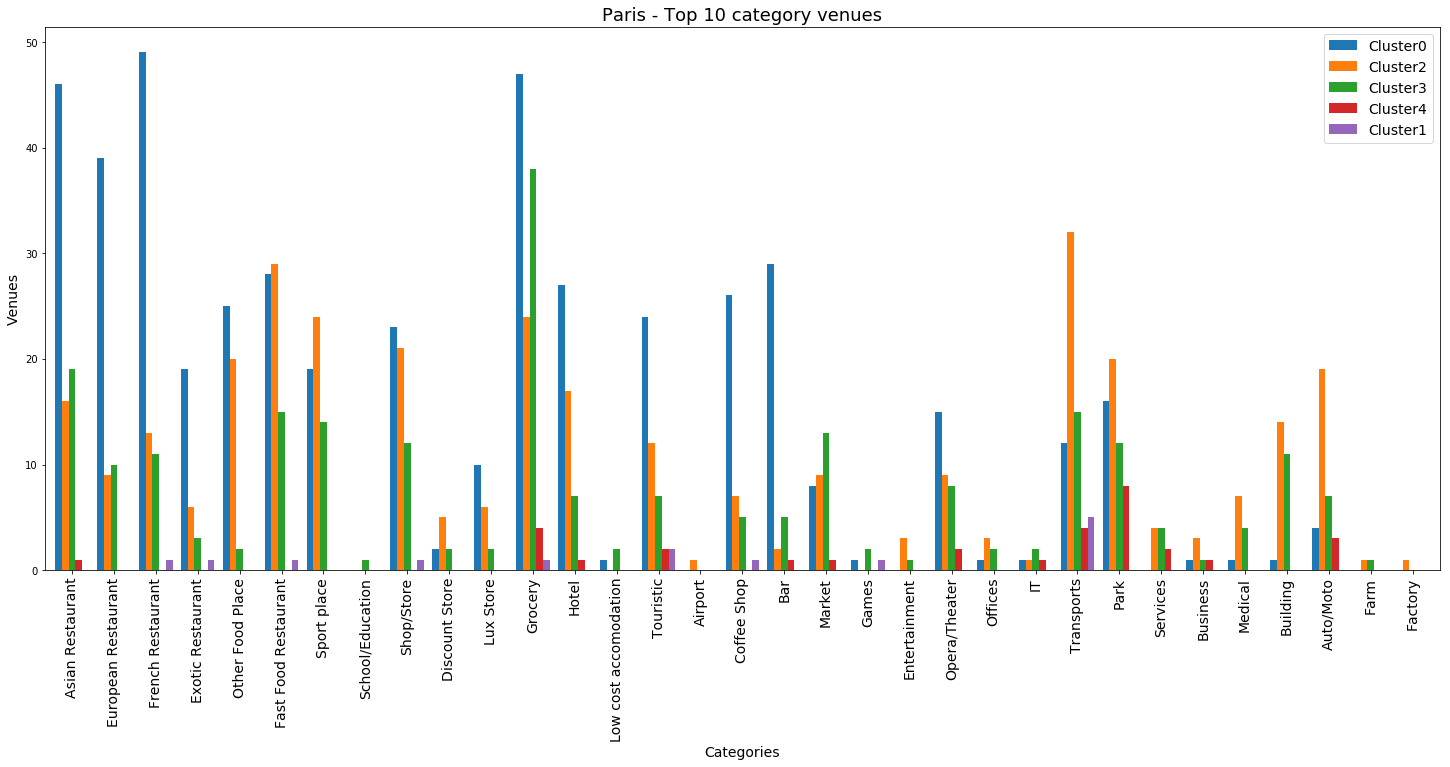

In [248]:
ax = df_paris_analysis.plot.bar(figsize=(25, 10), width=0.8, rot=0)
ax.set_xlabel('Categories', fontsize=14)
ax.set_ylabel('Venues', fontsize=14)
ax.legend(fontsize=14)
ax.set_title('Paris - Top 10 category venues', fontsize=18)
plt.xticks(fontsize=14, rotation=90);

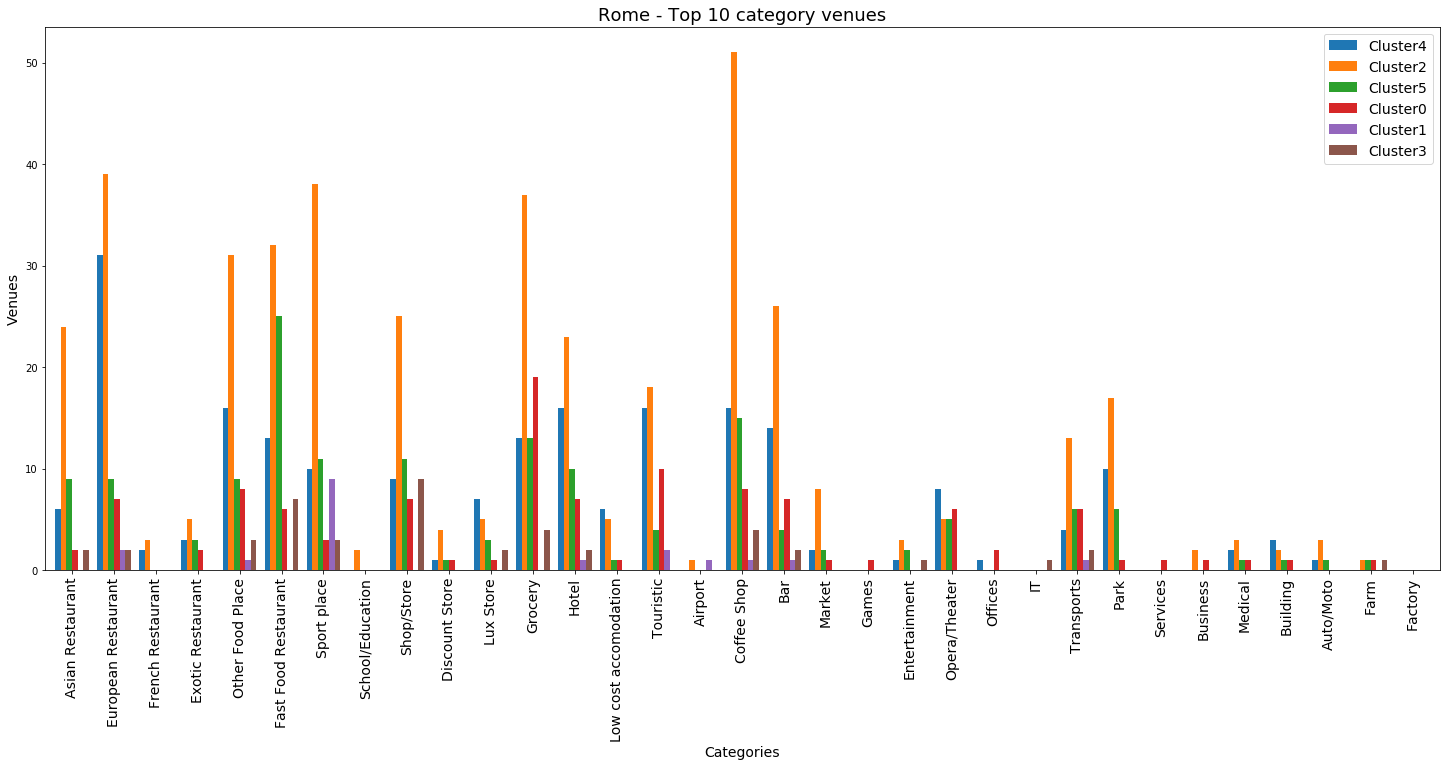

In [249]:
ax = df_roma_analysis.plot.bar(figsize=(25, 10), width=0.8, rot=0)
ax.set_xlabel('Categories', fontsize=14)
ax.set_ylabel('Venues', fontsize=14)
ax.legend(fontsize=14)
ax.set_title('Rome - Top 10 category venues', fontsize=18)

plt.xticks(fontsize=14, rotation=90);

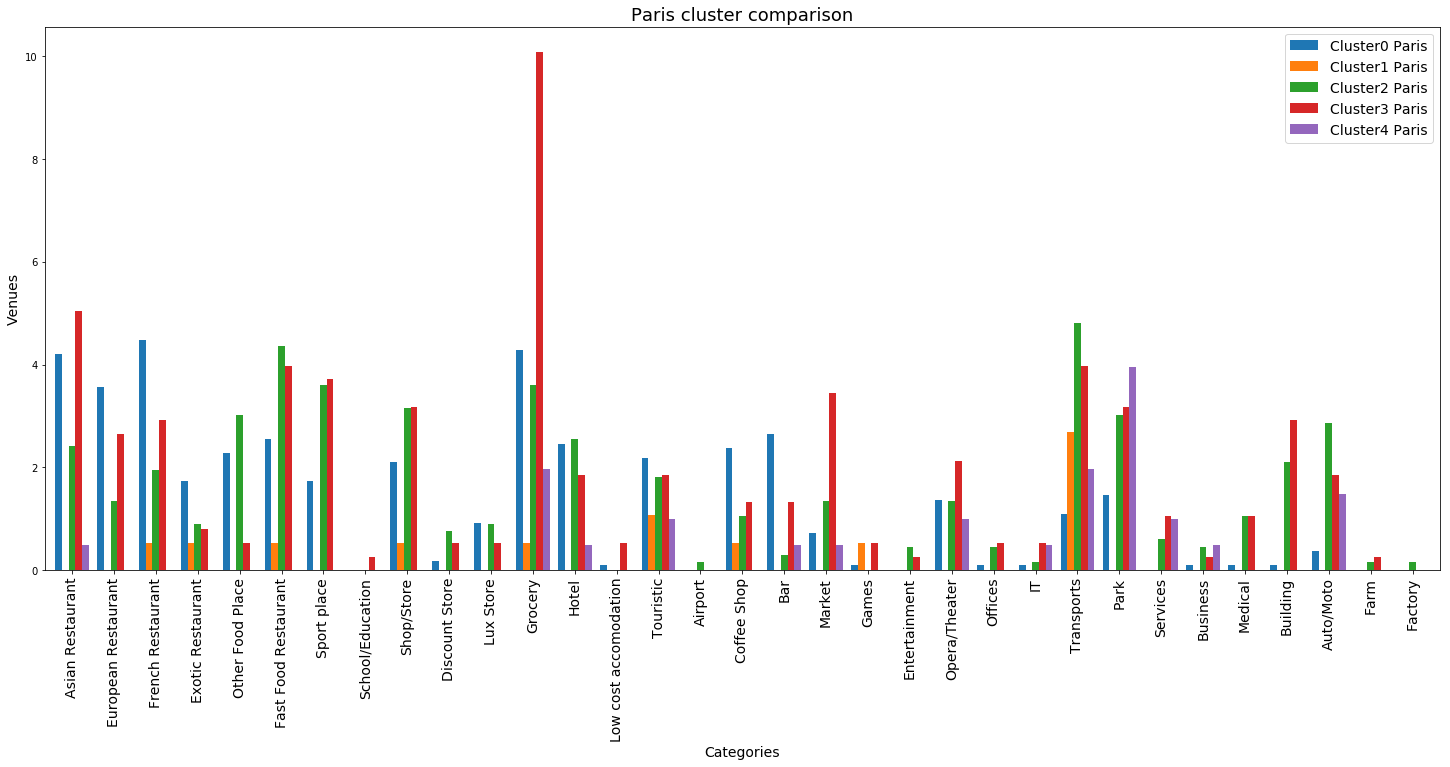

In [259]:
df_comparison_paris=df_comparison[["Cluster0 Paris","Cluster1 Paris", "Cluster2 Paris", "Cluster3 Paris", "Cluster4 Paris"]]

ax = df_comparison_paris.plot.bar(figsize=(25, 10), width=0.8, rot=0)
ax.set_xlabel('Categories', fontsize=14)
ax.set_ylabel('Venues', fontsize=14)
ax.legend(fontsize=14)
ax.set_title('Paris cluster comparison', fontsize=18)
plt.xticks(fontsize=14, rotation=90);

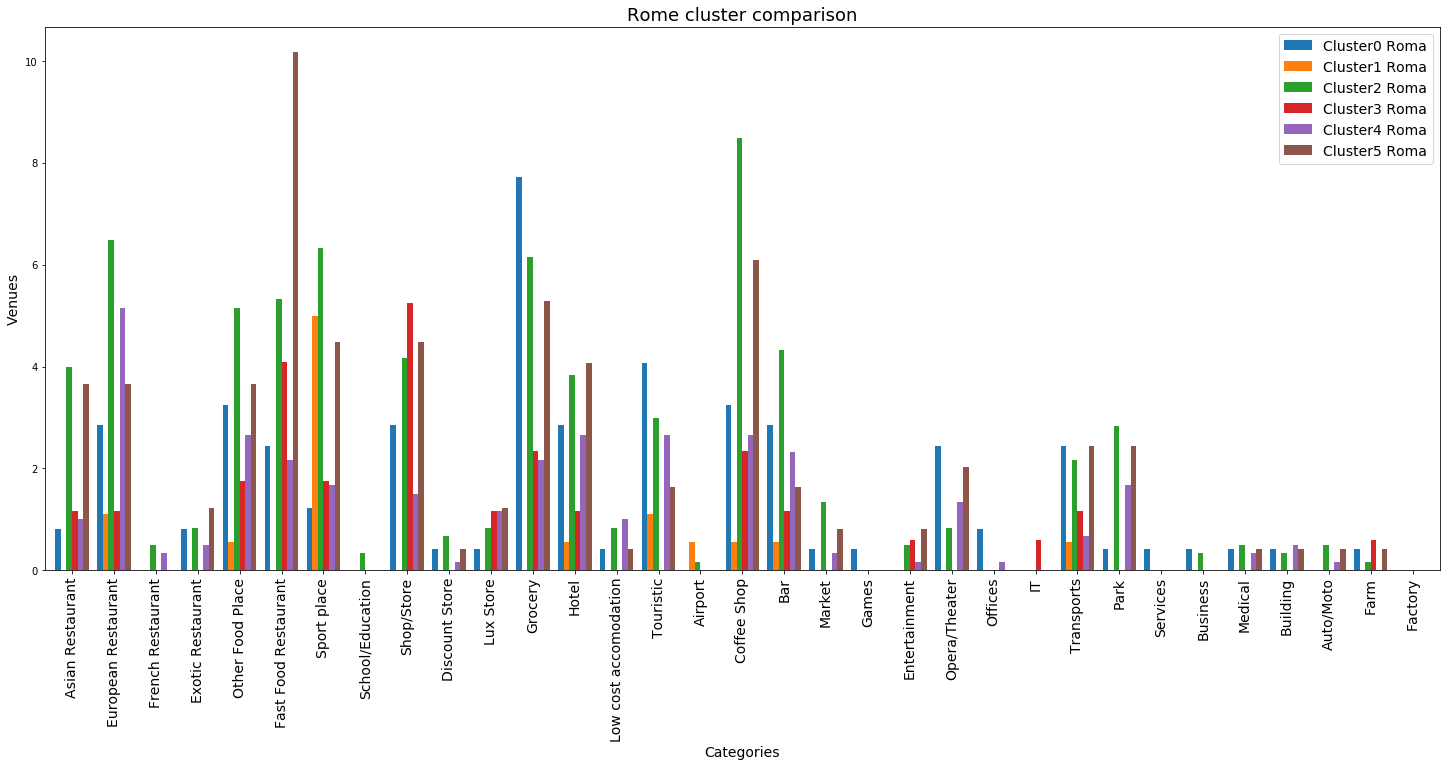

In [261]:
df_comparison_roma=df_comparison[["Cluster0 Roma","Cluster1 Roma", "Cluster2 Roma", "Cluster3 Roma", "Cluster4 Roma", "Cluster5 Roma" ]]

ax = df_comparison_roma.plot.bar(figsize=(25, 10), width=0.8, rot=0)
ax.set_xlabel('Categories', fontsize=14)
ax.set_ylabel('Venues', fontsize=14)
ax.legend(fontsize=14)
ax.set_title('Rome cluster comparison', fontsize=18)
plt.xticks(fontsize=14, rotation=90);

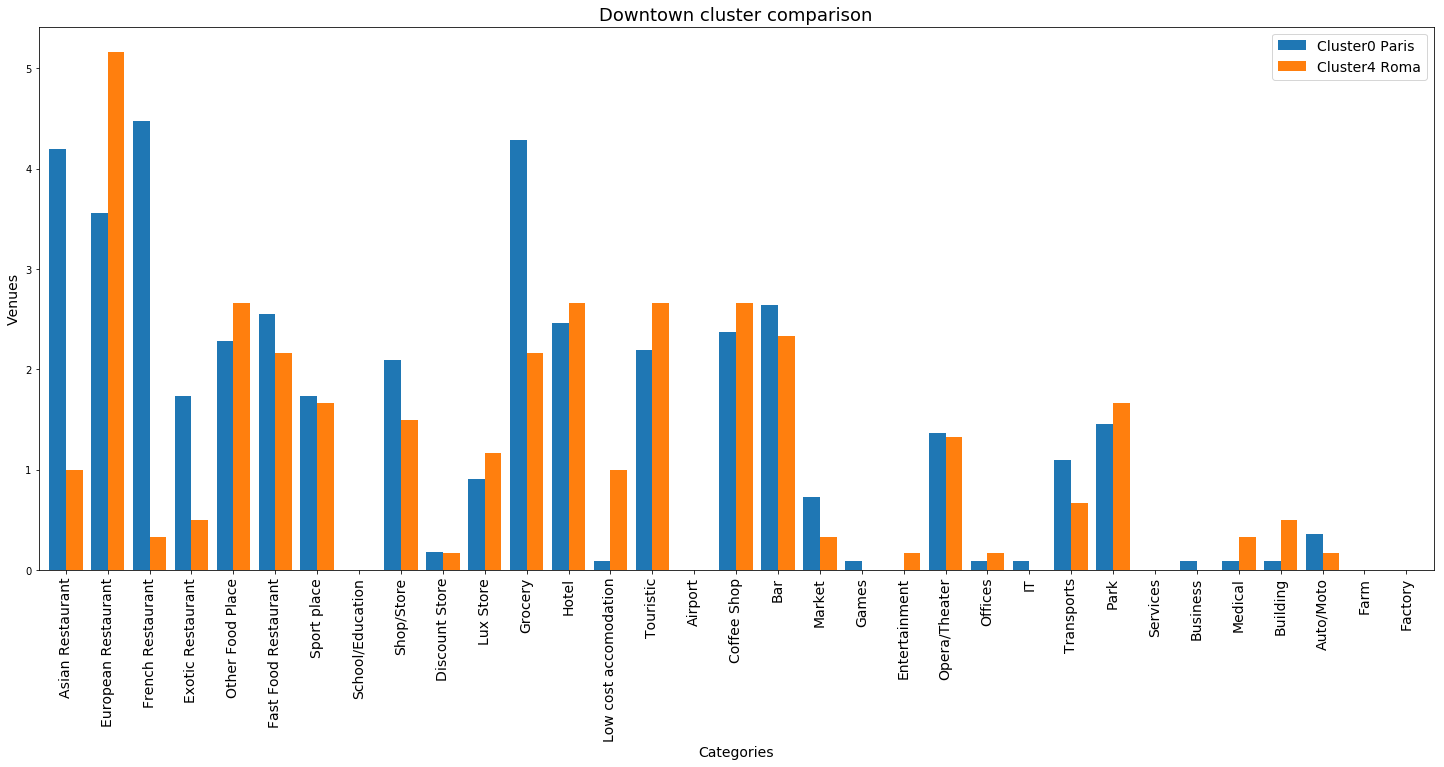

In [278]:
df_comparison_downtown=df_comparison[["Cluster0 Paris","Cluster4 Roma"]]

ax = df_comparison_downtown.plot.bar(figsize=(25, 10), width=0.8, rot=0)
ax.set_xlabel('Categories', fontsize=14)
ax.set_ylabel('Venues', fontsize=14)
ax.legend(fontsize=14)
ax.set_title('Downtown cluster comparison', fontsize=18)
plt.xticks(fontsize=14, rotation=90);

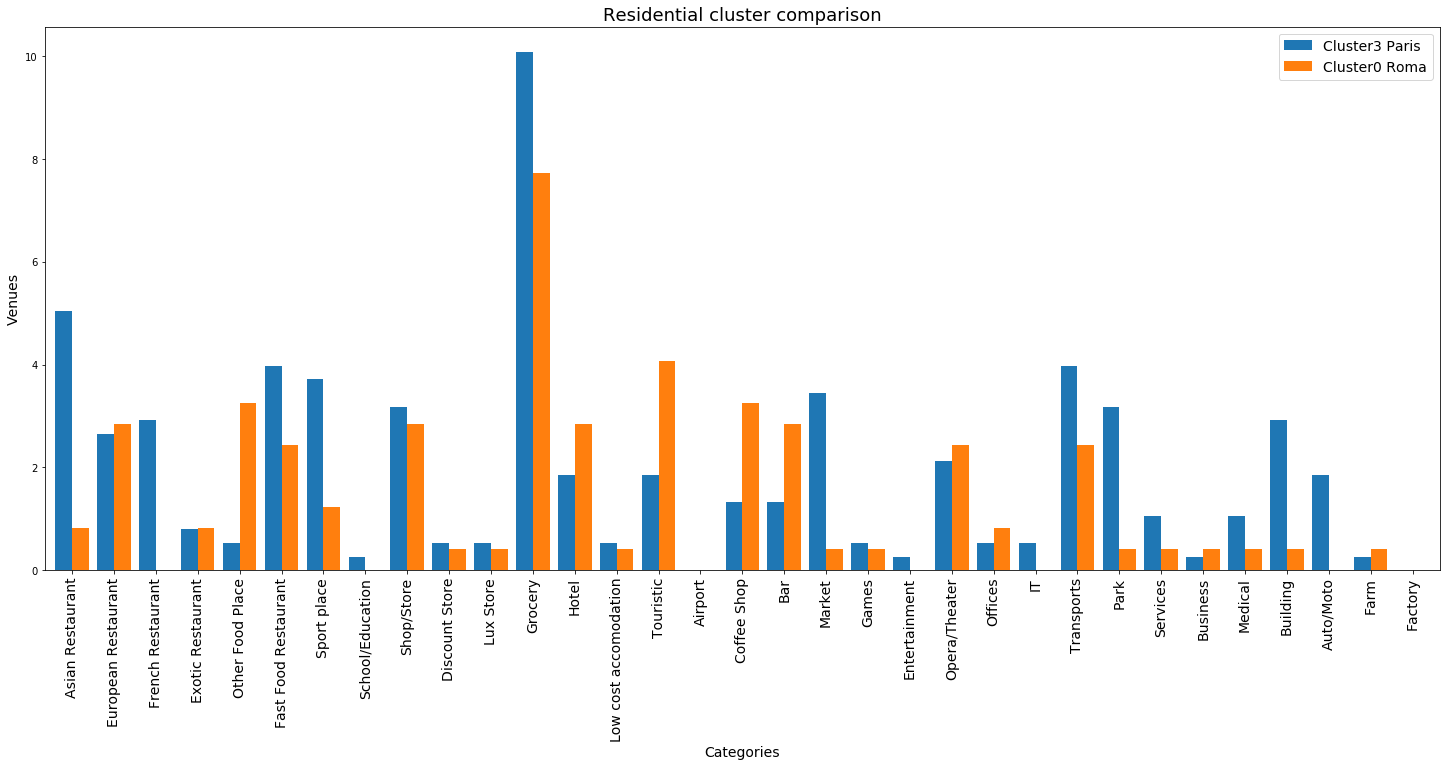

In [280]:
df_comparison_residential=df_comparison[["Cluster3 Paris","Cluster0 Roma"]]

ax = df_comparison_residential.plot.bar(figsize=(25, 10), width=0.8, rot=0)
ax.set_xlabel('Categories', fontsize=14)
ax.set_ylabel('Venues', fontsize=14)
ax.legend(fontsize=14)
ax.set_title('Residential cluster comparison', fontsize=18)
plt.xticks(fontsize=14, rotation=90);

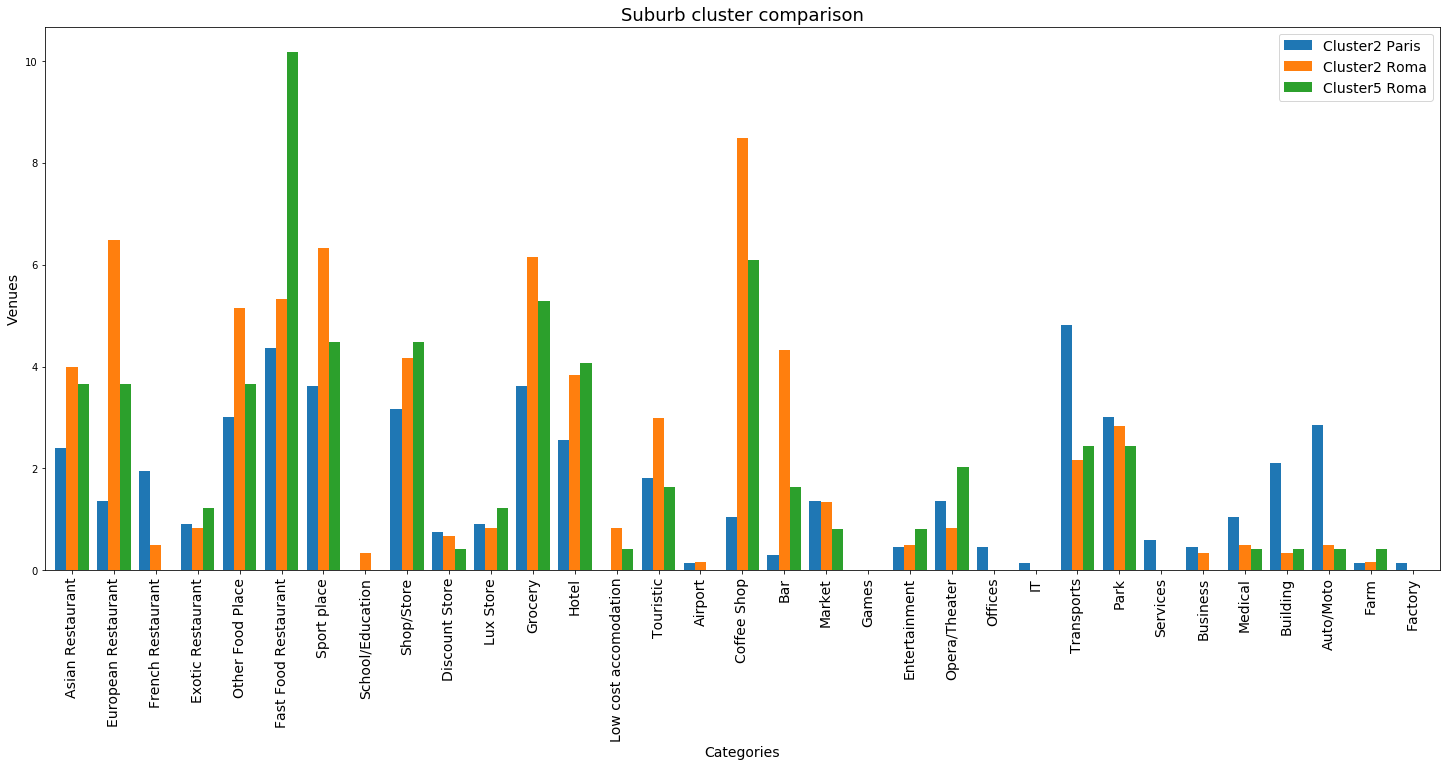

In [281]:
df_comparison_suburb=df_comparison[["Cluster2 Paris","Cluster2 Roma","Cluster5 Roma",]]

ax = df_comparison_suburb.plot.bar(figsize=(25, 10), width=0.8, rot=0)
ax.set_xlabel('Categories', fontsize=14)
ax.set_ylabel('Venues', fontsize=14)
ax.legend(fontsize=14)
ax.set_title('Suburb cluster comparison', fontsize=18)
plt.xticks(fontsize=14, rotation=90);

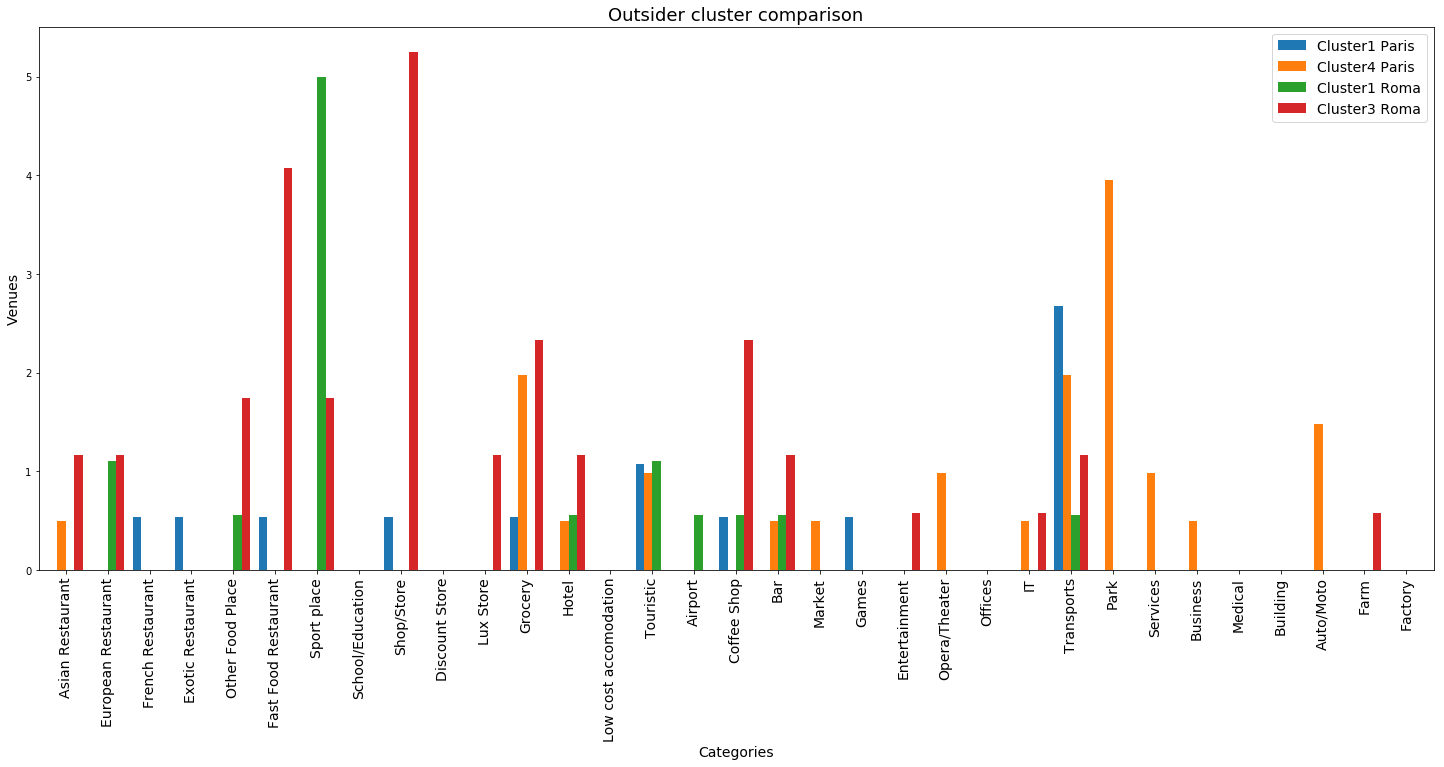

In [283]:
df_comparison_outsider=df_comparison[["Cluster1 Paris","Cluster4 Paris","Cluster1 Roma","Cluster3 Roma"]]

ax = df_comparison_outsider.plot.bar(figsize=(25, 10), width=0.8, rot=0)
ax.set_xlabel('Categories', fontsize=14)
ax.set_ylabel('Venues', fontsize=14)
ax.legend(fontsize=14)
ax.set_title('Outsider cluster comparison', fontsize=18)
plt.xticks(fontsize=14, rotation=90);